In [1]:
!pip3 install --no-cache-dir --upgrade git+https://github.com/evfro/polara.git@develop#egg=polara

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/evfro/polara.git (to revision develop) to /tmp/pip-install-fswnmgch/polara_e9f7a3ee1aee4bef85936d915026c9aa
  Running command git clone --filter=blob:none --quiet https://github.com/evfro/polara.git /tmp/pip-install-fswnmgch/polara_e9f7a3ee1aee4bef85936d915026c9aa
  Running command git checkout -b develop --track origin/develop
  Switched to a new branch 'develop'
  Branch 'develop' set up to track remote branch 'develop' from 'origin'.
  Resolved https://github.com/evfro/polara.git to commit 8e48cfd88e616ca53f8bbda1702a3e2c8abaf38e
  Preparing metadata (setup.py) ... done
  Created wheel for polara: filename=polara-0.7.2.dev0-py3-none-any.whl size=89455 sha256=8b20b1b694ffcadfe37c708e9de299255a0563a323dd0f981bda6c033670c004
  Stored in directory: /tmp/pip-ephem-wheel-cache-grqokw6s/wheels/d2/cf/bf/e1a3e49c4a733261d717fa4732eadf0303dabcc48ba694ad7a
Successfull

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.parametrizations import orthogonal
from torch.nn import functional as F
from IPython.display import clear_output

from tqdm.notebook import tqdm

from dataprep import transform_indices, full_preproccessing
from utils import topn_recommendations, downvote_seen_items, make_prediction

In [3]:
import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [4]:
def fix_torch_seed(seed, conv_determinism=True):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    # settings below may affect computational performance
    # see https://pytorch.org/docs/stable/notes/randomness.html:
    if conv_determinism:
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

def set_random_seed(seed):
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    
fix_torch_seed(42)
set_random_seed(42)

In [5]:
# answer = binary matrix (no ratings)
class MVDataset(Dataset):
    def __init__(self, data, data_description, augment=False):
        useridx = data[data_description['users']].values
        itemidx = data[data_description['items']].values
        feedbackidx = data[data_description['feedback']].values
        values = np.ones(len(itemidx), dtype=np.float32)
        
        self.tensor = torch.sparse_coo_tensor(np.array([useridx, itemidx, feedbackidx-1]), torch.tensor(values),
                                            size=torch.Size((data_description["n_users"], data_description["n_items"], data_description['n_ratings'])))
        self.matrix = torch.sparse_coo_tensor(np.array([useridx, itemidx]), torch.tensor(values),
                                      size=torch.Size((data_description["n_users"], data_description["n_items"])), dtype=torch.float32)
        
        self.augment = augment

    def __len__(self):
        return self.tensor.shape[0]

    def __getitem__(self, idx):
        if self.augment:
            num_noise = np.random.randint(0, int(0.1*self.matrix.shape[1]))
            idxs = torch.randint(0, self.matrix.shape[1], size=(num_noise,))
            noised_input = self.tensor[idx].detach().clone().to_dense()
            noised_input[idxs] = torch.distributions.bernoulli.Bernoulli(0.5).sample(sample_shape=(num_noise,))
            
            useridx = np.zeros_like(noised_input)
            itemidx = np.arange(self.matrix.shape[1])
            noised_input = torch.sparse_coo_tensor(np.array([itemidx,]), noised_input,
                                                   size=torch.Size((data_description["n_items"],)), dtype=torch.float32)
            return noised_input, self.matrix[idx]
        else:
            return self.tensor[idx], self.matrix[idx]

## Preprocess data

In [10]:
data = pd.read_csv('Amazon_Video_Games.csv')
data.rename(columns = {'reviewerID' : 'userid', 'asin' : 'movieid', "overall" : "rating", "unixReviewTime" : "timestamp"}, inplace = True)

In [11]:
training, testset_valid, holdout_valid, testset, holdout, data_description, data_index = full_preproccessing(data)

There are 24303 users
Filtered 17693 invalid observations.


In [12]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [13]:
device

device(type='cuda', index=0)

## Model: triangular matrix

In [14]:
batch_size = 16

In [15]:
train_dataset = MVDataset(training, data_description, augment=True)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [16]:
useridx = training[data_description['users']].values
itemidx = training[data_description['items']].values
feedbackidx = training[data_description['feedback']].values
values = np.ones(len(itemidx), dtype=np.float32)

tensor = torch.sparse_coo_tensor(np.array([useridx, itemidx, feedbackidx-1]), torch.tensor(values),
                                    size=torch.Size((data_description["n_users"], data_description["n_items"], data_description['n_ratings']))).to_dense()
matrix = torch.sparse_coo_tensor(np.array([useridx, itemidx]), torch.tensor(values),
                              size=torch.Size((data_description["n_users"], data_description["n_items"])), dtype=torch.float32).to_dense()

In [17]:
data_description['n_users']

13166

In [18]:
# len(train_dataloader)

In [19]:
data_description['n_items'], data_description['n_ratings']

(9906, 5)

In [ ]:
def triu_init(m):
    if isinstance(m, nn.Linear):
        with torch.no_grad():
            m.weight.copy_(torch.tril(m.weight))
            
def get_zero_grad_hook(mask):
    def hook(grad):
        return grad * mask
    return hook

In [ ]:
class AE(nn.Module):
    def __init__(self, n_items, n_ratings, hid1, hid2):
        super(AE, self).__init__()
        self.V = nn.Linear(n_items, hid1)
        torch.nn.init.xavier_uniform_(self.V.weight)
        self.W = nn.Linear(n_ratings, hid2)
        torch.nn.init.xavier_uniform_(self.W.weight)
        self.L = nn.Linear(n_ratings, n_ratings, bias=False)
        torch.nn.init.xavier_uniform_(self.L.weight)
        triu_init(self.L)
        self.norm = nn.LayerNorm(n_ratings)
        self.vec = nn.Linear(n_ratings, 1)
        torch.nn.init.xavier_uniform_(self.vec.weight)
        
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        
    def forward(self, x):
        # encode
        x = self.L(x)
        x = self.relu(x)
        x = self.W(x)
        x = self.relu(x)
        xT = torch.transpose(x, -1, -2)
        yT = self.V(xT)
        y = torch.transpose(yT, -1, -2)
        y = self.relu(y)
        # decode
        output = torch.matmul(y, self.W.weight)
        output = self.relu(output)
        output = torch.matmul(output, self.L.weight)
        output = self.relu(output)
        outputT = torch.transpose(output, -1, -2)
        outputT = torch.matmul(outputT, self.V.weight)
        output = torch.transpose(outputT, -1, -2)
#         output = self.relu(output)
        # vec
        output = self.vec(output).squeeze(-1)
        return output

In [ ]:
fix_torch_seed(42)
set_random_seed(42)

ae = AE(data_description['n_items'], data_description['n_ratings'], 256, 3).to(device)
criterion = nn.BCEWithLogitsLoss().to(device)
optimizer = optim.Adam(ae.parameters())
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

In [ ]:
ae.L.weight# @ ae.L.weight

Parameter containing:
tensor([[-0.1739,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.1754,  0.6074,  0.0000,  0.0000,  0.0000],
        [ 0.5197,  0.3342, -0.5307,  0.0000,  0.0000],
        [ 0.2015,  0.0073, -0.5652,  0.0950,  0.0000],
        [-0.3428,  0.7385,  0.1949,  0.5154, -0.5906]], device='cuda:0',
       requires_grad=True)

In [ ]:
mask = torch.tril(torch.ones_like(ae.L.weight))
# Register with hook
ae.L.weight.register_hook(get_zero_grad_hook(mask))

In [ ]:
sum(p.numel() for p in ae.parameters() if p.requires_grad)

2536251

Epoch 2


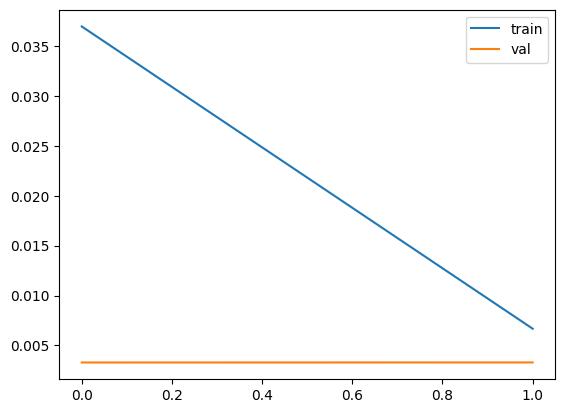

In [ ]:
# Training the AE
history = []
val_history = []

prev_train_loss = 1
prev_test_loss = 1
train_loss = 0.1 * len(train_dataloader)
test_loss = 0.1 * testset_valid.userid.nunique()
epoch = 1
best_valid_loss = float('inf')
num_batches = int(np.ceil(tensor.shape[0] / 16))

while prev_test_loss - test_loss / testset_valid.userid.nunique() > 1e-4 or test_loss / testset_valid.userid.nunique() > 0.13:
    if epoch > 1:
        prev_train_loss = train_loss / len(train_dataloader)
        prev_test_loss = test_loss / testset_valid.userid.nunique()
    train_loss = 0
    shuffle = np.random.choice(tensor.shape[0], size=tensor.shape[0], replace=False)
    tensor = tensor[shuffle]
    
    for batch in range(num_batches):
        optimizer.zero_grad()
        
#         user_tensor, user_matrix = batch
        
#         input_tensor = user_tensor.to_dense().to(device)
#         target = user_matrix.to_dense().to(device)
        input_tensor = tensor[batch * batch_size: (batch+1) * batch_size].to(device)
        target = matrix[batch * batch_size: (batch+1) * batch_size].to(device)
        
        output = ae(input_tensor)
        target.require_grad = False # we don't use it in training

        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.data.item()
    
    scheduler.step()
    history.append(train_loss / len(train_dataloader))
    
    test_loss = 0
    with torch.no_grad():
        for user in testset_valid.userid.unique():
            itemidx = testset_valid.loc[testset_valid.userid == user, data_description['items']].values
            feedbackidx = testset_valid.loc[testset_valid.userid == user, data_description['feedback']].values
            values = np.ones(len(itemidx), dtype=np.float32)

            user_tensor_test = torch.sparse_coo_tensor(np.array([itemidx, feedbackidx-1]), torch.tensor(values),
                                      size=torch.Size((data_description["n_items"], data_description['n_ratings']))).to_dense().to(device).unsqueeze(0)
            target = torch.sparse_coo_tensor(np.array([itemidx]), torch.tensor(values),
                                      size=torch.Size((data_description["n_items"], ))).to_dense().to(device).unsqueeze(0)

            output = ae(user_tensor_test)
            target.require_grad = False

            loss = criterion(output, target)
            test_loss += loss.data.item()
    
    valid_loss = test_loss / testset_valid.userid.nunique()
    val_history.append(valid_loss)
#         print('test loss: '+str(test_loss / testset.userid.nunique()))
    
    if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(ae.state_dict(), 'best-model.pt')
    
    clear_output()
    print('Epoch', epoch)
    plt.plot(history, label='train')
    plt.plot(val_history, label='val')
    plt.legend()
    plt.show()
    epoch += 1
#     print('epoch: '+str(epoch)+' loss: '+str(train_loss / len(train_dataloader)))

Epoch 1


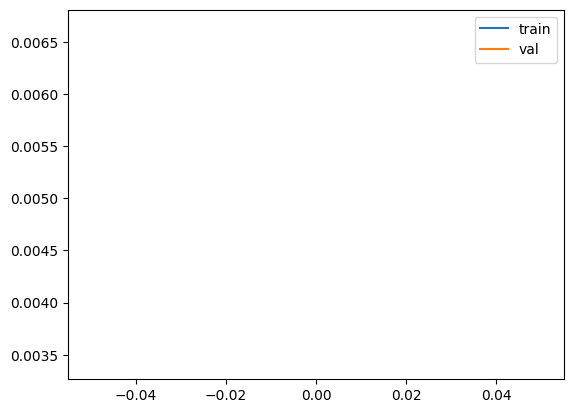

KeyboardInterrupt: ignored

In [ ]:
# Training the AE
history = []
val_history = []

prev_train_loss = 1
prev_test_loss = 1
train_loss = 0.1 * len(train_dataloader)
test_loss = 0.1 * testset_valid.userid.nunique()
epoch = 1
best_valid_loss = float('inf')

while prev_test_loss - test_loss / testset_valid.userid.nunique() > 1e-4 or test_loss / testset_valid.userid.nunique() > 0.13:
    if epoch > 1:
        prev_train_loss = train_loss / len(train_dataloader)
        prev_test_loss = test_loss / testset_valid.userid.nunique()
    train_loss = 0
    for batch in train_dataloader:
        optimizer.zero_grad()
        
        user_tensor, user_matrix = batch
        
        input_tensor = user_tensor.to_dense().to(device)
        target = user_matrix.to_dense().to(device)
        
        output = ae(input_tensor)
        target.require_grad = False # we don't use it in training

        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.data.item()
    
    scheduler.step()
    history.append(train_loss / len(train_dataloader))
    
    test_loss = 0
    with torch.no_grad():
        for user in testset_valid.userid.unique():
            itemidx = testset_valid.loc[testset_valid.userid == user, data_description['items']].values
            feedbackidx = testset_valid.loc[testset_valid.userid == user, data_description['feedback']].values
            values = np.ones(len(itemidx), dtype=np.float32)

            user_tensor_test = torch.sparse_coo_tensor(np.array([itemidx, feedbackidx-1]), torch.tensor(values),
                                      size=torch.Size((data_description["n_items"], data_description['n_ratings']))).to_dense().to(device).unsqueeze(0)
            target = torch.sparse_coo_tensor(np.array([itemidx]), torch.tensor(values),
                                      size=torch.Size((data_description["n_items"], ))).to_dense().to(device).unsqueeze(0)

            output = ae(user_tensor_test)
            target.require_grad = False

            loss = criterion(output, target)
            test_loss += loss.data.item()
    
    valid_loss = test_loss / testset_valid.userid.nunique()
    val_history.append(valid_loss)
#         print('test loss: '+str(test_loss / testset.userid.nunique()))
    
    if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(ae.state_dict(), 'best-model.pt')
    
    clear_output()
    print('Epoch', epoch)
    plt.plot(history, label='train')
    plt.plot(val_history, label='val')
    plt.legend()
    plt.show()
    epoch += 1
#     print('epoch: '+str(epoch)+' loss: '+str(train_loss / len(train_dataloader)))

In [ ]:
ae.L.weight

Parameter containing:
tensor([[ 0.2866,  0.0000,  0.0000,  0.0000,  0.0000],
        [-0.2183,  0.7017,  0.0000,  0.0000,  0.0000],
        [ 0.6568,  0.4349,  0.4149,  0.0000,  0.0000],
        [-0.5878, -0.5329,  0.2993, -0.3123,  0.0000],
        [-0.6317, -0.6667, -0.0076, -0.1822, -0.6780]], device='cuda:0',
       requires_grad=True)

In [ ]:
ae.L.weight @ ae.L.weight.T

tensor([[ 0.0821, -0.0626,  0.1882, -0.1684, -0.1810],
        [-0.0626,  0.5401,  0.1618, -0.2456, -0.3299],
        [ 0.1882,  0.1618,  0.7928, -0.4937, -0.7081],
        [-0.1684, -0.2456, -0.4937,  0.8167,  0.7813],
        [-0.1810, -0.3299, -0.7081,  0.7813,  1.3366]], device='cuda:0',
       grad_fn=<MmBackward0>)

In [ ]:
# Testing the AE
test_loss = 0
ae = AE(data_description['n_items'], data_description['n_ratings'], 2, 3).to(device)
# model.load_state_dict(torch.load('best-model.pt'))

# scores = torch.zeros((len(testset.userid.unique()), data_description['n_items']))
useridx = pd.factorize(testset[data_description['users']])[0]
itemidx = testset[data_description['items']].values
feedbackidx = testset[data_description['feedback']].values
values = np.ones(len(itemidx), dtype=np.float32)

user_tensor_test = torch.sparse_coo_tensor(np.array([useridx, itemidx, feedbackidx-1]), torch.tensor(values),
                              size=torch.Size((data_description["n_users"], data_description["n_items"], data_description['n_ratings']))).to_dense().to(device).unsqueeze(0)
target = torch.sparse_coo_tensor(np.array([useridx, itemidx]), torch.tensor(values),
                              size=torch.Size((data_description["n_users"], data_description["n_items"], ))).to_dense().to(device).unsqueeze(0)
output = ae(user_tensor_test)
target.require_grad = False

loss = criterion(output, target)
  
print('test loss: '+str(loss / testset.userid.nunique()))

OutOfMemoryError: ignored

In [ ]:
# Testing the AE
test_loss = 0
model = AE(data_description['n_items'], data_description['n_ratings'], 256, 3).to(device)
model.load_state_dict(torch.load('best-model.pt'))

scores = torch.zeros((len(testset.userid.unique()), data_description['n_items']))

for i, user in enumerate(testset.userid.unique()):
    itemidx = testset.loc[testset.userid == user, data_description['items']].values
    feedbackidx = testset.loc[testset.userid == user, data_description['feedback']].values
    values = np.ones(len(itemidx), dtype=np.float32)

    user_tensor_test = torch.sparse_coo_tensor(np.array([itemidx, feedbackidx-1]), torch.tensor(values),
                              size=torch.Size((data_description["n_items"], data_description['n_ratings']))).to_dense().to(device).unsqueeze(0)
    target = torch.sparse_coo_tensor(np.array([itemidx]), torch.tensor(values),
                              size=torch.Size((data_description["n_items"], ))).to_dense().to(device).unsqueeze(0)
    
    output = ae(user_tensor_test)
    target.require_grad = False
    scores[i] = output[0].T

    loss = criterion(output, target)
    test_loss += loss.data.item()

scores = scores.detach().numpy()    
print('test loss: '+str(test_loss / testset.userid.nunique()))

<ipython-input-25-bae83d49a316>:20: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3571.)
  scores[i] = output[0].T


OutOfMemoryError: ignored

In [ ]:
# our
downvote_seen_items(scores, testset, data_description)
make_prediction(scores, holdout, data_description)

### Tuning

In [29]:
def prepare_tensor(data, data_description):
    useridx = pd.factorize(data[data_description['users']])[0]
    itemidx = data[data_description['items']].values
    feedbackidx = data[data_description['feedback']].values
    values = np.ones(len(itemidx), dtype=np.float32)
    user_tensor_test = torch.sparse_coo_tensor(np.array([useridx, itemidx, feedbackidx-1]), torch.tensor(values),
                                      size=torch.Size((data[data_description['users']].nunique(), data_description["n_items"], data_description['n_ratings']))).to_dense().to(device)
    target_test = torch.sparse_coo_tensor(np.array([useridx, itemidx]), torch.tensor(values),
                                      size=torch.Size((data[data_description['users']].nunique(), data_description["n_items"], ))).to_dense().to(device)
    return user_tensor_test, target_test

In [30]:
def predict_and_check(scores, holdout, data_description, hrs, mrrs, cs, ndcgs, alpha, prev_matt, epoch, disp=False, dcg=True):
    mrr10, hr10, c10, ndcg10 = make_prediction(scores, holdout, data_description, disp=disp, dcg=dcg, alpha=alpha)
    hrs.append(hr10)
    mrrs.append(mrr10)
    cs.append(c10)
    ndcgs.append(ndcg10)

    if np.max(prev_matt) < cs[-1] or epoch == 1:
        prev_matt = [cs[-1]]
        torch.save(ae.state_dict(), f'best_ae_{h1}_{h2}_{alpha}.pt')
#     elif prev_matt[-1] < cs[-1]:
#         prev_matt = [cs[-1]]
    else:
        prev_matt.append(cs[-1])
        
    return prev_matt

In [31]:
def check_test(ae, criterion, user_tensor_test, target_test, testset, holdout, data_description, test_num_batches, alpha, batch_size=16, dcg=True):
    test_loss = 0
    scores = torch.zeros((len(testset.userid.unique()), data_description['n_items']))
    
    ae.load_state_dict(torch.load(f'best_ae_{h1}_{h2}_{alpha}.pt'))
    with torch.no_grad():
        for batch in range(test_num_batches):
            input_tensor = user_tensor_test[batch * batch_size: (batch+1) * batch_size].to(device)
            target = target_test[batch * batch_size: (batch+1) * batch_size].to(device)

            output = ae(input_tensor)
            target.require_grad = False

            test_loss += criterion(output, target)
            scores[batch * batch_size: (batch+1) * batch_size] = output

    test_loss = test_loss / test_num_batches
    scores = scores.detach().cpu().numpy()
    downvote_seen_items(scores, testset, data_description)
    print(f'Results for alpha={alpha}')
    mrr10, hr10, c10, ndcg10 = make_prediction(scores, holdout, data_description, dcg=dcg, alpha=alpha)

In [ ]:
grid1 = 2**np.arange(4, 11)
grid2 = np.arange(3, 6)
grid = np.meshgrid(grid2, grid1)

  0%|          | 0/21 [00:00<?, ?it/s]

Hidden sizes: 16 3
Current epoch 92
Results for alpha=2


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.005293  0.002686    0.000707  0.003326  0.004745  0.000548    0.00243   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.000256    0.003003    0.000324   -0.017072

HR@10   MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.012046  0.00349     0.001312  0.005413   0.011316    0.00073   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.003212    0.000278     0.005032     0.000381    -0.004467

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.023362  0.004253     0.002423  0.008247   0.022449   0.000913   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.003961    0.000291     0.007819     0.000428     0.008798

Results for alpha=3


HR@5    MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.005293  0.00264    0.000707  0.003288  0.004198  0.001095   0.002065   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.000575    0.002588      0.0007   -0.026514

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.010403  0.003274     0.001312  0.004892   0.009126   0.001278   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.002681    0.000593     0.004139     0.000753    -0.008341

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.023544  0.004183     0.002423  0.008211   0.021354    0.00219   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.003522    0.000661     0.007221      0.00099     0.002883

Results for alpha=4


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.009856  0.008852    0.000808  0.009099  0.008578  0.001278   0.007833   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.001019    0.008017    0.001082     0.01893

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.013141  0.009268     0.001413  0.010139   0.011133   0.002008   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.008162    0.001106     0.008831     0.001308     0.015295

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.020989  0.009797     0.002625  0.012105   0.018069    0.00292   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.008639    0.001159     0.010579     0.001526     0.024345

Results for alpha=5


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.009856  0.008843    0.000707  0.009091  0.008213  0.001643   0.007459   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.001384    0.007644    0.001447    0.046594

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.011863  0.009098     0.001312  0.009728   0.009491   0.002373   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.007622    0.001476     0.008049     0.001678       0.0437

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.021354  0.009727     0.002423  0.012091   0.016791   0.004563   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.008096    0.001631     0.009855     0.002236     0.054781

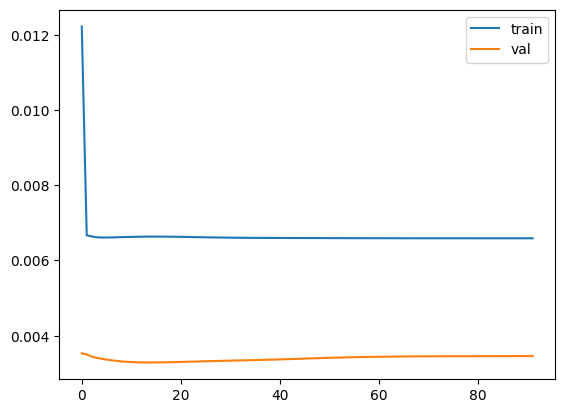

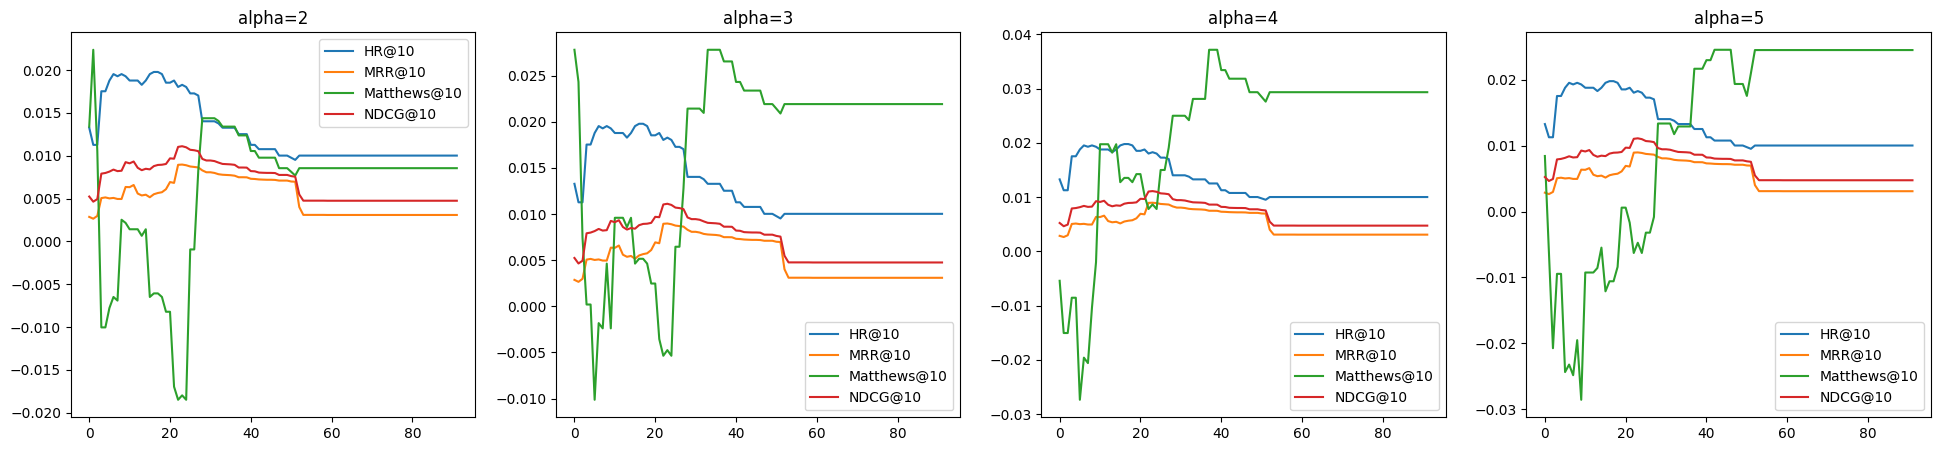

Test loss: 0.003378627123311162
Train loss: 0.006597019400434028


Hidden sizes: 16 4
Current epoch 66
Results for alpha=2


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.011498  0.009323    0.000808  0.009851  0.010951  0.000548   0.008922   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.000402    0.009415    0.000436    0.001965

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.015514  0.009841     0.001413  0.011132   0.014784    0.00073   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.009421     0.00042     0.010643     0.000488     0.002605

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.03194  0.011071     0.002625  0.015396   0.030663   0.001278   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.010612    0.000459     0.014768     0.000628     0.009563

Results for alpha=3


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.010768  0.009034    0.000808  0.009452  0.009673  0.001095   0.008061   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.000973    0.008448    0.001004   -0.001098

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.015331  0.009583     0.001413  0.010868   0.013689   0.001643   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.008547    0.001036     0.009697      0.00117    -0.003594

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.03048  0.010496     0.002625  0.014525    0.02829    0.00219   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.009424    0.001072     0.013219     0.001306     0.015884

Results for alpha=4


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.011316  0.005664    0.000808  0.007118  0.009673  0.001643   0.004843   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.000821    0.006086    0.001032    0.016194

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.027925  0.008047     0.001413  0.012659    0.02464   0.003285   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.007014    0.001032     0.011103     0.001555     0.037177

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.036138  0.008618     0.002625  0.014738   0.032123   0.004015   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.007536    0.001083     0.012999     0.001739     0.045599

Results for alpha=5


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.011316  0.005664    0.000808  0.007118  0.008578  0.002738   0.004295   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.001369      0.0054    0.001719     0.03349

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.027925  0.008047     0.001413  0.012659   0.022084    0.00584   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.006272    0.001775     0.009944     0.002714     0.064424

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.036138  0.008618     0.002625  0.014738   0.028655   0.007483   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20     0.00673    0.001888     0.011609      0.00313     0.074424

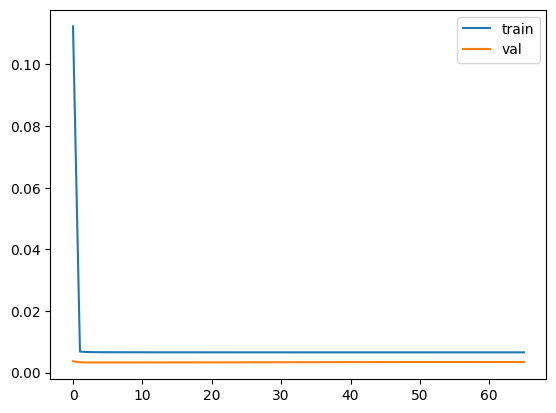

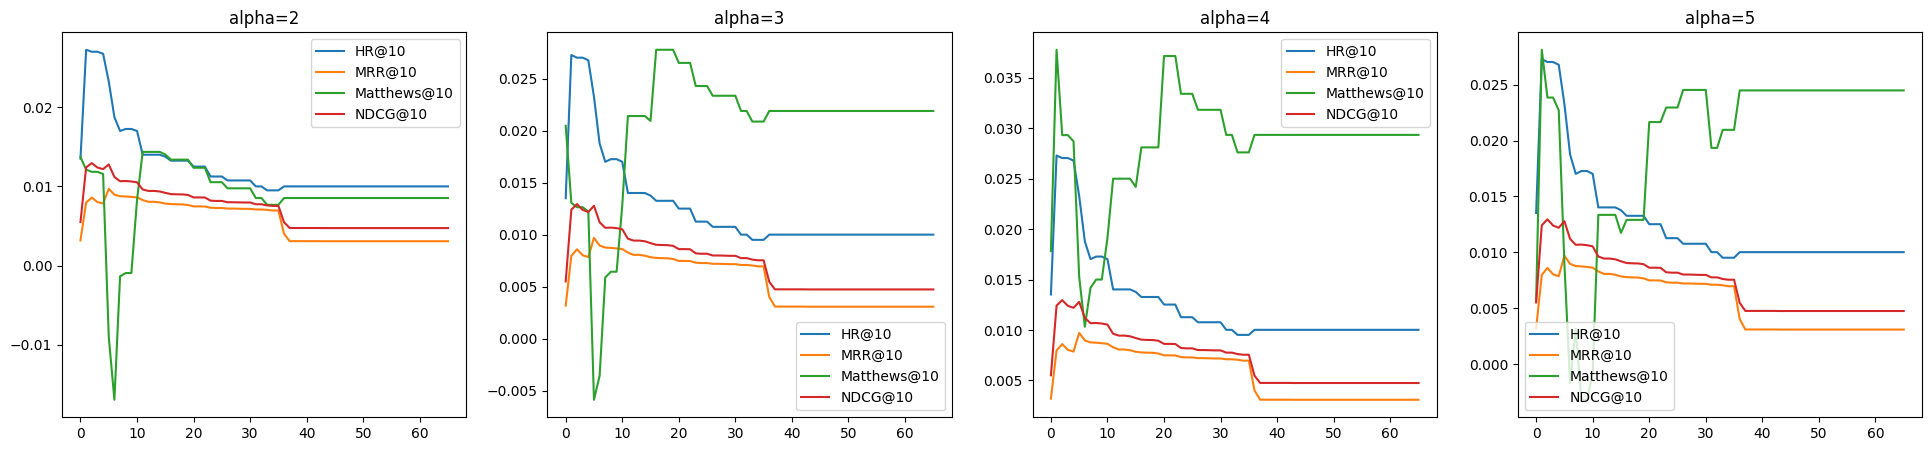

Test loss: 0.0033391620963811874
Train loss: 0.006598598573284443


Hidden sizes: 16 5
Current epoch 92
Results for alpha=2


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.011498  0.009323    0.000808  0.009851  0.010951  0.000548   0.008922   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.000402    0.009415    0.000436    0.001965

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.015514  0.009841     0.001413  0.011132   0.014784    0.00073   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.009421     0.00042     0.010643     0.000488     0.002605

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.033218  0.011141     0.002625  0.015696   0.031758    0.00146   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.010673    0.000468     0.015025      0.00067     0.006445

Results for alpha=3


HR@5     MRR@5  Coverage@5   NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.010038  0.008888    0.000808  0.00917  0.008943  0.001095   0.007915   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.000973    0.008166    0.001004   -0.003558

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.015331  0.009522     0.001413  0.010807   0.013689   0.001643   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.008487    0.001035     0.009638     0.001169    -0.003594

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.030297  0.010422     0.002625  0.014419   0.028107    0.00219   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.009353     0.00107     0.013115     0.001304     0.015578

Results for alpha=4


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.009856  0.008843    0.000808  0.009091  0.008578  0.001278   0.007824   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.001019    0.008009    0.001082     0.01893

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.013141  0.009263     0.001413  0.010135   0.011133   0.002008   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.008153     0.00111     0.008823     0.001312     0.015295

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.020989  0.009806     0.002625  0.012117   0.018069    0.00292   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.008643    0.001163     0.010587      0.00153     0.024345

Results for alpha=5


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.009856  0.008843    0.000707  0.009091  0.008213  0.001643   0.007459   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.001384    0.007644    0.001447    0.046594

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.011863  0.009098     0.001312  0.009728   0.009491   0.002373   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.007622    0.001476     0.008049     0.001678       0.0437

HR@20    MRR@20  Coverage@20  NCDG@20  HR_pos@20  HR_neg@20  \
20  0.021354  0.009734     0.002423   0.0121   0.016791   0.004563   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.008104    0.001631     0.009865     0.002235     0.054781

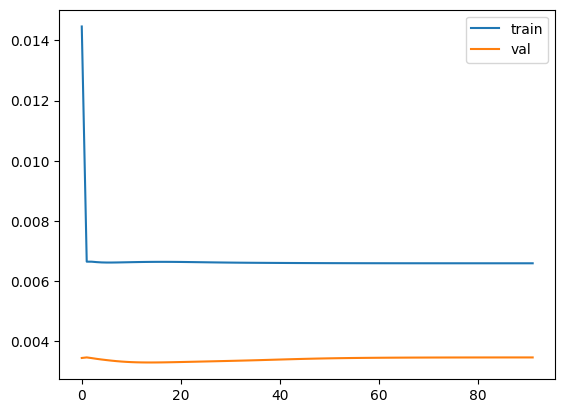

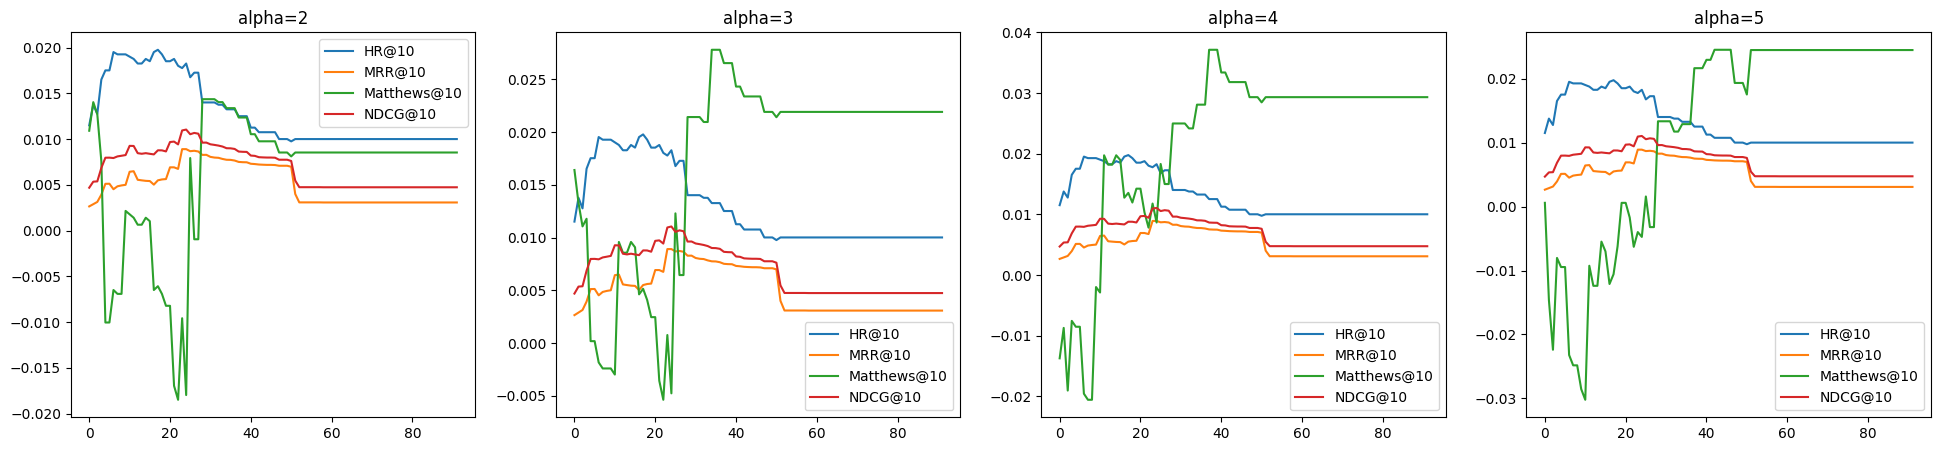

Test loss: 0.0033983206376433372
Train loss: 0.0065991888467770154


Hidden sizes: 32 3
Current epoch 95
Results for alpha=2


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.011498  0.009323    0.000808  0.009851  0.010951  0.000548   0.008922   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.000402    0.009415    0.000436    0.001965

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.015514  0.009841     0.001413  0.011132   0.014784    0.00073   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.009421     0.00042     0.010643     0.000488     0.002605

HR@20    MRR@20  Coverage@20  NCDG@20  HR_pos@20  HR_neg@20  \
20  0.033218  0.011137     0.002625  0.01569   0.031758    0.00146   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.010669    0.000468      0.01502      0.00067     0.006445

Results for alpha=3


HR@5    MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.005293  0.00264    0.000707  0.003288  0.004198  0.001095   0.002065   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.000575    0.002588      0.0007   -0.026514

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.010221  0.003287     0.001312  0.004871   0.009126   0.001095   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.002712    0.000575     0.004171       0.0007    -0.002927

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.023727  0.004281     0.002322  0.008358   0.021354   0.002373   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.003607    0.000674     0.007322     0.001036    -0.000754

Results for alpha=4


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.009856  0.008815    0.000808  0.009067  0.008578  0.001278   0.007806   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5    0.00101    0.007993    0.001074     0.01893

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.013324  0.009254     0.001413  0.010164   0.011316   0.002008   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.008153    0.001101     0.008859     0.001304     0.016003

HR@20    MRR@20  Coverage@20  NCDG@20  HR_pos@20  HR_neg@20  \
20  0.020989  0.009794     0.002625  0.01211   0.018069    0.00292   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20     0.00864    0.001154     0.010589     0.001522     0.024345

Results for alpha=5


HR@5     MRR@5  Coverage@5   NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.009673  0.008806    0.000707  0.00902  0.008031  0.001643   0.007422   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.001384    0.007573    0.001447     0.04552

HR@10   MRR@10  Coverage@10  NCDG@10  HR_pos@10  HR_neg@10  MRR_pos@10  \
10  0.011863  0.00909     0.001312  0.00972   0.009491   0.002373    0.007619   

    MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.001471     0.008046     0.001674       0.0437

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.021354  0.009714     0.002423  0.012075   0.016791   0.004563   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.008087    0.001627     0.009844     0.002231     0.054781

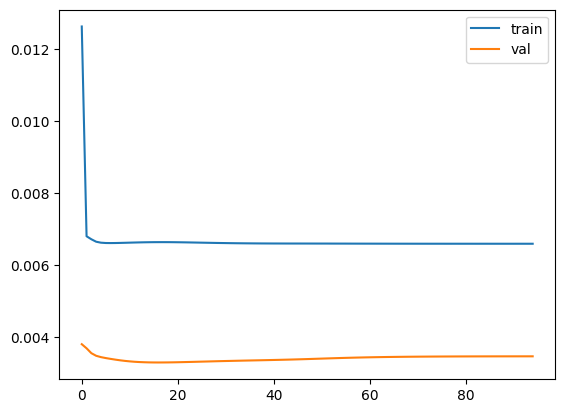

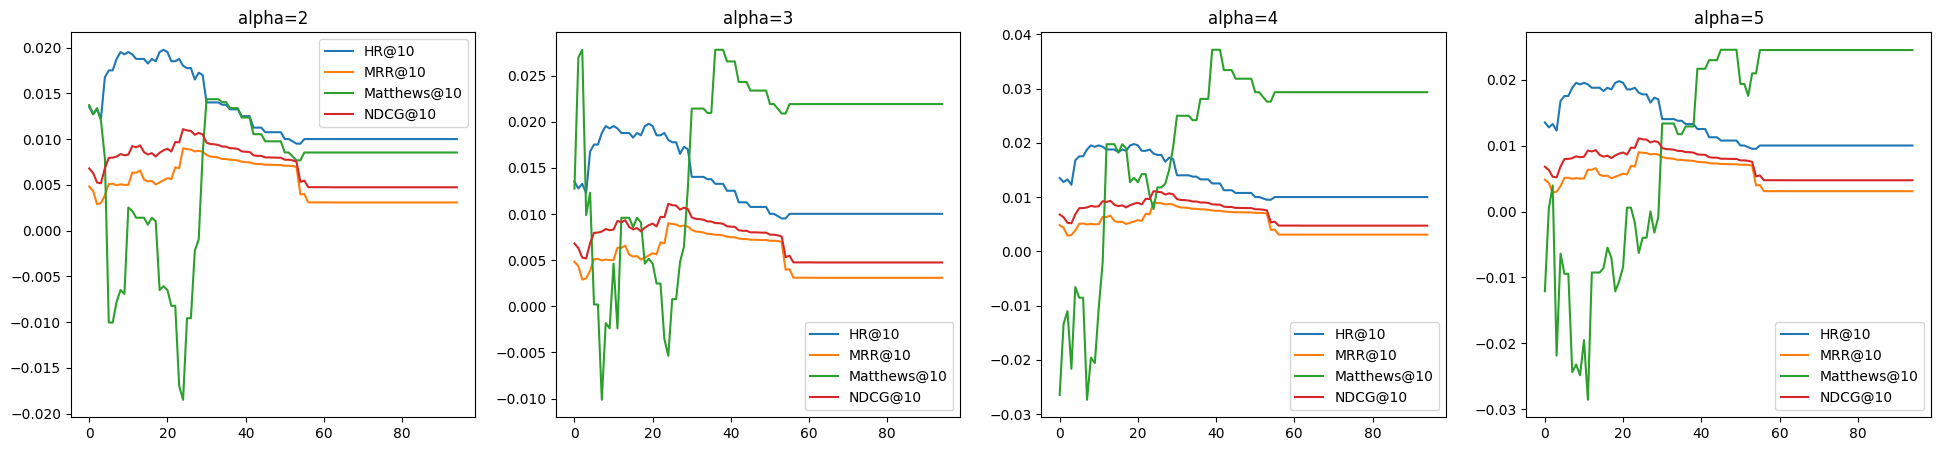

Test loss: 0.003371813800185919
Train loss: 0.006595619061321273


Hidden sizes: 32 4
Current epoch 94
Results for alpha=2


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.011498  0.009323    0.000808  0.009851  0.010951  0.000548   0.008922   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.000402    0.009415    0.000436    0.001965

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.015514  0.009841     0.001413  0.011132   0.014784    0.00073   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.009421     0.00042     0.010643     0.000488     0.002605

HR@20   MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  MRR_pos@20  \
20  0.03194  0.01107     0.002625  0.015395   0.030663   0.001278    0.010612   

    MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.000459     0.014767     0.000628     0.009563

Results for alpha=3


HR@5    MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.005293  0.00264    0.000707  0.003288  0.004198  0.001095   0.002065   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.000575    0.002588      0.0007   -0.026514

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.010768  0.003292     0.001312  0.004978   0.009491   0.001278   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.002698    0.000593     0.004225     0.000753    -0.007031

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.024822  0.004256     0.002423  0.008517   0.022632    0.00219   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20     0.00359    0.000666     0.007522     0.000996     0.005525

Results for alpha=4


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.009856  0.008825    0.000808  0.009075  0.008578  0.001278   0.007815   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5    0.00101    0.008001    0.001074     0.01893

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.013324  0.009259     0.001413  0.010168   0.011316   0.002008   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.008162    0.001097     0.008867       0.0013     0.016003

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.020989  0.009798     0.002625  0.012114   0.018069    0.00292   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.008649     0.00115     0.010597     0.001518     0.024345

Results for alpha=5


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.009856  0.008843    0.000808  0.009091  0.008213  0.001643   0.007459   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.001384    0.007644    0.001447    0.046594

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.011863  0.009096     0.001312  0.009726   0.009491   0.002373   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.007622    0.001475     0.008049     0.001677       0.0437

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.021354  0.009726     0.002423  0.012089   0.016791   0.004563   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.008096     0.00163     0.009854     0.002234     0.054781

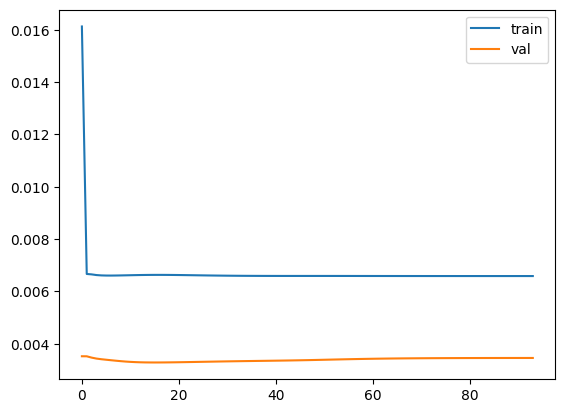

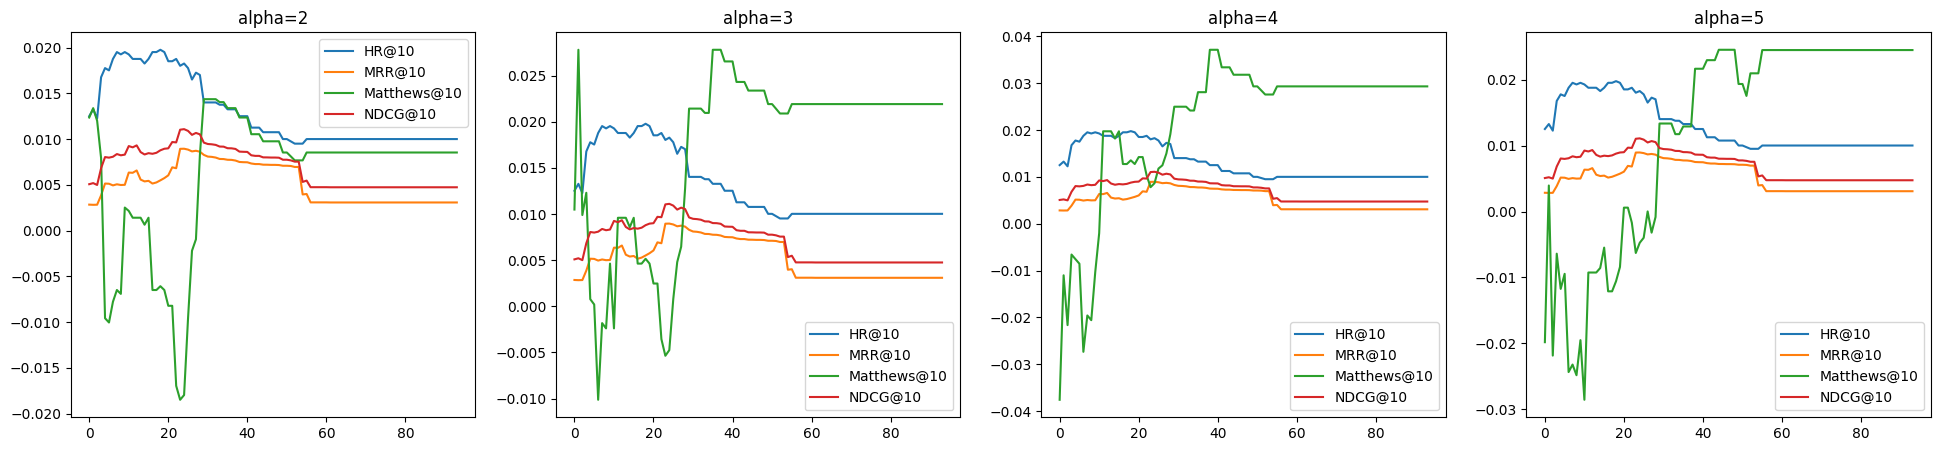

Test loss: 0.0033677394967526197
Train loss: 0.006593799900901781


Hidden sizes: 32 5
Current epoch 97
Results for alpha=2


HR@5     MRR@5  Coverage@5   NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.011316  0.009287    0.000808  0.00978  0.010951  0.000365   0.008922   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.000365    0.009415    0.000365    0.009375

HR@10    MRR@10  Coverage@10  NCDG@10  HR_pos@10  HR_neg@10  \
10  0.015514  0.009892     0.001413  0.01118   0.014784    0.00073   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.009478    0.000414     0.010698     0.000483     0.002605

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.03194  0.011121     0.002625  0.015445   0.030663   0.001278   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.010669    0.000453     0.014822     0.000623     0.009563

Results for alpha=3


HR@5     MRR@5  Coverage@5   NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.010038  0.008888    0.000808  0.00917  0.008943  0.001095   0.007915   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.000973    0.008166    0.001004   -0.003558

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.015331  0.009522     0.001413  0.010807   0.013689   0.001643   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.008487    0.001035     0.009638     0.001169    -0.003594

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.030297  0.010426     0.002625  0.014423   0.028107    0.00219   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.009355    0.001071     0.013118     0.001305     0.015578

Results for alpha=4


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.009856  0.008815    0.000808  0.009067  0.008578  0.001278   0.007806   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5    0.00101    0.007993    0.001074     0.01893

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.013324  0.009254     0.001413  0.010164   0.011316   0.002008   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.008153    0.001101     0.008859     0.001304     0.016003

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.020989  0.009796     0.002625  0.012114   0.018069    0.00292   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.008642    0.001154     0.010592     0.001522     0.024345

Results for alpha=5


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.010038  0.008879    0.000707  0.009162  0.008396  0.001643   0.007495   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.001384    0.007714    0.001447    0.047652

HR@10    MRR@10  Coverage@10  NCDG@10  HR_pos@10  HR_neg@10  \
10  0.011863  0.009111     0.001413  0.00974   0.009491   0.002373   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.007635    0.001476     0.008062     0.001678       0.0437

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.018434  0.009565     0.002423  0.011398   0.014236   0.004198   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.007963    0.001602      0.00926     0.002138     0.046884

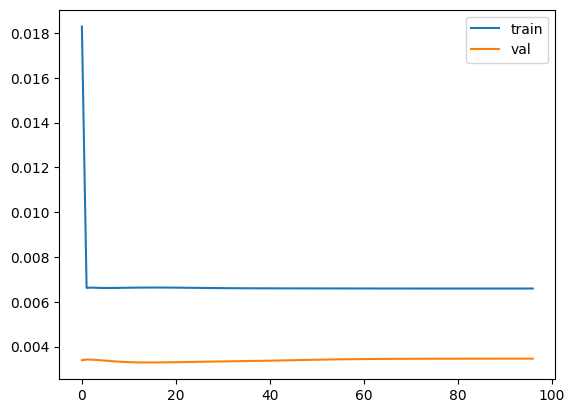

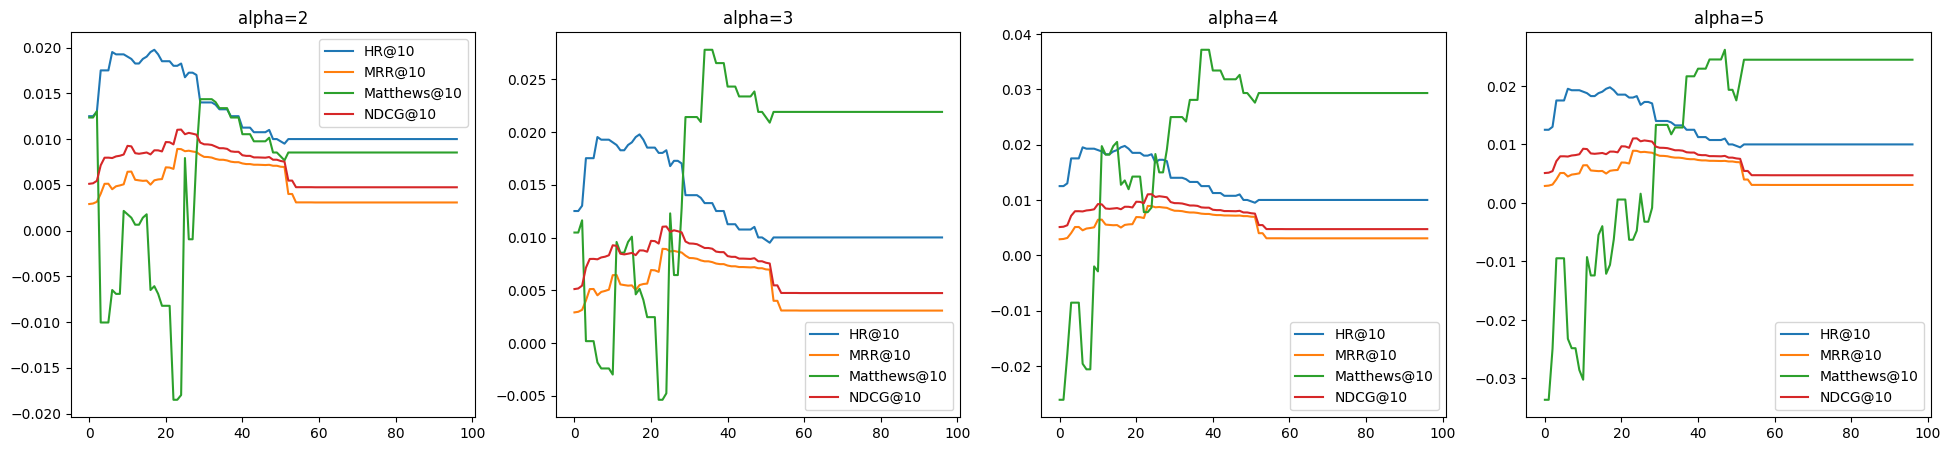

Test loss: 0.003396896179765463
Train loss: 0.006595566873874329


Hidden sizes: 64 3
Current epoch 91
Results for alpha=2


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.011498  0.009323    0.000808  0.009851  0.010951  0.000548   0.008922   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.000402    0.009415    0.000436    0.001965

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.015514  0.009841     0.001413  0.011132   0.014784    0.00073   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.009421     0.00042     0.010643     0.000488     0.002605

HR@20   MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  MRR_pos@20  \
20  0.03194  0.01107     0.002625  0.015395   0.030663   0.001278    0.010612   

    MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.000459     0.014767     0.000628     0.009563

Results for alpha=3


HR@5     MRR@5  Coverage@5   NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.010038  0.008888    0.000808  0.00917  0.008943  0.001095   0.007915   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.000973    0.008166    0.001004   -0.003558

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.015331  0.009522     0.001413  0.010807   0.013689   0.001643   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.008487    0.001035     0.009638     0.001169    -0.003594

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.030297  0.010397     0.002625  0.014384   0.028107    0.00219   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.009327     0.00107      0.01308     0.001304     0.015578

Results for alpha=4


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.009856  0.008825    0.000808  0.009075  0.008578  0.001278   0.007815   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5    0.00101    0.008001    0.001074     0.01893

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.013324  0.009259     0.001413  0.010168   0.011316   0.002008   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.008162    0.001097     0.008867       0.0013     0.016003

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.020989  0.009798     0.002625  0.012114   0.018069    0.00292   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.008649     0.00115     0.010597     0.001518     0.024345

Results for alpha=5


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.009856  0.008843    0.000707  0.009091  0.008213  0.001643   0.007459   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.001384    0.007644    0.001447    0.046594

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.011863  0.009093     0.001312  0.009722   0.009491   0.002373   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.007622    0.001471     0.008049     0.001674       0.0437

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.020807  0.009695     0.002423  0.011961   0.016244   0.004563   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.008068    0.001627      0.00973     0.002231     0.052382

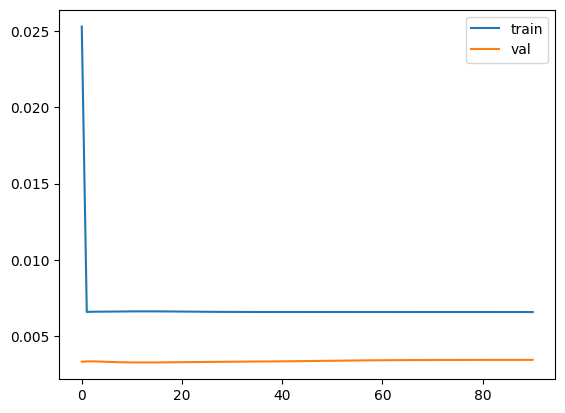

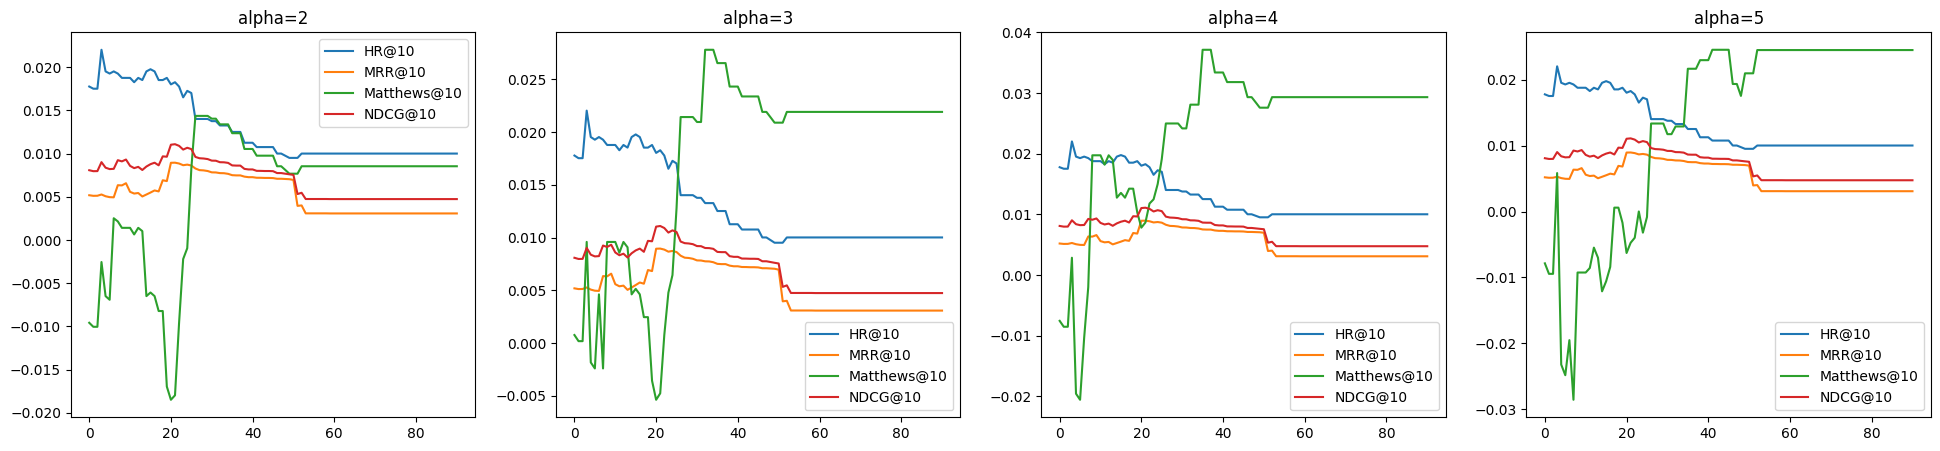

Test loss: 0.003363636089488864
Train loss: 0.006593187800738712


Hidden sizes: 64 4
Current epoch 92
Results for alpha=2


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.011498  0.009323    0.000808  0.009851  0.010951  0.000548   0.008922   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.000402    0.009415    0.000436    0.001965

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.015514  0.009841     0.001413  0.011132   0.014784    0.00073   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.009421     0.00042     0.010643     0.000488     0.002605

HR@20    MRR@20  Coverage@20  NCDG@20  HR_pos@20  HR_neg@20  \
20  0.033218  0.011137     0.002625  0.01569   0.031758    0.00146   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.010669    0.000468      0.01502      0.00067     0.006445

Results for alpha=3


HR@5     MRR@5  Coverage@5   NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.010038  0.008888    0.000808  0.00917  0.008943  0.001095   0.007915   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.000973    0.008166    0.001004   -0.003558

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.015331  0.009522     0.001413  0.010807   0.013689   0.001643   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.008487    0.001035     0.009638     0.001169    -0.003594

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.030297  0.010396     0.002625  0.014383   0.028107    0.00219   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.009326     0.00107     0.013079     0.001304     0.015578

Results for alpha=4


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.009856  0.008825    0.000808  0.009075  0.008578  0.001278   0.007815   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5    0.00101    0.008001    0.001074     0.01893

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.013324  0.009259     0.001413  0.010168   0.011316   0.002008   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.008162    0.001097     0.008867       0.0013     0.016003

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.020989  0.009802     0.002625  0.012119   0.018069    0.00292   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.008652     0.00115     0.010601     0.001518     0.024345

Results for alpha=5


HR@5     MRR@5  Coverage@5   NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.009673  0.008806    0.000707  0.00902  0.008031  0.001643   0.007422   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.001384    0.007573    0.001447     0.04552

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.012046  0.009108     0.001312  0.009773   0.009491   0.002555   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.007619     0.00149     0.008046     0.001726     0.041301

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.021172  0.009706     0.002423  0.012035   0.016426   0.004745   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.008069    0.001637     0.009761     0.002274     0.051393

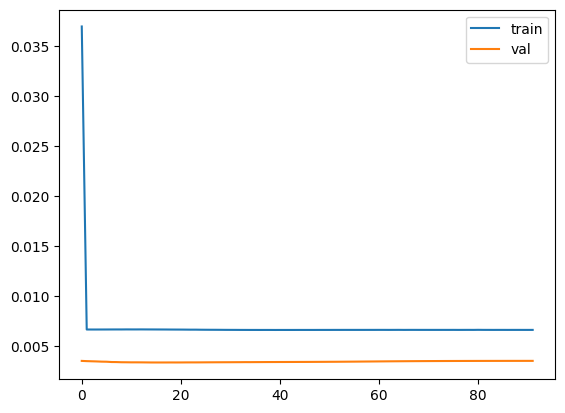

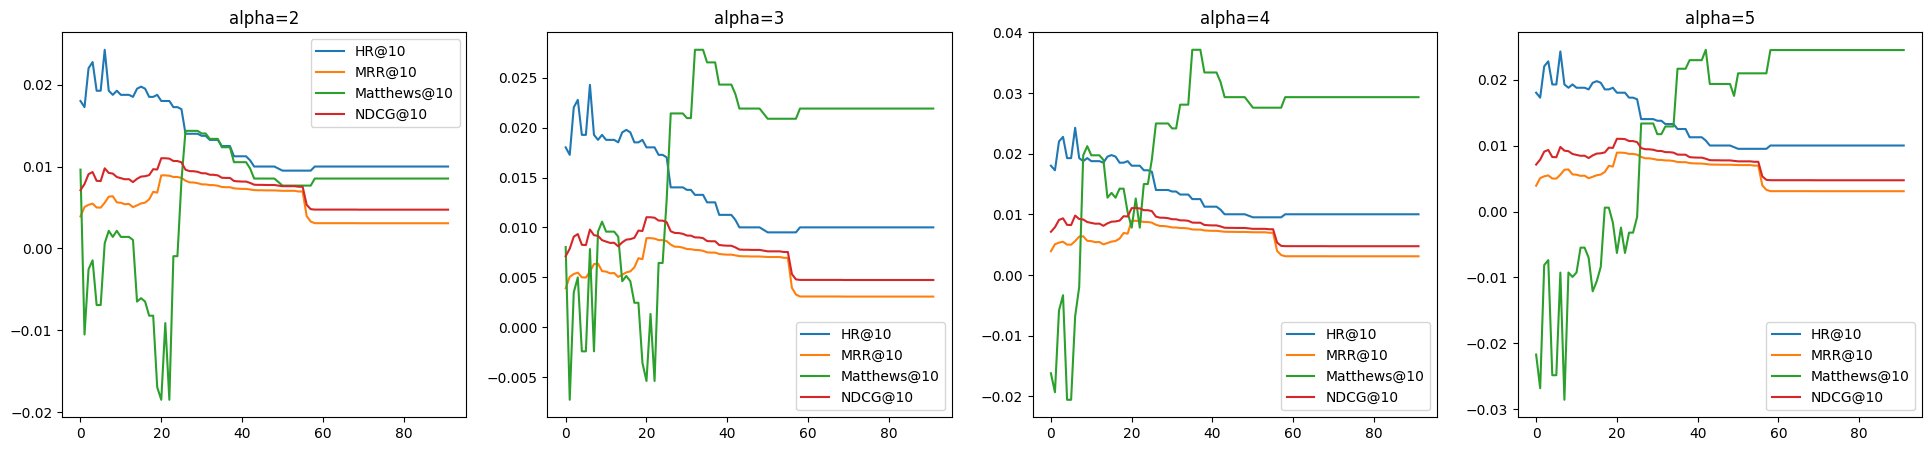

Test loss: 0.0033788420259952545
Train loss: 0.006587707031889392


Hidden sizes: 64 5
Current epoch 79
Results for alpha=2


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.011498  0.009323    0.000808  0.009851  0.010951  0.000548   0.008922   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.000402    0.009415    0.000436    0.001965

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.015514  0.009841     0.001413  0.011132   0.014784    0.00073   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.009421     0.00042     0.010643     0.000488     0.002605

HR@20   MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  MRR_pos@20  \
20  0.03194  0.01107     0.002625  0.015395   0.030663   0.001278    0.010612   

    MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.000459     0.014767     0.000628     0.009563

Results for alpha=3


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.010768  0.009034    0.000808  0.009452  0.009673  0.001095   0.008061   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.000973    0.008448    0.001004   -0.001098

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.015331  0.009583     0.001413  0.010868   0.013689   0.001643   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.008547    0.001036     0.009697      0.00117    -0.003594

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.03048  0.010496     0.002625  0.014525    0.02829    0.00219   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.009424    0.001072     0.013219     0.001306     0.015884

Results for alpha=4


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.009856  0.008852    0.000808  0.009099  0.008578  0.001278   0.007833   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.001019    0.008017    0.001082     0.01893

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.013141  0.009268     0.001413  0.010139   0.011133   0.002008   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.008162    0.001106     0.008831     0.001308     0.015295

HR@20   MRR@20  Coverage@20  NCDG@20  HR_pos@20  HR_neg@20  MRR_pos@20  \
20  0.020989  0.00981     0.002625  0.01212   0.018069    0.00292    0.008652   

    MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.001159     0.010595     0.001526     0.024345

Results for alpha=5


HR@5     MRR@5  Coverage@5   NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.009673  0.008806    0.000707  0.00902  0.008031  0.001643   0.007422   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.001384    0.007573    0.001447     0.04552

HR@10   MRR@10  Coverage@10  NCDG@10  HR_pos@10  HR_neg@10  MRR_pos@10  \
10  0.011863  0.00909     0.001312  0.00972   0.009491   0.002373    0.007619   

    MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.001471     0.008046     0.001674       0.0437

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.021354  0.009714     0.002423  0.012075   0.016791   0.004563   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.008087    0.001627     0.009844     0.002231     0.054781

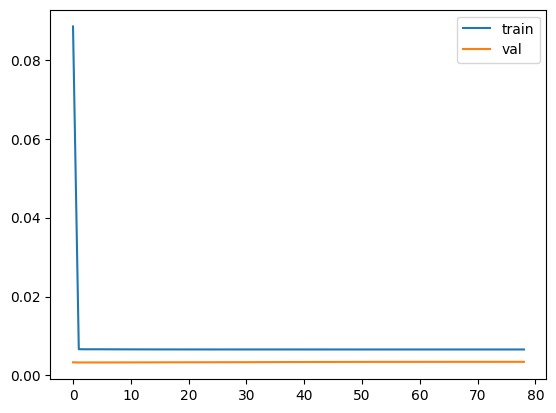

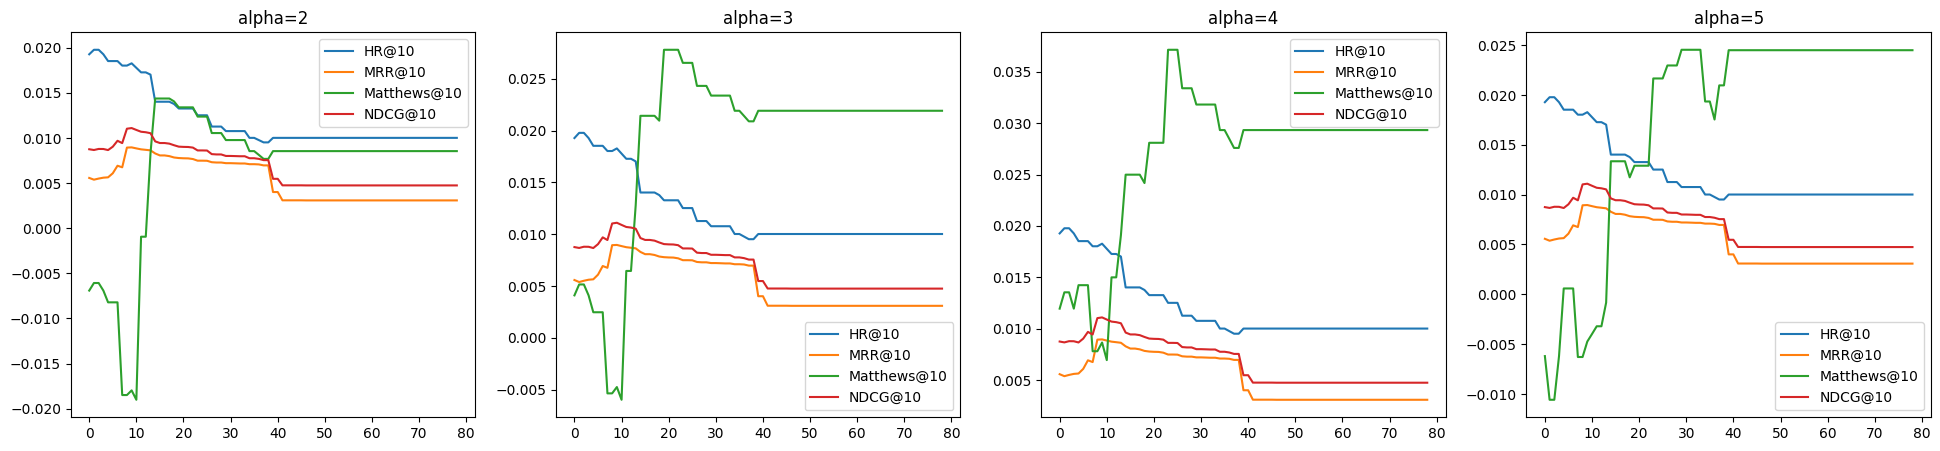

Test loss: 0.0033670098055154085
Train loss: 0.006594409749142708


Hidden sizes: 128 3
Current epoch 84
Results for alpha=2


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.011498  0.009323    0.000808  0.009851  0.010951  0.000548   0.008922   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.000402    0.009415    0.000436    0.001965

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.015514  0.009841     0.001413  0.011132   0.014784    0.00073   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.009421     0.00042     0.010643     0.000488     0.002605

HR@20    MRR@20  Coverage@20  NCDG@20  HR_pos@20  HR_neg@20  \
20  0.033218  0.011137     0.002625  0.01569   0.031758    0.00146   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.010669    0.000468      0.01502      0.00067     0.006445

Results for alpha=3


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.010768  0.009034    0.000808  0.009452  0.009673  0.001095   0.008061   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.000973    0.008448    0.001004   -0.001098

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.015331  0.009583     0.001413  0.010868   0.013689   0.001643   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.008547    0.001036     0.009697      0.00117    -0.003594

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.03048  0.010519     0.002625  0.014556    0.02829    0.00219   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.009447    0.001072      0.01325     0.001306     0.015884

Results for alpha=4


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.009856  0.008825    0.000808  0.009075  0.008578  0.001278   0.007815   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5    0.00101    0.008001    0.001074     0.01893

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.013324  0.009259     0.001413  0.010168   0.011316   0.002008   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.008162    0.001097     0.008867       0.0013     0.016003

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.020989  0.009803     0.002625  0.012121   0.018069    0.00292   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.008653     0.00115     0.010602     0.001519     0.024345

Results for alpha=5


HR@5     MRR@5  Coverage@5   NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.009673  0.008806    0.000707  0.00902  0.008031  0.001643   0.007422   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.001384    0.007573    0.001447     0.04552

HR@10   MRR@10  Coverage@10  NCDG@10  HR_pos@10  HR_neg@10  MRR_pos@10  \
10  0.011863  0.00909     0.001312  0.00972   0.009491   0.002373    0.007619   

    MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.001471     0.008046     0.001674       0.0437

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.021172  0.009704     0.002423  0.012033   0.016426   0.004745   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.008069    0.001636     0.009761     0.002273     0.051393

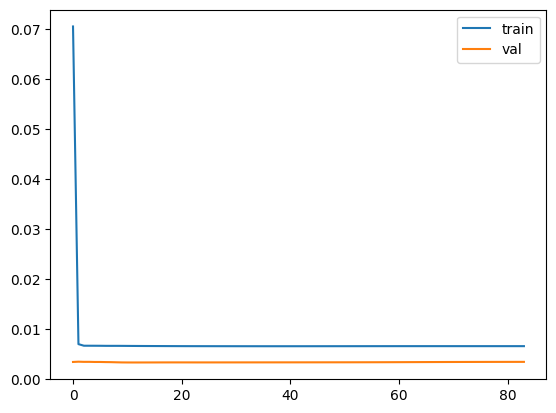

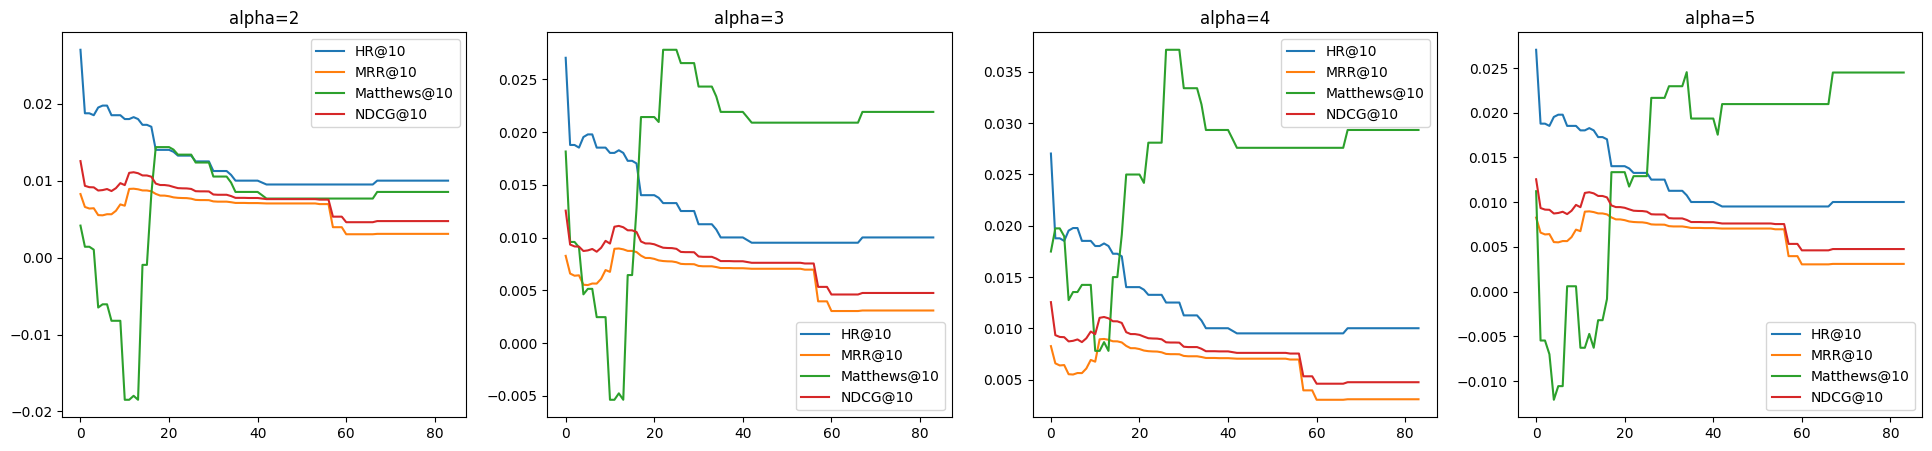

Test loss: 0.003345474135130644
Train loss: 0.006575572176554658


Hidden sizes: 128 4
Current epoch 50
Results for alpha=2


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.000365  0.000128    0.004946  0.000186  0.000365       0.0   0.000128   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5        0.0    0.000186         0.0     0.00446

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.000548  0.000065     0.008177  0.000169   0.000548        0.0   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.000065         0.0     0.000169          0.0     0.005462

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.000913  0.000091      0.01383  0.000256    0.00073   0.000183   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.000081     0.00001     0.000214     0.000042    -0.020258

Results for alpha=3


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.000365  0.000128    0.004946  0.000186  0.000365       0.0   0.000128   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5        0.0    0.000186         0.0    0.006319

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.000548  0.000065     0.008177  0.000169   0.000548        0.0   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.000065         0.0     0.000169          0.0     0.007739

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.000913  0.000091      0.01383  0.000256    0.00073   0.000183   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.000081     0.00001     0.000214     0.000042    -0.010286

Results for alpha=4


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.000365  0.000128    0.004946  0.000186  0.000183  0.000183   0.000091   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.000037    0.000115    0.000071   -0.013861

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.000548  0.000065     0.008177  0.000169   0.000365   0.000183   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.000046    0.000018     0.000116     0.000053    -0.007339

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.000913  0.000091      0.01383  0.000256   0.000548   0.000365   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.000072    0.000019     0.000172     0.000084    -0.014455

Results for alpha=5


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.000365  0.000128    0.004946  0.000186  0.000183  0.000183   0.000091   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.000037    0.000115    0.000071   -0.004106

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.000548  0.000065     0.008177  0.000169   0.000365   0.000183   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.000046    0.000018     0.000116     0.000053     0.002951

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.000913  0.000091      0.01383  0.000256   0.000548   0.000365   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.000072    0.000019     0.000172     0.000084    -0.000311

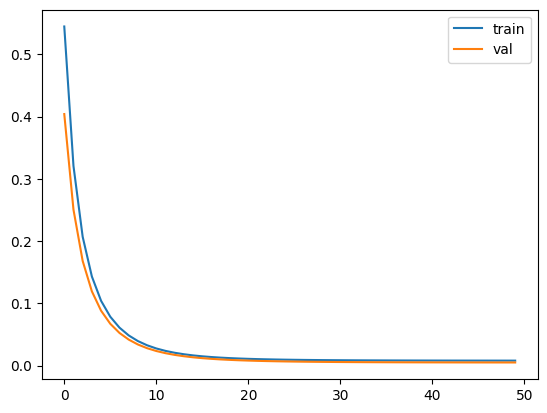

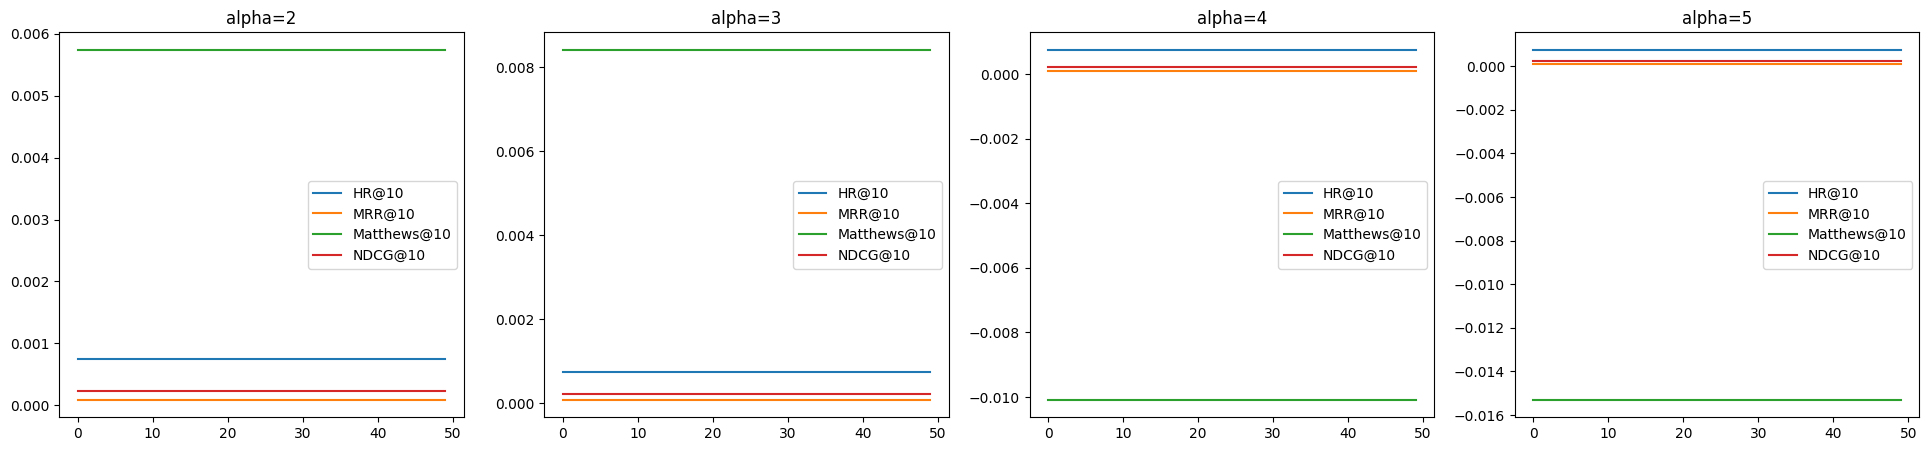

Test loss: 0.4039715826511383
Train loss: 0.5446095315248389


Hidden sizes: 128 5
Current epoch 93
Results for alpha=2


HR@5     MRR@5  Coverage@5   NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.011316  0.009287    0.000808  0.00978  0.010951  0.000365   0.008922   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.000365    0.009415    0.000365    0.009375

HR@10    MRR@10  Coverage@10  NCDG@10  HR_pos@10  HR_neg@10  \
10  0.015514  0.009892     0.001413  0.01118   0.014784    0.00073   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.009478    0.000414     0.010698     0.000483     0.002605

HR@20   MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  MRR_pos@20  \
20  0.03194  0.01112     0.002625  0.015443   0.030663   0.001278    0.010668   

    MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.000453     0.014821     0.000623     0.009563

Results for alpha=3


HR@5    MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.005293  0.00264    0.000707  0.003288  0.004198  0.001095   0.002065   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.000575    0.002588      0.0007   -0.026514

HR@10   MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.010221  0.00325     0.001312  0.004832   0.009126   0.001095   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.002675    0.000575     0.004132       0.0007    -0.002927

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.024822  0.004305     0.002423  0.008578   0.022632    0.00219   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.003641    0.000663     0.007586     0.000993     0.005525

Results for alpha=4


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.009856  0.008815    0.000808  0.009067  0.008578  0.001278   0.007806   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5    0.00101    0.007993    0.001074     0.01893

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.013324  0.009254     0.001413  0.010164   0.011316   0.002008   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.008153    0.001101     0.008859     0.001304     0.016003

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.020989  0.009796     0.002625  0.012113   0.018069    0.00292   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.008641    0.001154      0.01059     0.001522     0.024345

Results for alpha=5


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.009856  0.008843    0.000707  0.009091  0.008213  0.001643   0.007459   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.001384    0.007644    0.001447    0.046594

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.011863  0.009098     0.001312  0.009728   0.009491   0.002373   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.007622    0.001476     0.008049     0.001678       0.0437

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.021172  0.009718     0.002423  0.012049   0.016426   0.004745   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.008078     0.00164     0.009772     0.002277     0.051393

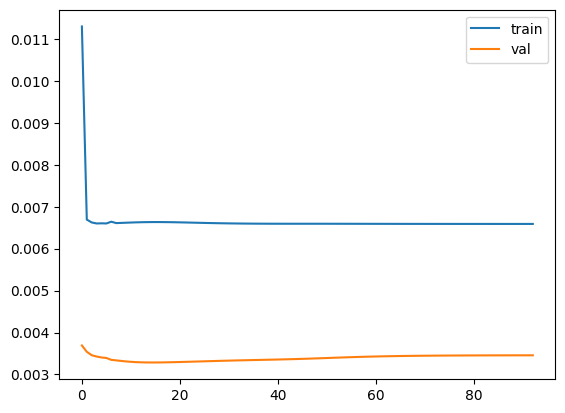

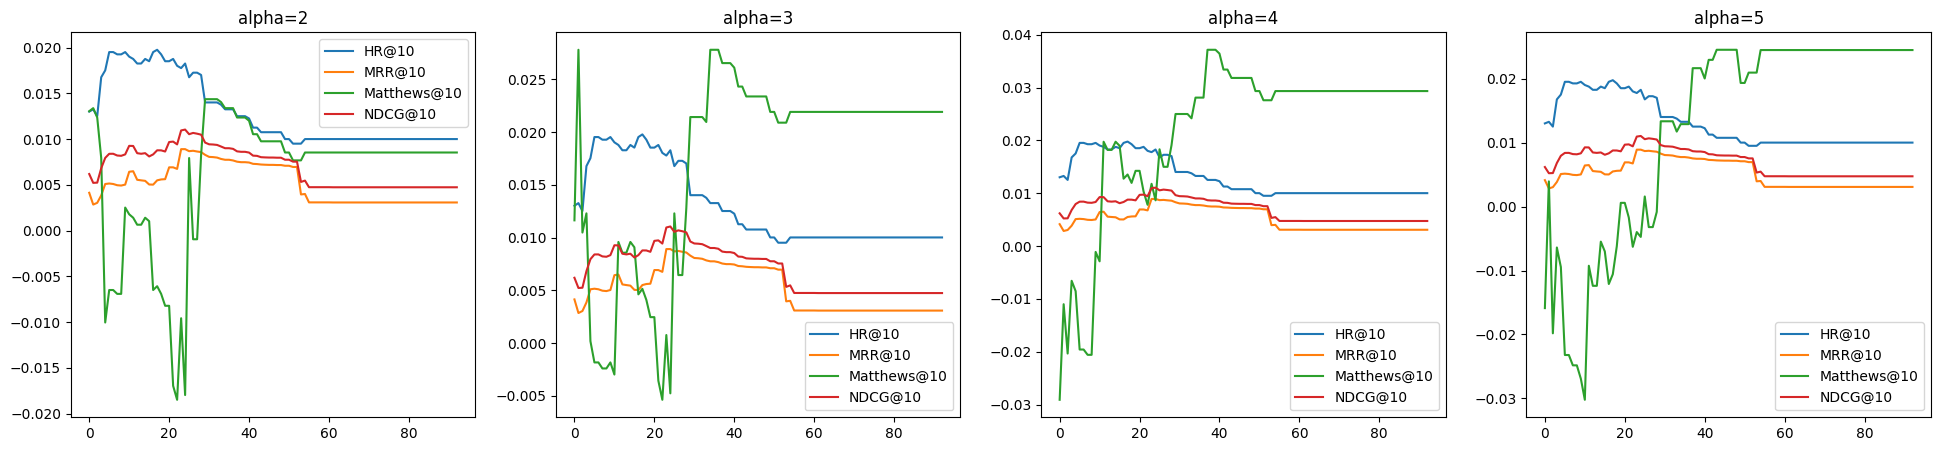

Test loss: 0.0033652109559625387
Train loss: 0.006593871921672059


Hidden sizes: 256 3


In [ ]:
params = []
histories = []
test_losses = []
early_stop = 50
n_epochs = 1000
num_batches = int(np.ceil(tensor.shape[0] / batch_size))

user_tensor_val, target_val = prepare_tensor(testset_valid, data_description)
user_tensor_test, target_test = prepare_tensor(testset, data_description)

val_num_batches = int(np.ceil(target_val.shape[0] / batch_size))
test_num_batches = int(np.ceil(target_test.shape[0] / batch_size))

for h1, h2, in tqdm(zip(grid[1].flatten(), grid[0].flatten()), total=21):
    print('Hidden sizes:', h1, h2)
    
    ae = AE(data_description['n_items'], data_description['n_ratings'], h1, h2).to(device)
    criterion = nn.BCEWithLogitsLoss().to(device)
    optimizer = optim.Adam(ae.parameters())
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
    
    mask = torch.triu(torch.ones_like(ae.L.weight)).T
#     Register with hook
    ae.L.weight.register_hook(get_zero_grad_hook(mask))
    
    params.append(sum(p.numel() for p in ae.parameters() if p.requires_grad))
    
    # Training the AE
    history = []
    val_history = []

    hrs2 = []
    mrrs2 = []
    cs2 = []
    ndcgs2 = []

    hrs3 = []
    mrrs3 = []
    cs3 = []
    ndcgs3 = []

    hrs4 = []
    mrrs4 = []
    cs4 = []
    ndcgs4 = []
    
    hrs5 = []
    mrrs5 = []
    cs5 = []
    ndcgs5 = []

    prev_matt2 = [0]
    prev_matt3 = [0]
    prev_matt4 = [0]
    prev_matt5 = [0]
    
    for epoch in range(1, n_epochs+1):
        train_loss = 0
        shuffle = np.random.choice(tensor.shape[0], size=tensor.shape[0], replace=False)
        tensor = tensor[shuffle]
        
        for batch in range(num_batches):
            optimizer.zero_grad()
            
            input_tensor = tensor[batch * batch_size: (batch+1) * batch_size].to(device)
            target = matrix[batch * batch_size: (batch+1) * batch_size].to(device)

            output = ae(input_tensor)
            target.require_grad = False # we don't use it in training

            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.data.item()

        scheduler.step()
        history.append(train_loss / num_batches)

        test_loss = 0
        scores = torch.zeros((testset_valid.userid.nunique(), data_description['n_items']))
        
        with torch.no_grad():
            for batch in range(val_num_batches):
                input_tensor = user_tensor_val[batch * batch_size: (batch+1) * batch_size].to(device)
                target = target_val[batch * batch_size: (batch+1) * batch_size].to(device)
            
                output = ae(input_tensor)
                target.require_grad = False

                test_loss += criterion(output, target)
                scores[batch * batch_size: (batch+1) * batch_size] = output
        
        scores = scores.detach().cpu().numpy()
        val_loss = test_loss / val_num_batches
        val_history.append(val_loss.item())
        
        downvote_seen_items(scores, testset_valid, data_description)
        
        prev_matt2 = predict_and_check(scores, holdout_valid, data_description, hrs2, mrrs2, cs2, ndcgs2, 2, prev_matt2, epoch)
        prev_matt3 = predict_and_check(scores, holdout_valid, data_description, hrs3, mrrs3, cs3, ndcgs3, 3, prev_matt3, epoch)
        prev_matt4 = predict_and_check(scores, holdout_valid, data_description, hrs4, mrrs4, cs4, ndcgs4, 4, prev_matt4, epoch)
        prev_matt5 = predict_and_check(scores, holdout_valid, data_description, hrs5, mrrs5, cs5, ndcgs5, 5, prev_matt5, epoch)
        
        # stop = epoch if epoch < early_stop else epoch-early_stop
        if len(prev_matt2) >= early_stop and len(prev_matt3) >= early_stop and len(prev_matt4) >= early_stop and len(prev_matt5) >= early_stop:
            print(f'Current epoch {epoch}')
            break
            
    
    # Testing the AE
    check_test(ae, criterion, user_tensor_test, target_test, testset, holdout, data_description, test_num_batches, 2, batch_size=16, dcg=True)
    check_test(ae, criterion, user_tensor_test, target_test, testset, holdout, data_description, test_num_batches, 3, batch_size=16, dcg=True)
    check_test(ae, criterion, user_tensor_test, target_test, testset, holdout, data_description, test_num_batches, 4, batch_size=16, dcg=True)
    check_test(ae, criterion, user_tensor_test, target_test, testset, holdout, data_description, test_num_batches, 5, batch_size=16, dcg=True)
    
    # our
    plt.plot(history, label='train')
    plt.plot(val_history, label='val')
    plt.legend()
    plt.show()

    hrs = [hrs2, hrs3, hrs4, hrs5]
    mrrs = [mrrs2, mrrs3, mrrs4, mrrs5]
    cs = [cs2, cs3, cs4, cs5]
    ndcgs = [ndcgs2, ndcgs3, ndcgs4, ndcgs5]

    fig = plt.figure(figsize=(24,5))
    axes = fig.subplots(nrows=1, ncols=4)
    for i in range(4):
        axes[i].set_title(f'alpha={i+2}')
        axes[i].plot(hrs[i], label='HR@10')
        axes[i].plot(mrrs[i], label='MRR@10')
        axes[i].plot(cs[i], label='Matthews@10')
        axes[i].plot(ndcgs[i], label='NDCG@10')
        axes[i].legend()
        
    plt.show()
    
    print('Test loss:', val_history[-min(early_stop, epoch)])
    print('Train loss:', history[-min(early_stop, epoch)])
    
    print()
    print()

In [ ]:
grid1 = 2**np.arange(8, 11)
grid2 = np.arange(3, 6)
grid = np.meshgrid(grid2, grid1)

  0%|          | 0/21 [00:00<?, ?it/s]

Hidden sizes: 256 3
Current epoch 83
Results for alpha=2


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.011498  0.009323    0.000808  0.009851  0.010951  0.000548   0.008922   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.000402    0.009415    0.000436    0.001965

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.015514  0.009841     0.001413  0.011132   0.014784    0.00073   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.009421     0.00042     0.010643     0.000488     0.002605

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.032305  0.011089     0.002625  0.015478   0.030845    0.00146   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.010621    0.000468     0.014809      0.00067     0.005328

Results for alpha=3


HR@5     MRR@5  Coverage@5   NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.010038  0.008888    0.000808  0.00917  0.008943  0.001095   0.007915   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.000973    0.008166    0.001004   -0.003558

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.015331  0.009522     0.001413  0.010807   0.013689   0.001643   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.008487    0.001035     0.009638     0.001169    -0.003594

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.030297  0.010397     0.002625  0.014384   0.028107    0.00219   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.009327     0.00107      0.01308     0.001304     0.015578

Results for alpha=4


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.009856  0.008852    0.000808  0.009099  0.008578  0.001278   0.007833   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.001019    0.008017    0.001082     0.01893

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.013324  0.009286     0.001413  0.010192   0.011316   0.002008   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10     0.00818    0.001106     0.008883     0.001308     0.016003

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.020989  0.009828     0.002625  0.012141   0.018069    0.00292   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.008669    0.001159     0.010615     0.001526     0.024345

Results for alpha=5


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.009856  0.008843    0.000707  0.009091  0.008213  0.001643   0.007459   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.001384    0.007644    0.001447    0.046594

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.011863  0.009098     0.001312  0.009728   0.009491   0.002373   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.007622    0.001476     0.008049     0.001678       0.0437

HR@20   MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.021354  0.00974     0.002423  0.012108   0.016791   0.004563   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.008111     0.00163     0.009874     0.002234     0.054781

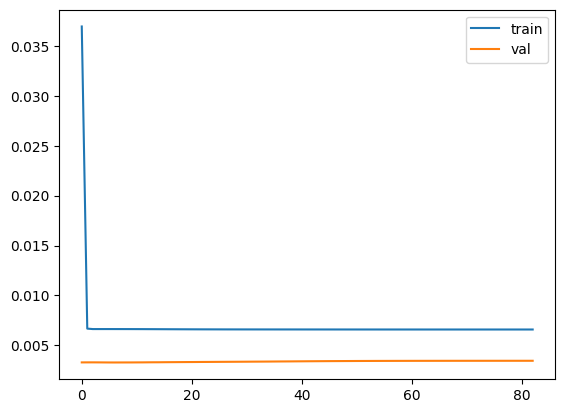

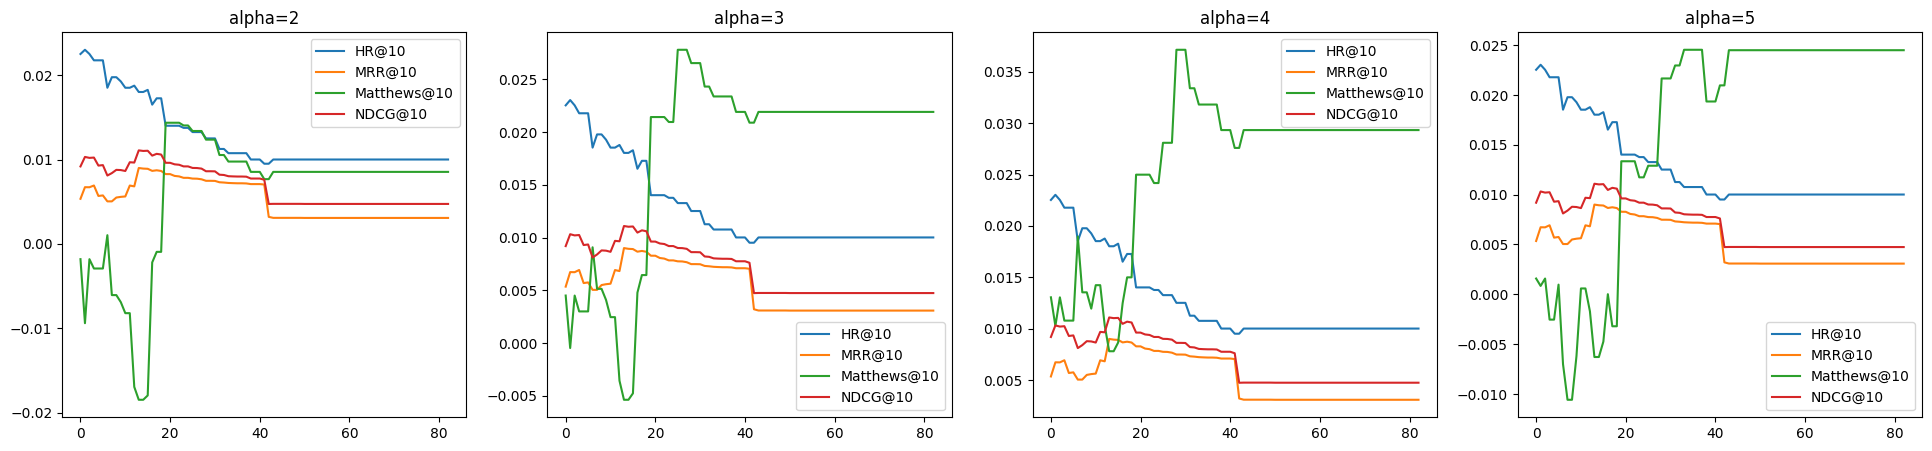

Test loss: 0.0033739209175109863
Train loss: 0.006596787100519763


Hidden sizes: 256 4
Current epoch 80
Results for alpha=2


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.00511  0.002339    0.000707  0.003026  0.004928  0.000183   0.002294   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.000046    0.002947    0.000079    0.005161

HR@10   MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.021172  0.00429     0.001413  0.008024   0.020807   0.000365   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.004226    0.000064     0.007893     0.000131     0.022866

HR@20  MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  MRR_pos@20  \
20  0.056397  0.0067     0.002726  0.016889   0.054937    0.00146    0.006559   

    MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.000142     0.016478     0.000411     0.028457

Results for alpha=3


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.010768  0.009034    0.000808  0.009452  0.009673  0.001095   0.008061   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.000973    0.008448    0.001004   -0.001098

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.015331  0.009583     0.001413  0.010868   0.013689   0.001643   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.008547    0.001036     0.009697      0.00117    -0.003594

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.03048  0.010493     0.002625  0.014521    0.02829    0.00219   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.009421    0.001073     0.013214     0.001307     0.015884

Results for alpha=4


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.009856  0.008852    0.000808  0.009099  0.008578  0.001278   0.007833   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.001019    0.008017    0.001082     0.01893

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.013141  0.009268     0.001413  0.010139   0.011133   0.002008   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.008162    0.001106     0.008831     0.001308     0.015295

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.020989  0.009812     0.002625  0.012123   0.018069    0.00292   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.008653    0.001159     0.010597     0.001526     0.024345

Results for alpha=5


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.009856  0.008843    0.000707  0.009091  0.008213  0.001643   0.007459   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.001384    0.007644    0.001447    0.046594

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.011863  0.009098     0.001312  0.009728   0.009491   0.002373   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.007622    0.001476     0.008049     0.001678       0.0437

HR@20    MRR@20  Coverage@20  NCDG@20  HR_pos@20  HR_neg@20  \
20  0.021354  0.009734     0.002423   0.0121   0.016791   0.004563   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.008104    0.001631     0.009865     0.002235     0.054781

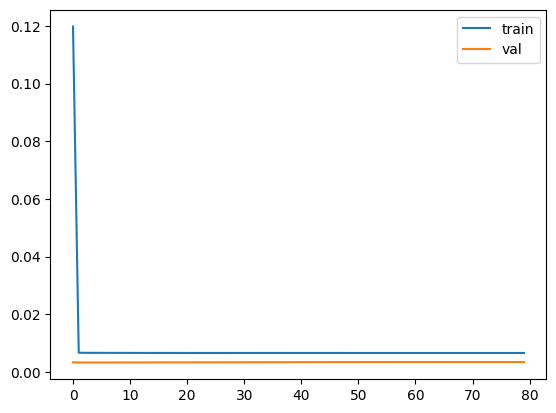

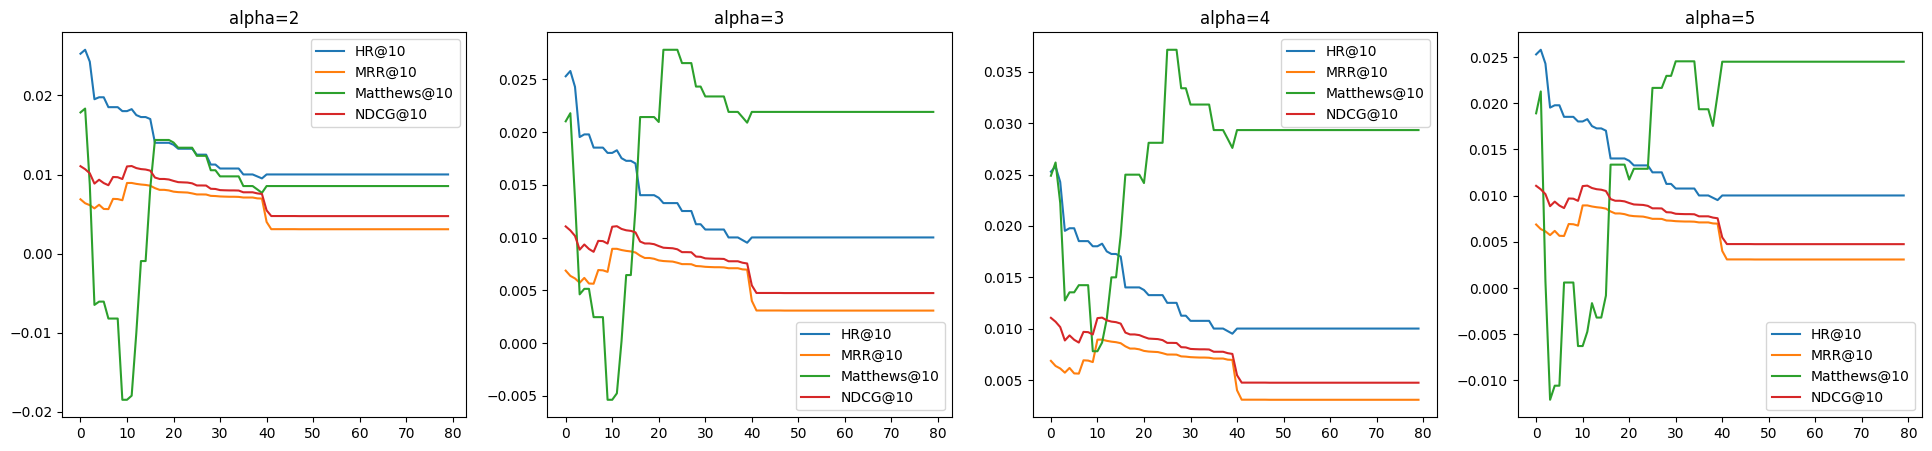

Test loss: 0.003370709717273712
Train loss: 0.00659584510790802


Hidden sizes: 256 5
Current epoch 94
Results for alpha=2


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.011498  0.009323    0.000808  0.009851  0.010951  0.000548   0.008922   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.000402    0.009415    0.000436    0.001965

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.015514  0.009841     0.001413  0.011132   0.014784    0.00073   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.009421     0.00042     0.010643     0.000488     0.002605

HR@20   MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  MRR_pos@20  \
20  0.03194  0.01107     0.002625  0.015395   0.030663   0.001278    0.010612   

    MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.000459     0.014767     0.000628     0.009563

Results for alpha=3


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.005293  0.002604    0.000707  0.003256  0.004198  0.001095    0.00202   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.000584    0.002548    0.000708   -0.026514

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.010403  0.003278     0.001312  0.004902   0.009308   0.001095   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.002694    0.000584     0.004194     0.000708    -0.002306

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.034495  0.004798     0.002423  0.010798    0.03194   0.002555   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.004109    0.000689     0.009717     0.001082     0.015526

Results for alpha=4


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.009856  0.008825    0.000808  0.009075  0.008578  0.001278   0.007815   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5    0.00101    0.008001    0.001074     0.01893

HR@10   MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.013141  0.00924     0.001413  0.010115   0.011133   0.002008   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.008143    0.001097     0.008815       0.0013     0.015295

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.020989  0.009783     0.002625  0.012096   0.018069    0.00292   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.008633     0.00115     0.010579     0.001518     0.024345

Results for alpha=5


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.009856  0.008843    0.000707  0.009091  0.008213  0.001643   0.007459   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.001384    0.007644    0.001447    0.046594

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.011863  0.009093     0.001312  0.009722   0.009491   0.002373   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.007622    0.001471     0.008049     0.001674       0.0437

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.021172  0.009713     0.002423  0.012044   0.016426   0.004745   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.008077    0.001636     0.009771     0.002273     0.051393

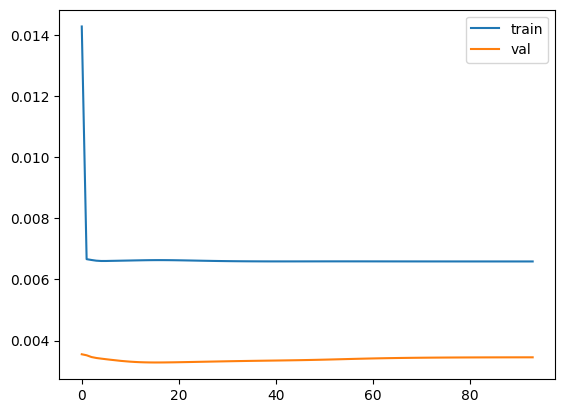

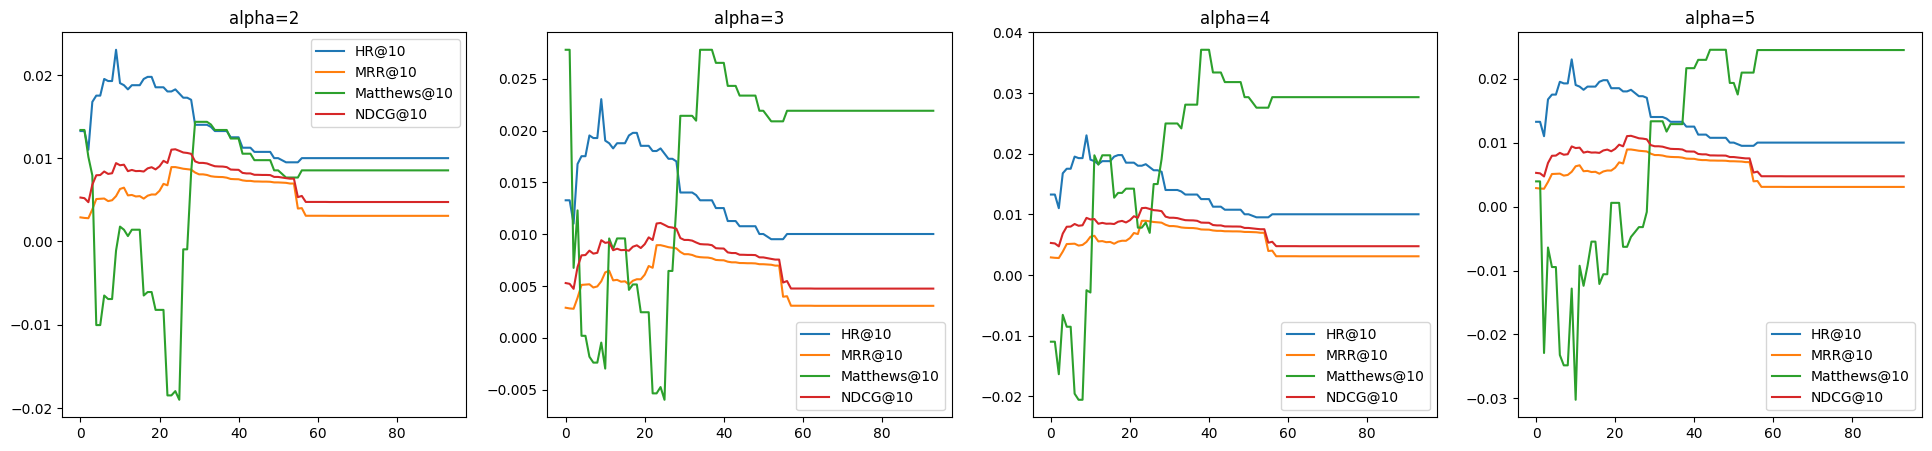

Test loss: 0.003359155496582389
Train loss: 0.006591364119500646


Hidden sizes: 512 3
Current epoch 84
Results for alpha=2


HR@5     MRR@5  Coverage@5   NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.011316  0.009287    0.000808  0.00978  0.010951  0.000365   0.008922   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.000365    0.009415    0.000365    0.009375

HR@10    MRR@10  Coverage@10  NCDG@10  HR_pos@10  HR_neg@10  \
10  0.015514  0.009892     0.001413  0.01118   0.014784    0.00073   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.009478    0.000414     0.010698     0.000483     0.002605

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.032123  0.011128     0.002625  0.015483   0.030845   0.001278   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.010676    0.000452     0.014862     0.000622     0.009778

Results for alpha=3


HR@5     MRR@5  Coverage@5   NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.010038  0.008888    0.000808  0.00917  0.008943  0.001095   0.007915   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.000973    0.008166    0.001004   -0.003558

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.015331  0.009522     0.001413  0.010807   0.013689   0.001643   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.008487    0.001035     0.009638     0.001169    -0.003594

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.030297  0.010445     0.002625  0.014449   0.028107    0.00219   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.009375     0.00107     0.013145     0.001304     0.015578

Results for alpha=4


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.009856  0.008815    0.000808  0.009067  0.008578  0.001278   0.007806   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5    0.00101    0.007993    0.001074     0.01893

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.013324  0.009254     0.001413  0.010164   0.011316   0.002008   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.008153    0.001101     0.008859     0.001304     0.016003

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.020989  0.009791     0.002625  0.012107   0.018069    0.00292   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.008638    0.001153     0.010587      0.00152     0.024345

Results for alpha=5


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.009856  0.008843    0.000707  0.009091  0.008213  0.001643   0.007459   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.001384    0.007644    0.001447    0.046594

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.011863  0.009098     0.001312  0.009728   0.009491   0.002373   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.007622    0.001476     0.008049     0.001678       0.0437

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.021172  0.009725     0.002423  0.012058   0.016426   0.004745   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.008085     0.00164     0.009782     0.002277     0.051393

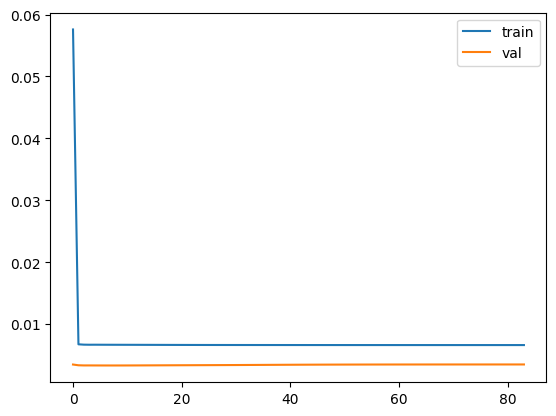

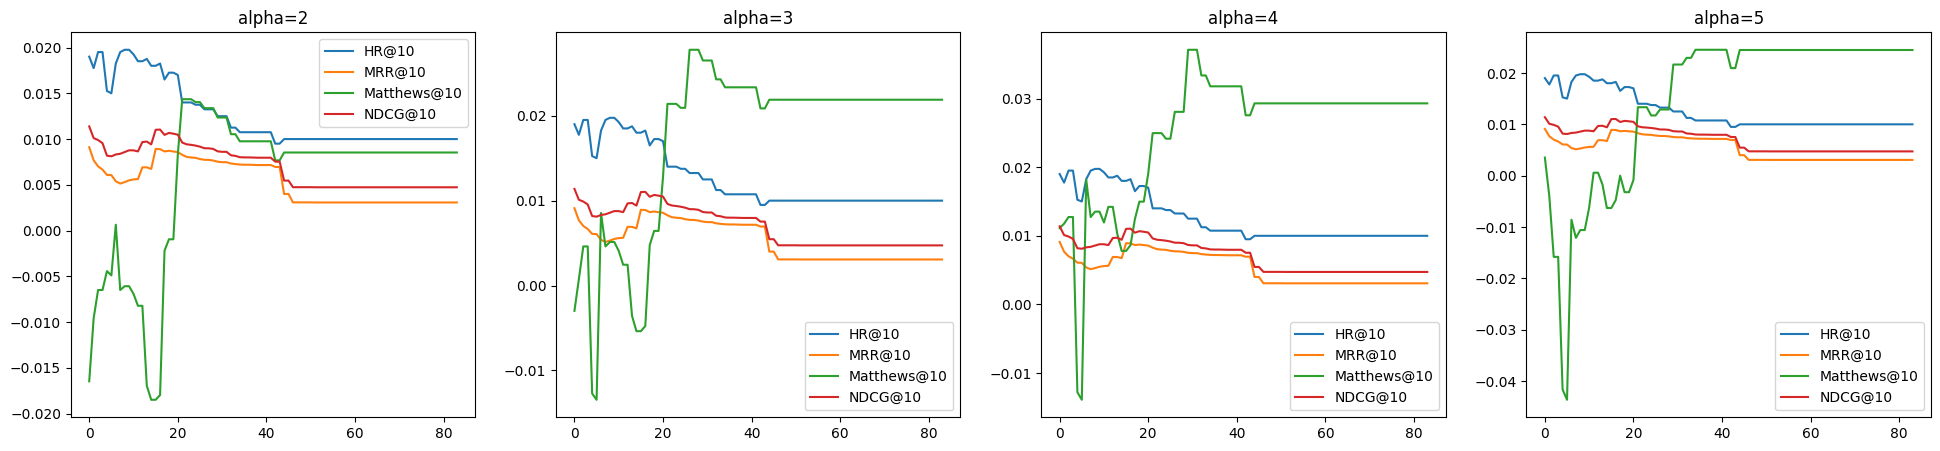

Test loss: 0.00338123575784266
Train loss: 0.006597915907613345


Hidden sizes: 512 4
Current epoch 83
Results for alpha=2


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.011498  0.009323    0.000808  0.009851  0.010951  0.000548   0.008922   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.000402    0.009415    0.000436    0.001965

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.015514  0.009841     0.001514  0.011132   0.014784    0.00073   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.009421     0.00042     0.010643     0.000488     0.002605

HR@20   MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.031758  0.01106     0.002625  0.015352    0.03048   0.001278   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20      0.0106     0.00046     0.014722     0.000629     0.009346

Results for alpha=3


HR@5     MRR@5  Coverage@5   NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.010038  0.008888    0.000808  0.00917  0.008943  0.001095   0.007915   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.000973    0.008166    0.001004   -0.003558

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.015331  0.009522     0.001413  0.010807   0.013689   0.001643   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.008487    0.001035     0.009638     0.001169    -0.003594

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.030297  0.010423     0.002625  0.014419   0.028107    0.00219   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.009351    0.001072     0.013113     0.001306     0.015578

Results for alpha=4


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.009856  0.008815    0.000808  0.009067  0.008578  0.001278   0.007806   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5    0.00101    0.007993    0.001074     0.01893

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.013324  0.009254     0.001413  0.010164   0.011316   0.002008   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.008153    0.001101     0.008859     0.001304     0.016003

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.020989  0.009799     0.002625  0.012117   0.018069    0.00292   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.008643    0.001156     0.010593     0.001524     0.024345

Results for alpha=5


HR@5     MRR@5  Coverage@5   NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.009673  0.008806    0.000808  0.00902  0.008031  0.001643   0.007422   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.001384    0.007573    0.001447     0.04552

HR@10   MRR@10  Coverage@10  NCDG@10  HR_pos@10  HR_neg@10  MRR_pos@10  \
10  0.011863  0.00909     0.001312  0.00972   0.009491   0.002373    0.007619   

    MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.001471     0.008046     0.001674       0.0437

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.021354  0.009714     0.002524  0.012075   0.016791   0.004563   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.008087    0.001627     0.009844     0.002231     0.054781

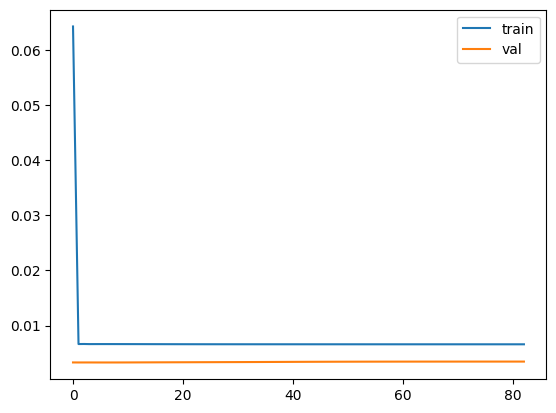

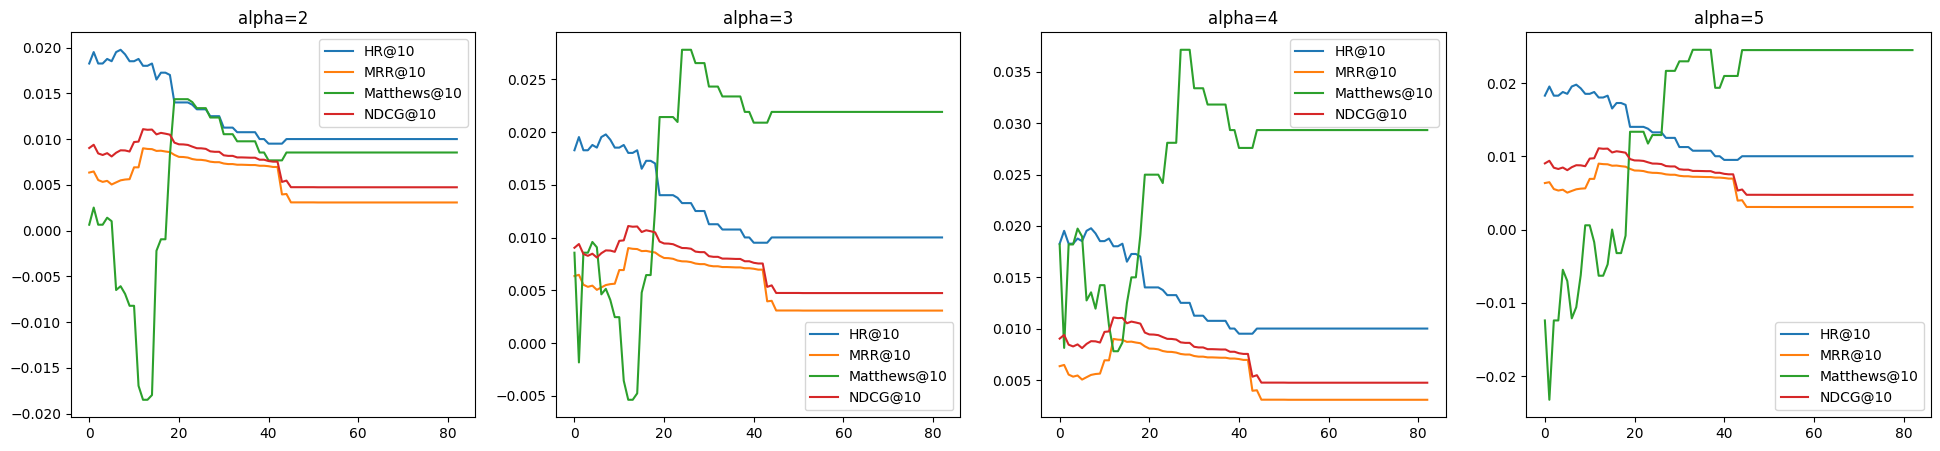

Test loss: 0.0033741090446710587
Train loss: 0.006596210047168111


Hidden sizes: 512 5
Current epoch 96
Results for alpha=2


HR@5     MRR@5  Coverage@5   NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.011316  0.009287    0.000808  0.00978  0.010951  0.000365   0.008922   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.000365    0.009415    0.000365    0.009375

HR@10    MRR@10  Coverage@10  NCDG@10  HR_pos@10  HR_neg@10  \
10  0.015514  0.009892     0.001413  0.01118   0.014784    0.00073   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.009478    0.000414     0.010698     0.000483     0.002605

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.03194  0.011121     0.002625  0.015445   0.030663   0.001278   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.010669    0.000453     0.014822     0.000623     0.009563

Results for alpha=3


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.005293  0.002604    0.000707  0.003256  0.004198  0.001095    0.00202   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.000584    0.002548    0.000708   -0.026514

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.010403  0.003289     0.001312  0.004913   0.009308   0.001095   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.002705    0.000584     0.004205     0.000708    -0.002306

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.023362  0.004211     0.002423  0.008217   0.021172    0.00219   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.003543    0.000668     0.007222     0.000995     0.002495

Results for alpha=4


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.009856  0.008852    0.000808  0.009099  0.008578  0.001278   0.007833   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.001019    0.008017    0.001082     0.01893

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.013141  0.009268     0.001413  0.010139   0.011133   0.002008   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.008162    0.001106     0.008831     0.001308     0.015295

HR@20   MRR@20  Coverage@20  NCDG@20  HR_pos@20  HR_neg@20  MRR_pos@20  \
20  0.020989  0.00981     0.002625  0.01212   0.018069    0.00292    0.008652   

    MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.001159     0.010595     0.001526     0.024345

Results for alpha=5


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.009856  0.008843    0.000707  0.009091  0.008213  0.001643   0.007459   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.001384    0.007644    0.001447    0.046594

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.011863  0.009098     0.001312  0.009728   0.009491   0.002373   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.007622    0.001476     0.008049     0.001678       0.0437

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.021172  0.009718     0.002423  0.012049   0.016426   0.004745   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.008078     0.00164     0.009772     0.002277     0.051393

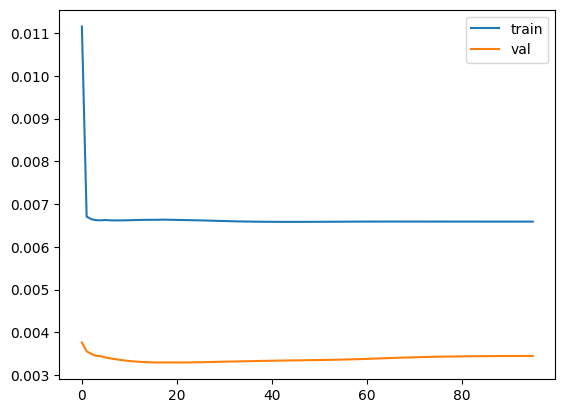

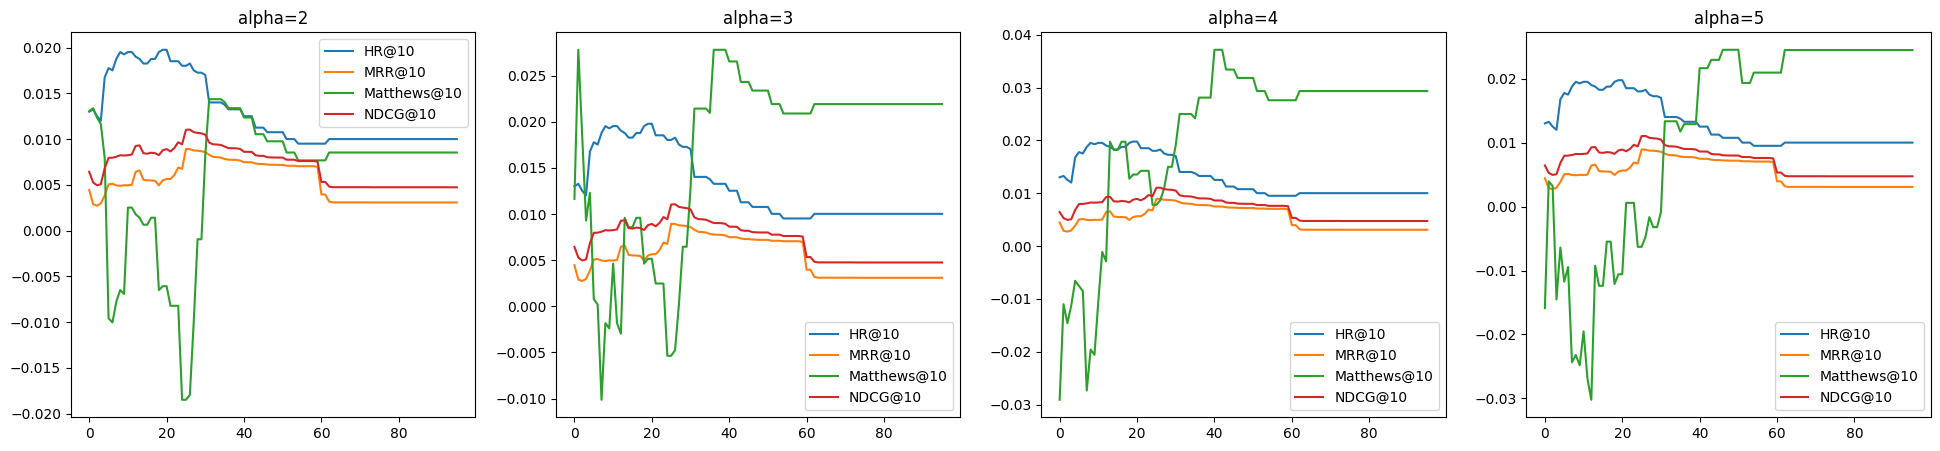

Test loss: 0.003346443409100175
Train loss: 0.006584476559046081


Hidden sizes: 1024 3
Current epoch 107
Results for alpha=2


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.00584  0.002479    0.000707  0.003298  0.005658  0.000183   0.002388   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.000091    0.003183    0.000115    0.007065

HR@10   MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.009126  0.00289     0.001211  0.004332   0.008578   0.000548   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.002737    0.000152     0.004087     0.000245     -0.00362

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.016791  0.003451     0.002322  0.006308   0.016061    0.00073   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.003289    0.000163     0.006019     0.000289     0.004826

Results for alpha=3


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.00584  0.002479    0.000707  0.003298  0.005293  0.000548   0.002236   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.000243    0.002976    0.000322    0.001236

HR@10   MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.009126  0.00289     0.001211  0.004332   0.008031   0.001095   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.002565    0.000324     0.003825     0.000507    -0.006904

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.016791  0.003451     0.002322  0.006308   0.015149   0.001643   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20     0.00309    0.000361     0.005665     0.000643     0.000321

Results for alpha=4


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.009856  0.008843    0.000808  0.009091  0.008578  0.001278   0.007824   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.001019    0.008009    0.001082     0.01893

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.013141  0.009263     0.001413  0.010135   0.011133   0.002008   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.008153     0.00111     0.008823     0.001312     0.015295

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.021537  0.009834     0.002625  0.012242   0.018252   0.003285   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.008652    0.001182     0.010629     0.001614     0.019751

Results for alpha=5


HR@5    MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.010038  0.00894    0.000707  0.009209  0.008396  0.001643   0.007526   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.001414    0.007738    0.001471    0.047652

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.011681  0.009148     0.001413  0.009729   0.009673   0.002008   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.007683    0.001465     0.008137     0.001591     0.049613

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.018434  0.009616     0.002423  0.011436   0.014236   0.004198   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.007999    0.001618      0.00929     0.002146     0.046884

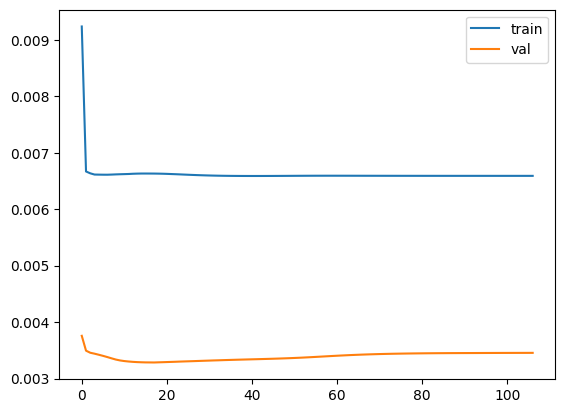

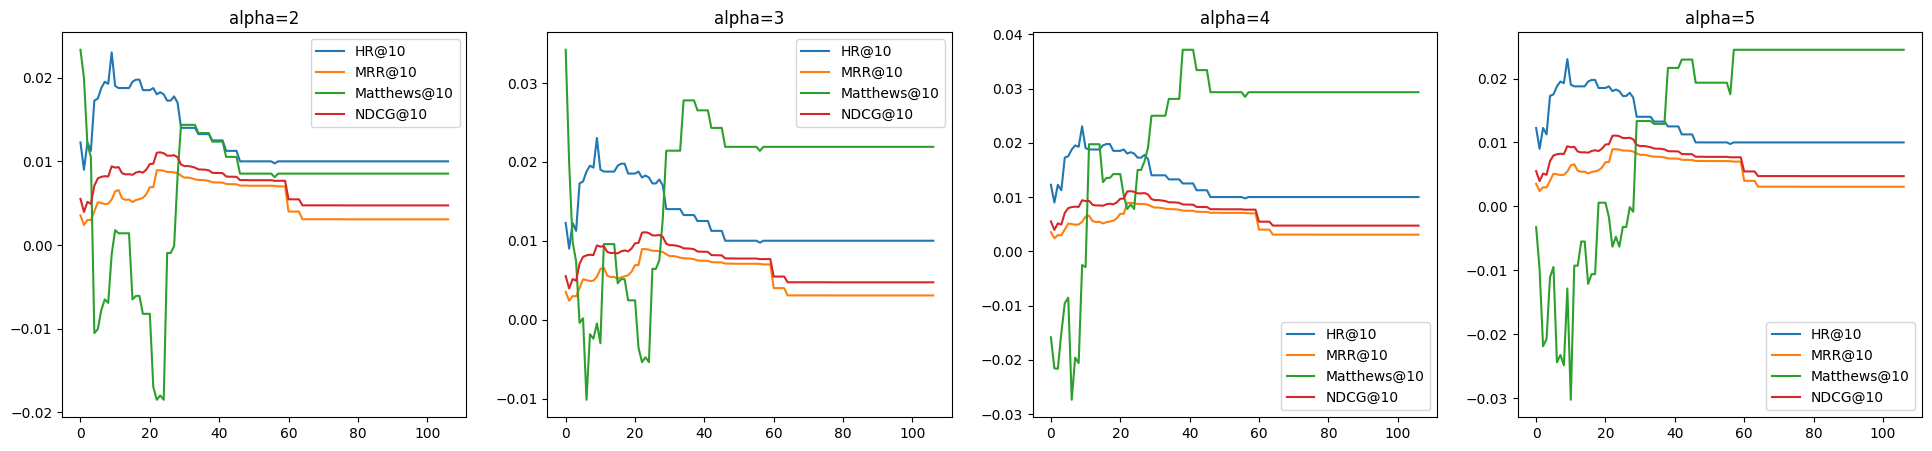

Test loss: 0.0033910011406987906
Train loss: 0.006592040942056175


Hidden sizes: 1024 4
Current epoch 82
Results for alpha=2


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.011498  0.009323    0.000808  0.009851  0.010951  0.000548   0.008922   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.000402    0.009415    0.000436    0.001965

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.015514  0.009841     0.001413  0.011132   0.014784    0.00073   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.009421     0.00042     0.010643     0.000488     0.002605

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.03194  0.011071     0.002625  0.015396   0.030663   0.001278   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.010612    0.000459     0.014768     0.000628     0.009563

Results for alpha=3


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.010951  0.009071    0.000808  0.009523  0.009856  0.001095   0.008098   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.000973    0.008519    0.001004   -0.000509

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.015331  0.009573     0.001413  0.010857   0.013689   0.001643   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10     0.00854    0.001033      0.00969     0.001167    -0.003594

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.03048  0.010486     0.002625  0.014514    0.02829    0.00219   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.009417    0.001069     0.013212     0.001303     0.015884

Results for alpha=4


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.009856  0.008852    0.000808  0.009099  0.008578  0.001278   0.007833   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.001019    0.008017    0.001082     0.01893

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.013141  0.009268     0.001413  0.010139   0.011133   0.002008   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.008162    0.001106     0.008831     0.001308     0.015295

HR@20   MRR@20  Coverage@20  NCDG@20  HR_pos@20  HR_neg@20  MRR_pos@20  \
20  0.020989  0.00981     0.002625  0.01212   0.018069    0.00292    0.008652   

    MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.001159     0.010595     0.001526     0.024345

Results for alpha=5


HR@5     MRR@5  Coverage@5   NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.009673  0.008806    0.000707  0.00902  0.008031  0.001643   0.007422   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.001384    0.007573    0.001447     0.04552

HR@10   MRR@10  Coverage@10  NCDG@10  HR_pos@10  HR_neg@10  MRR_pos@10  \
10  0.011863  0.00909     0.001312  0.00972   0.009491   0.002373    0.007619   

    MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.001471     0.008046     0.001674       0.0437

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.021354  0.009714     0.002423  0.012075   0.016791   0.004563   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.008087    0.001627     0.009844     0.002231     0.054781

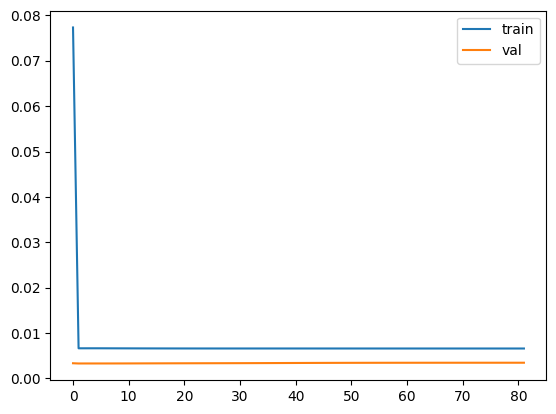

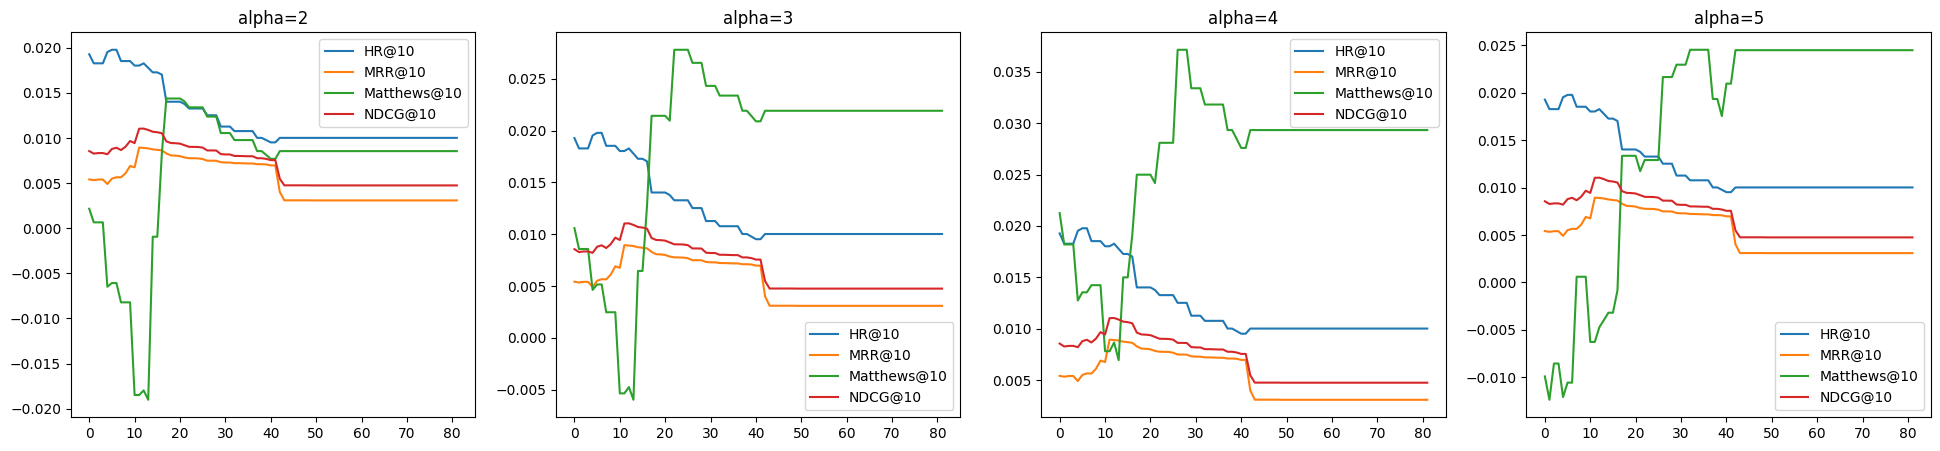

Test loss: 0.003365632612258196
Train loss: 0.006593909618169757


Hidden sizes: 1024 5


In [ ]:
params = []
histories = []
test_losses = []
early_stop = 50
n_epochs = 1000
num_batches = int(np.ceil(tensor.shape[0] / batch_size))

user_tensor_val, target_val = prepare_tensor(testset_valid, data_description)
user_tensor_test, target_test = prepare_tensor(testset, data_description)

val_num_batches = int(np.ceil(target_val.shape[0] / batch_size))
test_num_batches = int(np.ceil(target_test.shape[0] / batch_size))

for h1, h2, in tqdm(zip(grid[1].flatten(), grid[0].flatten()), total=21):
    print('Hidden sizes:', h1, h2)
    
    ae = AE(data_description['n_items'], data_description['n_ratings'], h1, h2).to(device)
    criterion = nn.BCEWithLogitsLoss().to(device)
    optimizer = optim.Adam(ae.parameters())
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
    
    mask = torch.triu(torch.ones_like(ae.L.weight)).T
#     Register with hook
    ae.L.weight.register_hook(get_zero_grad_hook(mask))
    
    params.append(sum(p.numel() for p in ae.parameters() if p.requires_grad))
    
    # Training the AE
    history = []
    val_history = []

    hrs2 = []
    mrrs2 = []
    cs2 = []
    ndcgs2 = []

    hrs3 = []
    mrrs3 = []
    cs3 = []
    ndcgs3 = []

    hrs4 = []
    mrrs4 = []
    cs4 = []
    ndcgs4 = []
    
    hrs5 = []
    mrrs5 = []
    cs5 = []
    ndcgs5 = []

    prev_matt2 = [0]
    prev_matt3 = [0]
    prev_matt4 = [0]
    prev_matt5 = [0]
    
    for epoch in range(1, n_epochs+1):
        train_loss = 0
        shuffle = np.random.choice(tensor.shape[0], size=tensor.shape[0], replace=False)
        tensor = tensor[shuffle]
        
        for batch in range(num_batches):
            optimizer.zero_grad()
            
            input_tensor = tensor[batch * batch_size: (batch+1) * batch_size].to(device)
            target = matrix[batch * batch_size: (batch+1) * batch_size].to(device)

            output = ae(input_tensor)
            target.require_grad = False # we don't use it in training

            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.data.item()

        scheduler.step()
        history.append(train_loss / num_batches)

        test_loss = 0
        scores = torch.zeros((testset_valid.userid.nunique(), data_description['n_items']))
        
        with torch.no_grad():
            for batch in range(val_num_batches):
                input_tensor = user_tensor_val[batch * batch_size: (batch+1) * batch_size].to(device)
                target = target_val[batch * batch_size: (batch+1) * batch_size].to(device)
            
                output = ae(input_tensor)
                target.require_grad = False

                test_loss += criterion(output, target)
                scores[batch * batch_size: (batch+1) * batch_size] = output
        
        scores = scores.detach().cpu().numpy()
        val_loss = test_loss / val_num_batches
        val_history.append(val_loss.item())
        
        downvote_seen_items(scores, testset_valid, data_description)
        
        prev_matt2 = predict_and_check(scores, holdout_valid, data_description, hrs2, mrrs2, cs2, ndcgs2, 2, prev_matt2, epoch)
        prev_matt3 = predict_and_check(scores, holdout_valid, data_description, hrs3, mrrs3, cs3, ndcgs3, 3, prev_matt3, epoch)
        prev_matt4 = predict_and_check(scores, holdout_valid, data_description, hrs4, mrrs4, cs4, ndcgs4, 4, prev_matt4, epoch)
        prev_matt5 = predict_and_check(scores, holdout_valid, data_description, hrs5, mrrs5, cs5, ndcgs5, 5, prev_matt5, epoch)
        
        # stop = epoch if epoch < early_stop else epoch-early_stop
        if len(prev_matt2) >= early_stop and len(prev_matt3) >= early_stop and len(prev_matt4) >= early_stop and len(prev_matt5) >= early_stop:
            print(f'Current epoch {epoch}')
            break
            
    
    # Testing the AE
    check_test(ae, criterion, user_tensor_test, target_test, testset, holdout, data_description, test_num_batches, 2, batch_size=16, dcg=True)
    check_test(ae, criterion, user_tensor_test, target_test, testset, holdout, data_description, test_num_batches, 3, batch_size=16, dcg=True)
    check_test(ae, criterion, user_tensor_test, target_test, testset, holdout, data_description, test_num_batches, 4, batch_size=16, dcg=True)
    check_test(ae, criterion, user_tensor_test, target_test, testset, holdout, data_description, test_num_batches, 5, batch_size=16, dcg=True)
    
    # our
    plt.plot(history, label='train')
    plt.plot(val_history, label='val')
    plt.legend()
    plt.show()

    hrs = [hrs2, hrs3, hrs4, hrs5]
    mrrs = [mrrs2, mrrs3, mrrs4, mrrs5]
    cs = [cs2, cs3, cs4, cs5]
    ndcgs = [ndcgs2, ndcgs3, ndcgs4, ndcgs5]

    fig = plt.figure(figsize=(24,5))
    axes = fig.subplots(nrows=1, ncols=4)
    for i in range(4):
        axes[i].set_title(f'alpha={i+2}')
        axes[i].plot(hrs[i], label='HR@10')
        axes[i].plot(mrrs[i], label='MRR@10')
        axes[i].plot(cs[i], label='Matthews@10')
        axes[i].plot(ndcgs[i], label='NDCG@10')
        axes[i].legend()
        
    plt.show()
    
    print('Test loss:', val_history[-min(early_stop, epoch)])
    print('Train loss:', history[-min(early_stop, epoch)])
    
    print()
    print()

## Model: triangular banded matrix

In [20]:
train_dataset = MVDataset(training, data_description)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)

In [21]:
len(train_dataloader)

823

In [22]:
data_description['n_items'], data_description['n_ratings']

(9906, 5)

In [23]:
# def get_zero_grad_hook(mask):
#     def hook(grad):
#         return grad * mask
#     return hook

In [24]:
class bandedLinear(nn.Module):
    def __init__(self, num_features, bias: bool = True, device=None, dtype=None):
        factory_kwargs = {'device': device, 'dtype': dtype}
        self.device = device
        super().__init__()
        self.num_features = num_features
        self.weight = nn.Parameter(torch.empty((num_features,1), **factory_kwargs))
        if bias:
            self.bias = nn.Parameter(torch.empty(num_features, **factory_kwargs))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.weight, a=np.sqrt(5))
        if self.bias is not None:
            fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / np.sqrt(fan_in) if fan_in > 0 else 0
            nn.init.uniform_(self.bias, -bound, bound)

    def forward(self, input):
        M = torch.zeros((self.num_features, self.num_features), device=self.weight.device)
        for i in range(self.num_features):
            d = torch.ones(self.num_features-i, device=self.weight.device) * self.weight[i]
            M = M + torch.diag(d, diagonal=-i)
        return F.linear(input, M, self.bias)

    def extra_repr(self):
        return 'num_features={}, bias={}'.format(
            self.num_features, self.bias is not None
        )

In [39]:
class AE(nn.Module):
    def __init__(self, n_items, n_ratings, hid1, hid2):
        super(AE, self).__init__()
        self.V = nn.Linear(n_items, hid1)
        torch.nn.init.xavier_uniform_(self.V.weight)
        self.W = nn.Linear(n_ratings, hid2)
        torch.nn.init.xavier_uniform_(self.W.weight)
        self.L = bandedLinear(n_ratings, bias=False)
        torch.nn.init.xavier_uniform_(self.L.weight)
        self.norm = nn.LayerNorm(n_ratings)
        self.vec = nn.Linear(n_ratings, 1)
        torch.nn.init.xavier_uniform_(self.vec.weight)
        
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        
    def forward(self, x):
        M = torch.zeros((self.L.weight.shape[0], self.L.weight.shape[0]), device=self.L.weight.device)
        for i in range(self.L.weight.shape[0]):
            d = torch.ones(self.L.weight.shape[0]-i, device=self.L.weight.device) * self.L.weight[i]
            M = M + torch.diag(d, diagonal=-i)

        # encode
        x = torch.matmul(x, M.T)
#         x = self.norm(x)
        x = self.relu(x)
        x = self.W(x)
        x = self.relu(x)
        xT = torch.transpose(x, -1, -2)
        yT = self.V(xT)
        y = torch.transpose(yT, -1, -2)
        y = self.relu(y)
        # decode
        output = torch.matmul(y, self.W.weight)
        output = self.relu(output)            
        output = torch.matmul(output, M)
#         output = self.norm(output)
        output = self.relu(output)
        outputT = torch.transpose(output, -1, -2)
        outputT = torch.matmul(outputT, self.V.weight)
        output = torch.transpose(outputT, -1, -2)
#         output = self.relu(output)
        # vec
        output = self.vec(output).squeeze(-1)
        return output

In [26]:
fix_torch_seed(42)
set_random_seed(42)

ae = AE(data_description['n_items'], data_description['n_ratings'], 256, 3).to(device)
criterion = nn.BCEWithLogitsLoss().to(device)
optimizer = optim.Adam(ae.parameters())
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

In [27]:
M = torch.zeros((data_description['n_ratings'], data_description['n_ratings']), device=ae.L.weight.device)
for i in range(data_description['n_ratings']):
    d = torch.ones(data_description['n_ratings']-i, device=ae.L.weight.device) * ae.L.weight[i]
    M = M + torch.diag(d, diagonal=-i)
M

tensor([[-0.8092,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.3950, -0.8092,  0.0000,  0.0000,  0.0000],
        [-0.4151,  0.3950, -0.8092,  0.0000,  0.0000],
        [-0.3274, -0.4151,  0.3950, -0.8092,  0.0000],
        [-0.4320, -0.3274, -0.4151,  0.3950, -0.8092]], device='cuda:0',
       grad_fn=<AddBackward0>)

In [28]:
M @ M.T

tensor([[ 0.6548, -0.3196,  0.3359,  0.2650,  0.3496],
        [-0.3196,  0.8108, -0.4835,  0.2066,  0.0943],
        [ 0.3359, -0.4835,  0.9831, -0.3476,  0.3859],
        [ 0.2650,  0.2066, -0.3476,  1.0903, -0.2062],
        [ 0.3496,  0.0943,  0.3859, -0.2062,  1.2769]], device='cuda:0',
       grad_fn=<MmBackward0>)

In [ ]:
# mask = torch.triu(torch.ones_like(ae.L.weight))
# # Register with hook
# ae.L.weight.register_hook(get_zero_grad_hook(mask))

In [ ]:
sum(p.numel() for p in ae.parameters() if p.requires_grad)

2536231

Epoch 3


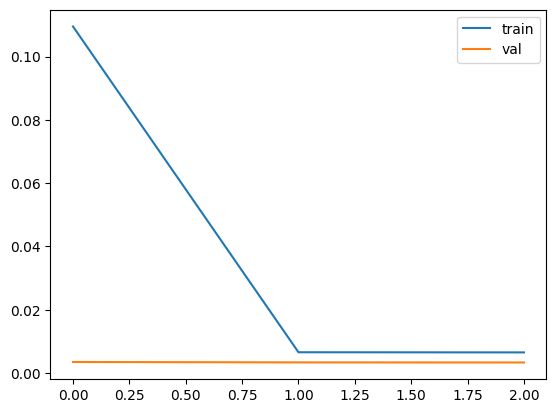

In [ ]:
# Training the AE
history = []
val_history = []

prev_train_loss = 1
prev_test_loss = 1
train_loss = 0.1 * len(train_dataloader)
test_loss = 0.1 * testset_valid.userid.nunique()
epoch = 1
best_valid_loss = float('inf')

while prev_test_loss - test_loss / testset_valid.userid.nunique() > 1e-4 or test_loss / testset_valid.userid.nunique() > 0.13:
    if epoch > 1:
        prev_train_loss = train_loss / len(train_dataloader)
        prev_test_loss = test_loss / testset_valid.userid.nunique()
    train_loss = 0
    for batch in train_dataloader:
        optimizer.zero_grad()
        
        user_tensor, user_matrix = batch
        
        input_tensor = user_tensor.to_dense().to(device)
        target = user_matrix.to_dense().to(device)
        
        output = ae(input_tensor)
        target.require_grad = False # we don't use it in training

        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.data.item()
    
    scheduler.step()
    history.append(train_loss / len(train_dataloader))
    
    test_loss = 0
    with torch.no_grad():
        for user in testset_valid.userid.unique():
            itemidx = testset_valid.loc[testset_valid.userid == user, data_description['items']].values
            feedbackidx = testset_valid.loc[testset_valid.userid == user, data_description['feedback']].values
            values = np.ones(len(itemidx), dtype=np.float32)

            user_tensor_test = torch.sparse_coo_tensor(np.array([itemidx, feedbackidx-1]), torch.tensor(values),
                                      size=torch.Size((data_description["n_items"], data_description['n_ratings']))).to_dense().to(device).unsqueeze(0)
            target = torch.sparse_coo_tensor(np.array([itemidx]), torch.tensor(values),
                                      size=torch.Size((data_description["n_items"], ))).to_dense().to(device).unsqueeze(0)

            output = ae(user_tensor_test)
            target.require_grad = False

            loss = criterion(output, target)
            test_loss += loss.data.item()
    
    valid_loss = test_loss / testset_valid.userid.nunique()
    val_history.append(valid_loss)
#         print('test loss: '+str(test_loss / testset.userid.nunique()))
    
    if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(ae.state_dict(), 'best-model.pt')
    
    clear_output()
    print('Epoch', epoch)
    plt.plot(history, label='train')
    plt.plot(val_history, label='val')
    plt.legend()
    plt.show()
    epoch += 1
#     print('epoch: '+str(epoch)+' loss: '+str(train_loss / len(train_dataloader)))

In [ ]:
M = torch.zeros((data_description['n_ratings'], data_description['n_ratings']), device=ae.L.weight.device)
for i in range(data_description['n_ratings']):
    d = torch.ones(data_description['n_ratings']-i, device=ae.L.weight.device) * ae.L.weight[i]
    M = M + torch.diag(d, diagonal=-i)
M

tensor([[-0.7077,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.6534, -0.7077,  0.0000,  0.0000,  0.0000],
        [-0.4972,  0.6534, -0.7077,  0.0000,  0.0000],
        [-0.3763, -0.4972,  0.6534, -0.7077,  0.0000],
        [-0.5481, -0.3763, -0.4972,  0.6534, -0.7077]], device='cuda:0',
       grad_fn=<AddBackward0>)

In [ ]:
M @ M.T

tensor([[ 0.5008, -0.4624,  0.3519,  0.2663,  0.3879],
        [-0.4624,  0.9277, -0.7873,  0.1060, -0.0918],
        [ 0.3519, -0.7873,  1.1750, -0.6002,  0.3785],
        [ 0.2663,  0.1060, -0.6002,  1.3166, -0.3939],
        [ 0.3879, -0.0918,  0.3785, -0.3939,  1.6170]], device='cuda:0',
       grad_fn=<MmBackward0>)

In [ ]:
# Testing the AE
test_loss = 0
# model = AE(data_description['n_items'], data_description['n_ratings'], 256, 3).to(device)
# model.load_state_dict(torch.load('best-model.pt'))

scores = torch.zeros((len(testset.userid.unique()), data_description['n_items']))

for user in testset.userid.unique():
    itemidx = testset.loc[testset.userid == user, data_description['items']].values
    feedbackidx = testset.loc[testset.userid == user, data_description['feedback']].values
    values = np.ones(len(itemidx), dtype=np.float32)

    user_tensor_test = torch.sparse_coo_tensor(np.array([itemidx, feedbackidx-1]), torch.tensor(values),
                              size=torch.Size((data_description["n_items"], data_description['n_ratings']))).to_dense().to(device).unsqueeze(0)
    target = torch.sparse_coo_tensor(np.array([itemidx]), torch.tensor(values),
                              size=torch.Size((data_description["n_items"], ))).to_dense().to(device).unsqueeze(0)
    
    output = ae(user_tensor_test)
    target.require_grad = False
    scores[i] = output[0].T

    loss = criterion(output, target)
    test_loss += loss.data.item()

scores = scores.detach().numpy()    
print('test loss: '+str(test_loss / testset.userid.nunique()))

C:\Users\Liza\AppData\Local\Temp\ipykernel_9448\3144881825.py:20: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3575.)
  scores[i] = output[0].T


OutOfMemoryError: CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 4.00 GiB total capacity; 3.00 GiB already allocated; 0 bytes free; 3.46 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
# our
downvote_seen_items(scores, testset, data_description)
make_prediction(scores, holdout, data_description)

HR@5 = 0.0092, MRR@5 = 0.0058, Coverage@5 = 0.0203
HR_pos@5 = 0.0081, HR_neg@5 = 0.0012
MRR_pos@5 = 0.0054, MRR_neg@5 = 0.0004
Matthews@5 = 0.0137
-------------------------------------
HR@10 = 0.0190, MRR@10 = 0.0070, Coverage@10 = 0.0317
HR_pos@10 = 0.0178, HR_neg@10 = 0.0012
MRR_pos@10 = 0.0066, MRR_neg@10 = 0.0004
Matthews@10 = 0.0431
-------------------------------------
HR@20 = 0.0409, MRR@20 = 0.0085, Coverage@20 = 0.0529
HR_pos@20 = 0.0380, HR_neg@20 = 0.0029
MRR_pos@20 = 0.0080, MRR_neg@20 = 0.0005
Matthews@20 = 0.0587
-------------------------------------


(0.007043536632144227, 0.0189873417721519, 0.04310505000932261)

### Tuning

In [33]:
grid1 = 2**np.arange(4, 11)
grid2 = np.arange(3, 6)
grid = np.meshgrid(grid2, grid1)

  0%|          | 0/21 [00:00<?, ?it/s]

Hidden sizes: 16 3
Current epoch 92
Results for alpha=2


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.011498  0.009323    0.000808  0.009851  0.010951  0.000548   0.008922   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.000402    0.009415    0.000436    0.001965

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.015514  0.009841     0.001413  0.011132   0.014784    0.00073   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.009421     0.00042     0.010643     0.000488     0.002605

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.033218  0.011142     0.002625  0.015696   0.031758    0.00146   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.010673    0.000468     0.015026      0.00067     0.006445

Results for alpha=3


HR@5     MRR@5  Coverage@5   NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.010038  0.008888    0.000808  0.00917  0.008943  0.001095   0.007915   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.000973    0.008166    0.001004   -0.003558

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.015331  0.009522     0.001413  0.010807   0.013689   0.001643   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.008487    0.001035     0.009638     0.001169    -0.003594

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.030297  0.010397     0.002625  0.014384   0.028107    0.00219   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.009327     0.00107      0.01308     0.001304     0.015578

Results for alpha=4


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.009856  0.008815    0.000808  0.009067  0.008578  0.001278   0.007806   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5    0.00101    0.007993    0.001074     0.01893

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.013324  0.009254     0.001413  0.010164   0.011316   0.002008   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.008153    0.001101     0.008859     0.001304     0.016003

HR@20    MRR@20  Coverage@20  NCDG@20  HR_pos@20  HR_neg@20  \
20  0.020989  0.009794     0.002625  0.01211   0.018069    0.00292   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20     0.00864    0.001154     0.010589     0.001522     0.024345

Results for alpha=5


HR@5     MRR@5  Coverage@5   NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.009673  0.008806    0.000707  0.00902  0.008031  0.001643   0.007422   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.001384    0.007573    0.001447     0.04552

HR@10   MRR@10  Coverage@10  NCDG@10  HR_pos@10  HR_neg@10  MRR_pos@10  \
10  0.011863  0.00909     0.001312  0.00972   0.009491   0.002373    0.007619   

    MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.001471     0.008046     0.001674       0.0437

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.021354  0.009714     0.002423  0.012075   0.016791   0.004563   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.008087    0.001627     0.009844     0.002231     0.054781

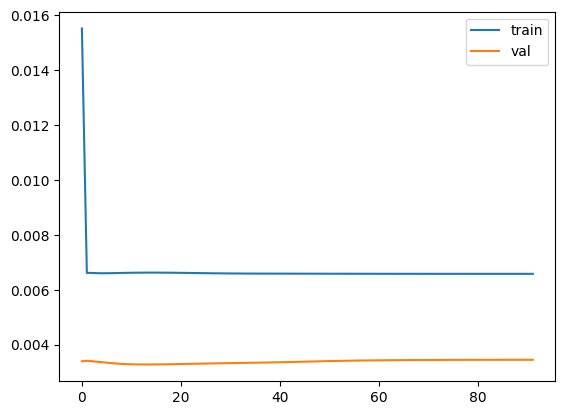

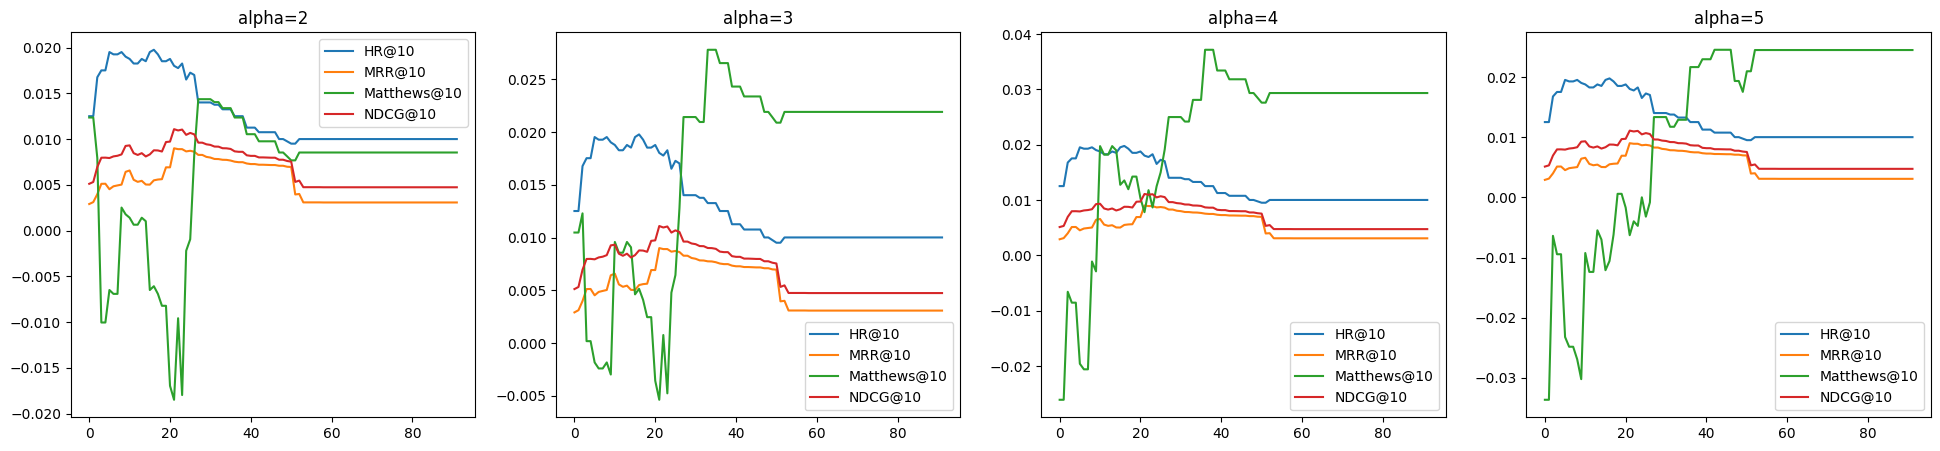

Test loss: 0.0033776615746319294
Train loss: 0.006596148821478879


Hidden sizes: 16 4
Current epoch 50
Results for alpha=2


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.000365  0.000128    0.002928  0.000186  0.000365       0.0   0.000128   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5        0.0    0.000186         0.0     0.00446

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.000548  0.000065     0.004139  0.000169   0.000548        0.0   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.000065         0.0     0.000169          0.0     0.005462

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.000913  0.000091     0.005855  0.000256    0.00073   0.000183   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.000081     0.00001     0.000214     0.000042    -0.020258

Results for alpha=3


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.000365  0.000128    0.002928  0.000186  0.000365       0.0   0.000128   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5        0.0    0.000186         0.0    0.006319

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.000548  0.000065     0.004139  0.000169   0.000548        0.0   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.000065         0.0     0.000169          0.0     0.007739

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.000913  0.000091     0.005855  0.000256    0.00073   0.000183   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.000081     0.00001     0.000214     0.000042    -0.010286

Results for alpha=4


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.000365  0.000128    0.002928  0.000186  0.000183  0.000183   0.000091   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.000037    0.000115    0.000071   -0.013861

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.000548  0.000065     0.004139  0.000169   0.000365   0.000183   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.000046    0.000018     0.000116     0.000053    -0.007339

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.000913  0.000091     0.005855  0.000256   0.000548   0.000365   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.000072    0.000019     0.000172     0.000084    -0.014455

Results for alpha=5


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.000365  0.000128    0.002928  0.000186  0.000183  0.000183   0.000091   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.000037    0.000115    0.000071   -0.004106

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.000548  0.000065     0.004139  0.000169   0.000365   0.000183   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.000046    0.000018     0.000116     0.000053     0.002951

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.000913  0.000091     0.005855  0.000256   0.000548   0.000365   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.000072    0.000019     0.000172     0.000084    -0.000311

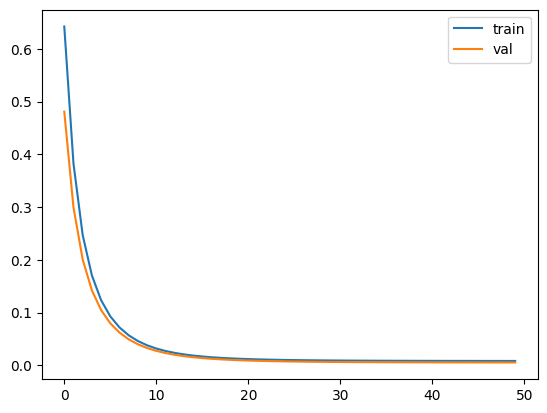

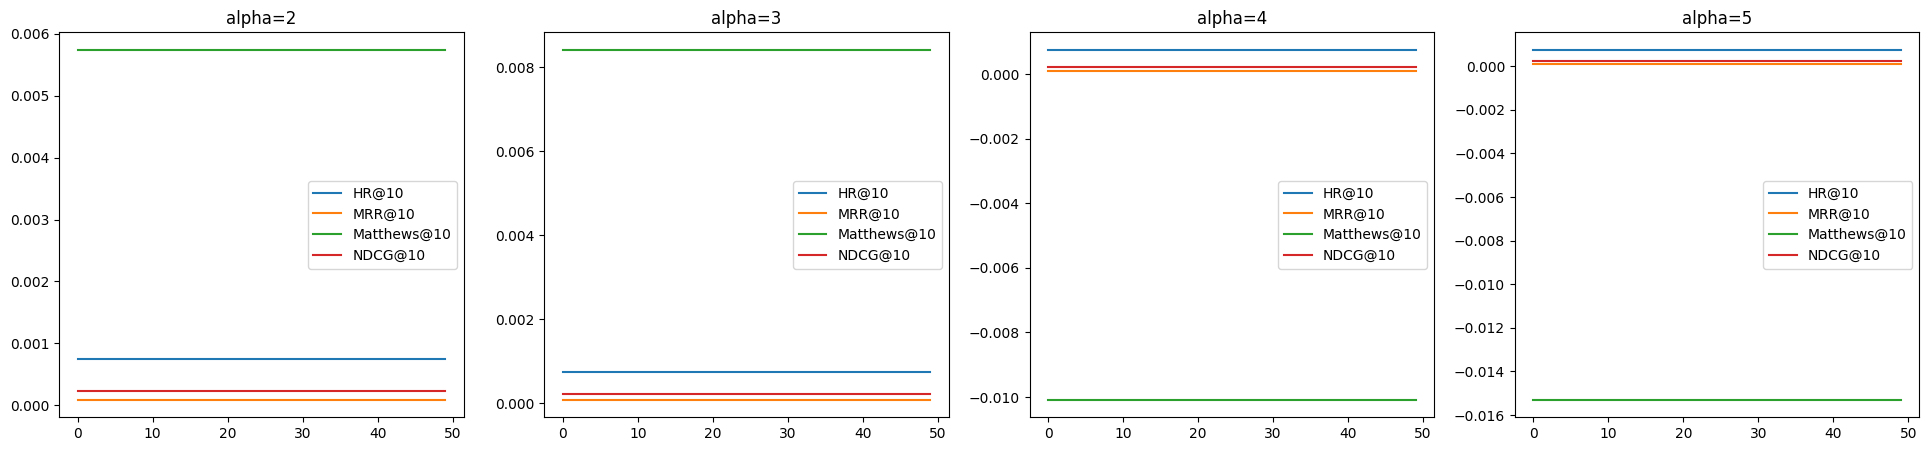

Test loss: 0.480879545211792
Train loss: 0.6422799777506624


Hidden sizes: 16 5
Current epoch 94
Results for alpha=2


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.005293  0.002686    0.000707  0.003326  0.004745  0.000548    0.00243   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.000256    0.003003    0.000324   -0.017072

HR@10  MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  MRR_pos@10  \
10  0.012046  0.0035     0.001312  0.005422   0.011316    0.00073    0.003224   

    MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.000276     0.005043     0.000379    -0.004467

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.024457  0.004325     0.002322  0.008516   0.023362   0.001095   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.004027    0.000298     0.008049     0.000467     0.004919

Results for alpha=3


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.004745  0.002494    0.000707  0.003044  0.003833  0.000913   0.001947   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.000548    0.002407    0.000637   -0.021718

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.010038  0.003244     0.001312  0.004799   0.008943   0.001095   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10     0.00267    0.000574     0.004101     0.000698    -0.003558

HR@20   MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.021172  0.00401     0.002423  0.007604   0.019164   0.002008   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.003376    0.000634     0.006679     0.000925     0.001841

Results for alpha=4


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.009856  0.008852    0.000808  0.009099  0.008578  0.001278   0.007833   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.001019    0.008017    0.001082     0.01893

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.013141  0.009268     0.001413  0.010139   0.011133   0.002008   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.008162    0.001106     0.008831     0.001308     0.015295

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.020807  0.009788     0.002625  0.012063   0.017886    0.00292   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.008629    0.001159     0.010538     0.001526     0.023797

Results for alpha=5


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.009856  0.008843    0.000707  0.009091  0.008213  0.001643   0.007459   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.001384    0.007644    0.001447    0.046594

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.011863  0.009098     0.001312  0.009728   0.009491   0.002373   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.007622    0.001476     0.008049     0.001678       0.0437

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.021172  0.009718     0.002423  0.012049   0.016426   0.004745   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.008078     0.00164     0.009772     0.002277     0.051393

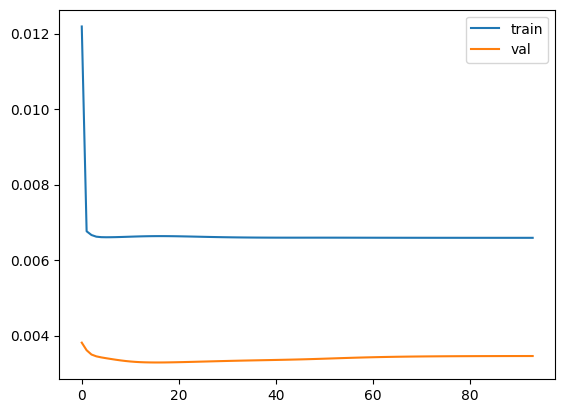

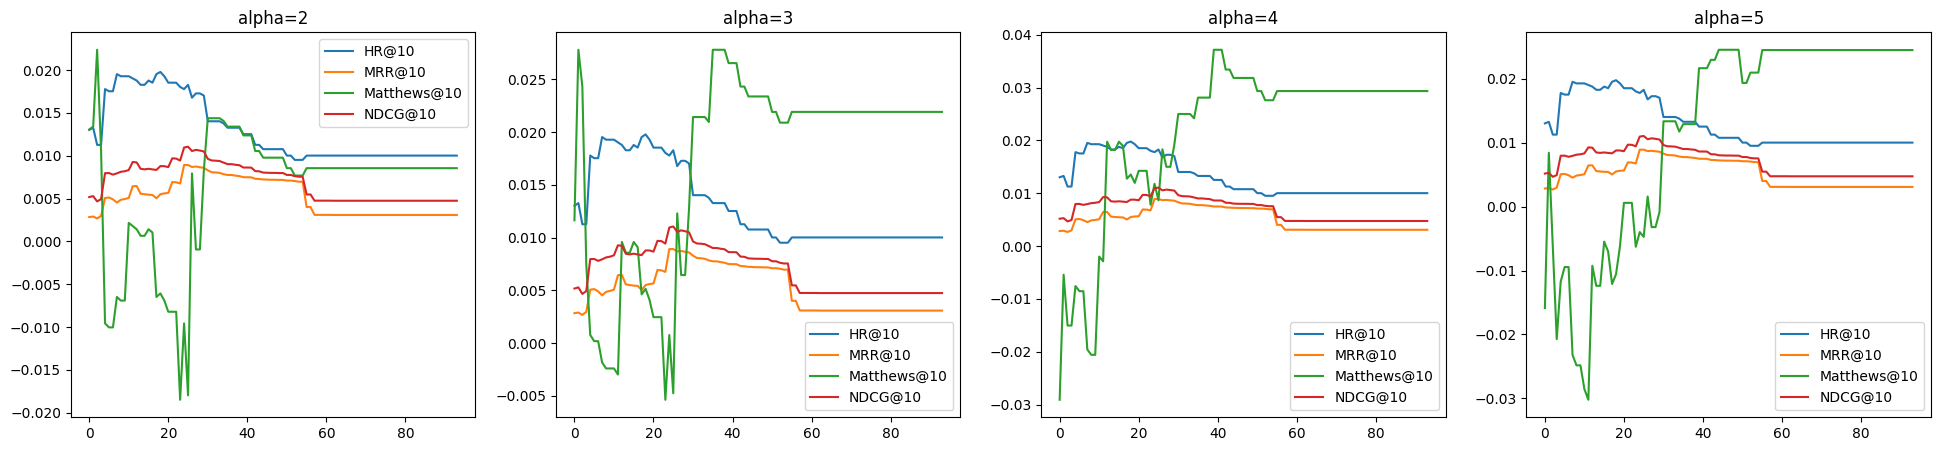

Test loss: 0.003365518990904093
Train loss: 0.00659357331679593


Hidden sizes: 32 3
Current epoch 88
Results for alpha=2


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.006936  0.002449    0.000808  0.003536  0.006571  0.000365   0.002297   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.000152     0.00333    0.000206    -0.00037

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.023179  0.004281     0.001413  0.008448   0.022449    0.00073   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.004093    0.000189     0.008136     0.000312     0.014029

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.043986  0.005672     0.002726  0.013645   0.043074   0.000913   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.005471    0.000202     0.013287     0.000359     0.029952

Results for alpha=3


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.010768  0.009034    0.000808  0.009452  0.009673  0.001095   0.008061   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.000973    0.008448    0.001004   -0.001098

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.015331  0.009583     0.001413  0.010868   0.013689   0.001643   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.008547    0.001036     0.009697      0.00117    -0.003594

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.03048  0.010496     0.002625  0.014525    0.02829    0.00219   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.009424    0.001072     0.013219     0.001306     0.015884

Results for alpha=4


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.009856  0.008852    0.000808  0.009099  0.008578  0.001278   0.007833   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.001019    0.008017    0.001082     0.01893

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.013141  0.009268     0.001413  0.010139   0.011133   0.002008   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.008162    0.001106     0.008831     0.001308     0.015295

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.021172  0.009819     0.002524  0.012162   0.018069   0.003103   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.008652    0.001168     0.010595     0.001567     0.021756

Results for alpha=5


HR@5     MRR@5  Coverage@5   NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.009673  0.008806    0.000707  0.00902  0.008031  0.001643   0.007422   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.001384    0.007573    0.001447     0.04552

HR@10   MRR@10  Coverage@10  NCDG@10  HR_pos@10  HR_neg@10  MRR_pos@10  \
10  0.011863  0.00909     0.001312  0.00972   0.009491   0.002373    0.007619   

    MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.001471     0.008046     0.001674       0.0437

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.021172  0.009704     0.002423  0.012033   0.016426   0.004745   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.008069    0.001636     0.009761     0.002273     0.051393

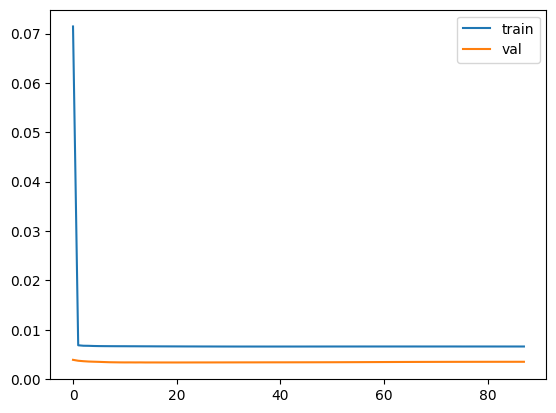

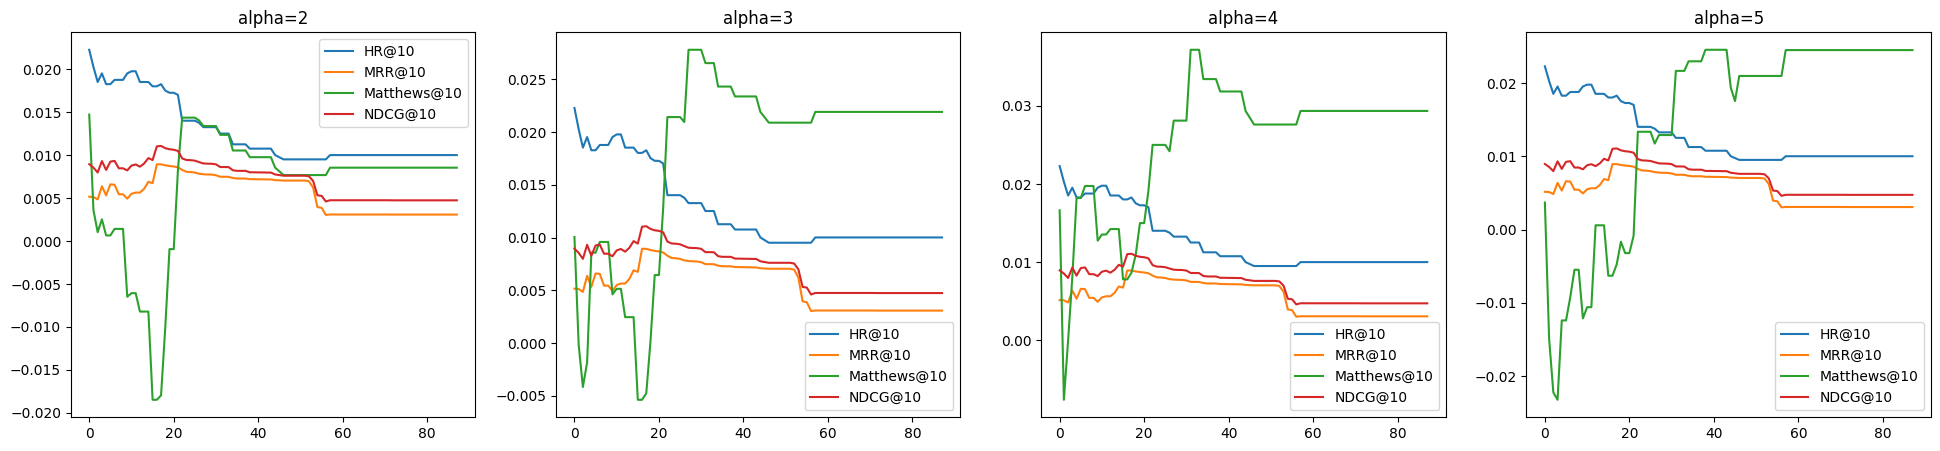

Test loss: 0.003383276518434286
Train loss: 0.006583130872046817


Hidden sizes: 32 4
Current epoch 50
Results for alpha=2


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.000365  0.000128    0.002928  0.000186  0.000365       0.0   0.000128   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5        0.0    0.000186         0.0     0.00446

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.000548  0.000065     0.004139  0.000169   0.000548        0.0   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.000065         0.0     0.000169          0.0     0.005462

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.000913  0.000091     0.005855  0.000256    0.00073   0.000183   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.000081     0.00001     0.000214     0.000042    -0.020258

Results for alpha=3


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.000365  0.000128    0.002928  0.000186  0.000365       0.0   0.000128   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5        0.0    0.000186         0.0    0.006319

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.000548  0.000065     0.004139  0.000169   0.000548        0.0   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.000065         0.0     0.000169          0.0     0.007739

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.000913  0.000091     0.005855  0.000256    0.00073   0.000183   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.000081     0.00001     0.000214     0.000042    -0.010286

Results for alpha=4


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.000365  0.000128    0.002928  0.000186  0.000183  0.000183   0.000091   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.000037    0.000115    0.000071   -0.013861

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.000548  0.000065     0.004139  0.000169   0.000365   0.000183   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.000046    0.000018     0.000116     0.000053    -0.007339

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.000913  0.000091     0.005855  0.000256   0.000548   0.000365   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.000072    0.000019     0.000172     0.000084    -0.014455

Results for alpha=5


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.000365  0.000128    0.002928  0.000186  0.000183  0.000183   0.000091   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.000037    0.000115    0.000071   -0.004106

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.000548  0.000065     0.004139  0.000169   0.000365   0.000183   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.000046    0.000018     0.000116     0.000053     0.002951

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.000913  0.000091     0.005855  0.000256   0.000548   0.000365   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.000072    0.000019     0.000172     0.000084    -0.000311

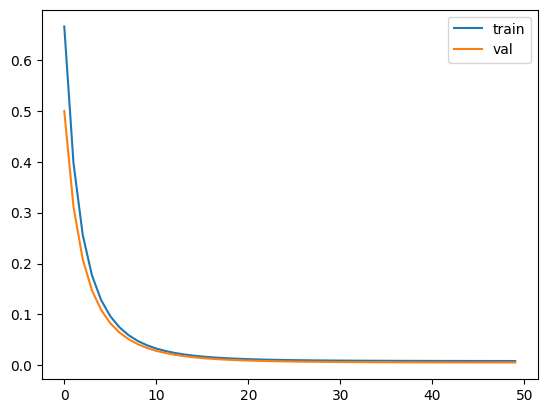

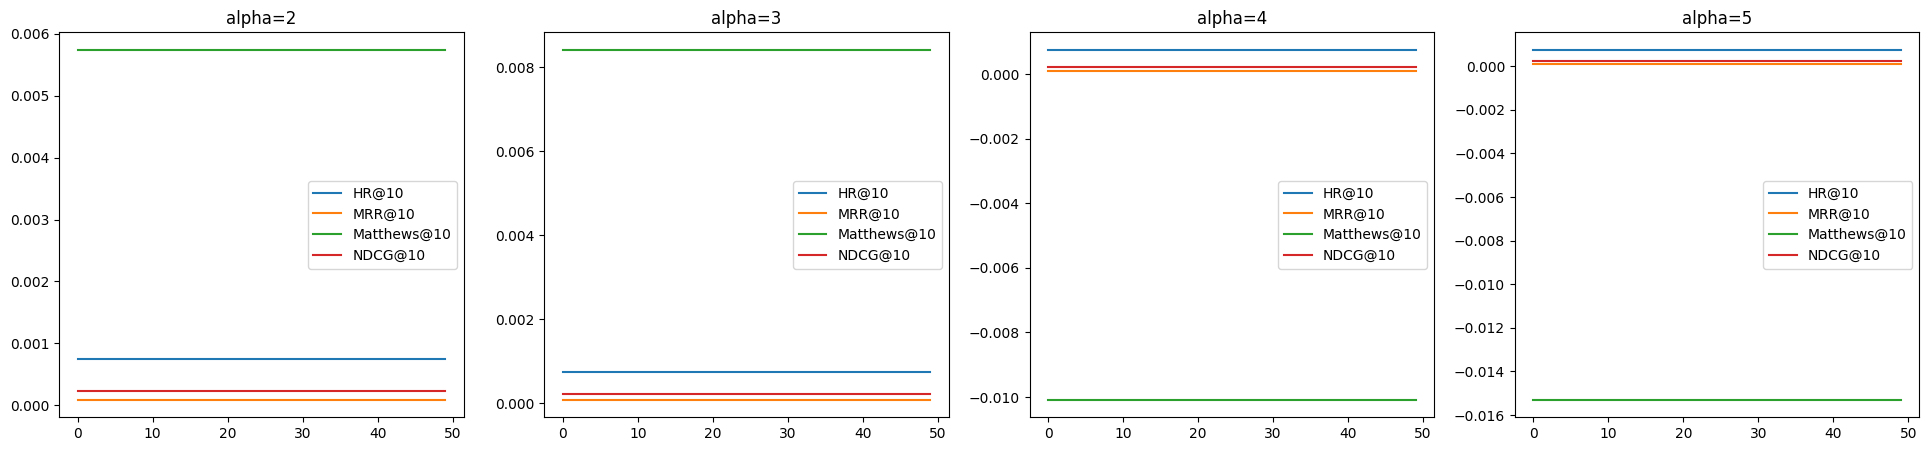

Test loss: 0.49942299723625183
Train loss: 0.6655795470622446


Hidden sizes: 32 5
Current epoch 50
Results for alpha=2


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.000365  0.000128    0.002928  0.000186  0.000365       0.0   0.000128   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5        0.0    0.000186         0.0     0.00446

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.000548  0.000065     0.004139  0.000169   0.000548        0.0   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.000065         0.0     0.000169          0.0     0.005462

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.000913  0.000091     0.005855  0.000256    0.00073   0.000183   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.000081     0.00001     0.000214     0.000042    -0.020258

Results for alpha=3


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.000365  0.000128    0.002928  0.000186  0.000365       0.0   0.000128   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5        0.0    0.000186         0.0    0.006319

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.000548  0.000065     0.004139  0.000169   0.000548        0.0   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.000065         0.0     0.000169          0.0     0.007739

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.000913  0.000091     0.005855  0.000256    0.00073   0.000183   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.000081     0.00001     0.000214     0.000042    -0.010286

Results for alpha=4


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.000365  0.000128    0.002928  0.000186  0.000183  0.000183   0.000091   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.000037    0.000115    0.000071   -0.013861

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.000548  0.000065     0.004139  0.000169   0.000365   0.000183   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.000046    0.000018     0.000116     0.000053    -0.007339

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.000913  0.000091     0.005855  0.000256   0.000548   0.000365   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.000072    0.000019     0.000172     0.000084    -0.014455

Results for alpha=5


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.000365  0.000128    0.002928  0.000186  0.000183  0.000183   0.000091   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.000037    0.000115    0.000071   -0.004106

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.000548  0.000065     0.004139  0.000169   0.000365   0.000183   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.000046    0.000018     0.000116     0.000053     0.002951

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.000913  0.000091     0.005855  0.000256   0.000548   0.000365   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.000072    0.000019     0.000172     0.000084    -0.000311

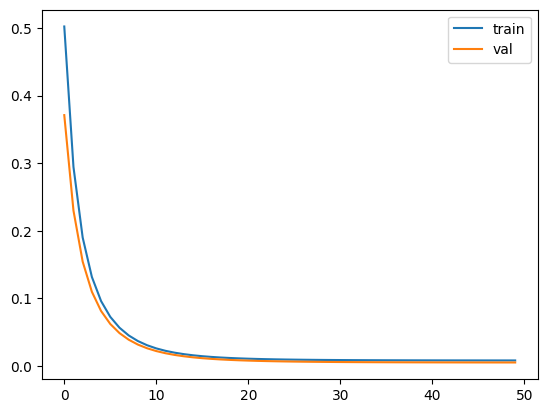

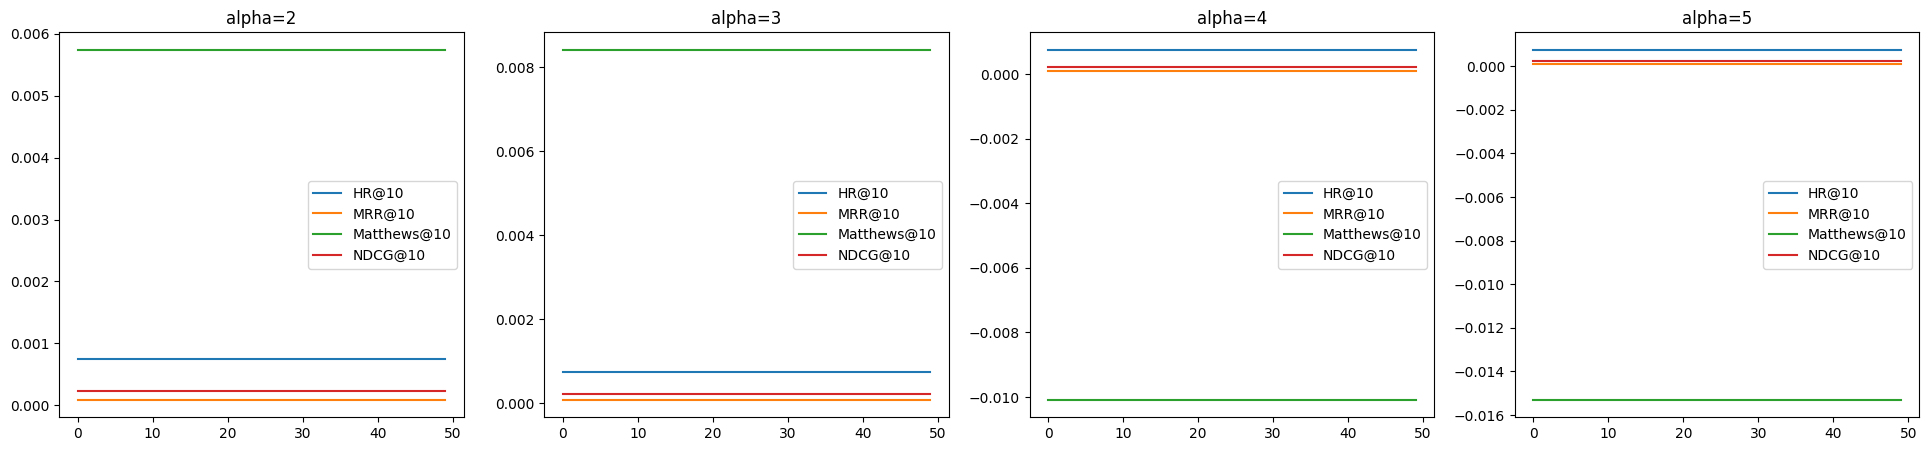

Test loss: 0.37109628319740295
Train loss: 0.5023408667574821


Hidden sizes: 64 3
Current epoch 50
Results for alpha=2


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.000365  0.000128    0.002928  0.000186  0.000365       0.0   0.000128   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5        0.0    0.000186         0.0     0.00446

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.000548  0.000065     0.004139  0.000169   0.000548        0.0   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.000065         0.0     0.000169          0.0     0.005462

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.000913  0.000091     0.005855  0.000256    0.00073   0.000183   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.000081     0.00001     0.000214     0.000042    -0.020258

Results for alpha=3


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.000365  0.000128    0.002928  0.000186  0.000365       0.0   0.000128   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5        0.0    0.000186         0.0    0.006319

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.000548  0.000065     0.004139  0.000169   0.000548        0.0   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.000065         0.0     0.000169          0.0     0.007739

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.000913  0.000091     0.005855  0.000256    0.00073   0.000183   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.000081     0.00001     0.000214     0.000042    -0.010286

Results for alpha=4


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.000365  0.000128    0.002928  0.000186  0.000183  0.000183   0.000091   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.000037    0.000115    0.000071   -0.013861

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.000548  0.000065     0.004139  0.000169   0.000365   0.000183   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.000046    0.000018     0.000116     0.000053    -0.007339

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.000913  0.000091     0.005855  0.000256   0.000548   0.000365   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.000072    0.000019     0.000172     0.000084    -0.014455

Results for alpha=5


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.000365  0.000128    0.002928  0.000186  0.000183  0.000183   0.000091   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.000037    0.000115    0.000071   -0.004106

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.000548  0.000065     0.004139  0.000169   0.000365   0.000183   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.000046    0.000018     0.000116     0.000053     0.002951

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.000913  0.000091     0.005855  0.000256   0.000548   0.000365   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.000072    0.000019     0.000172     0.000084    -0.000311

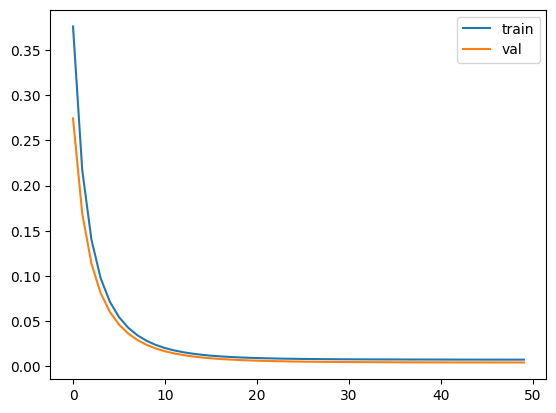

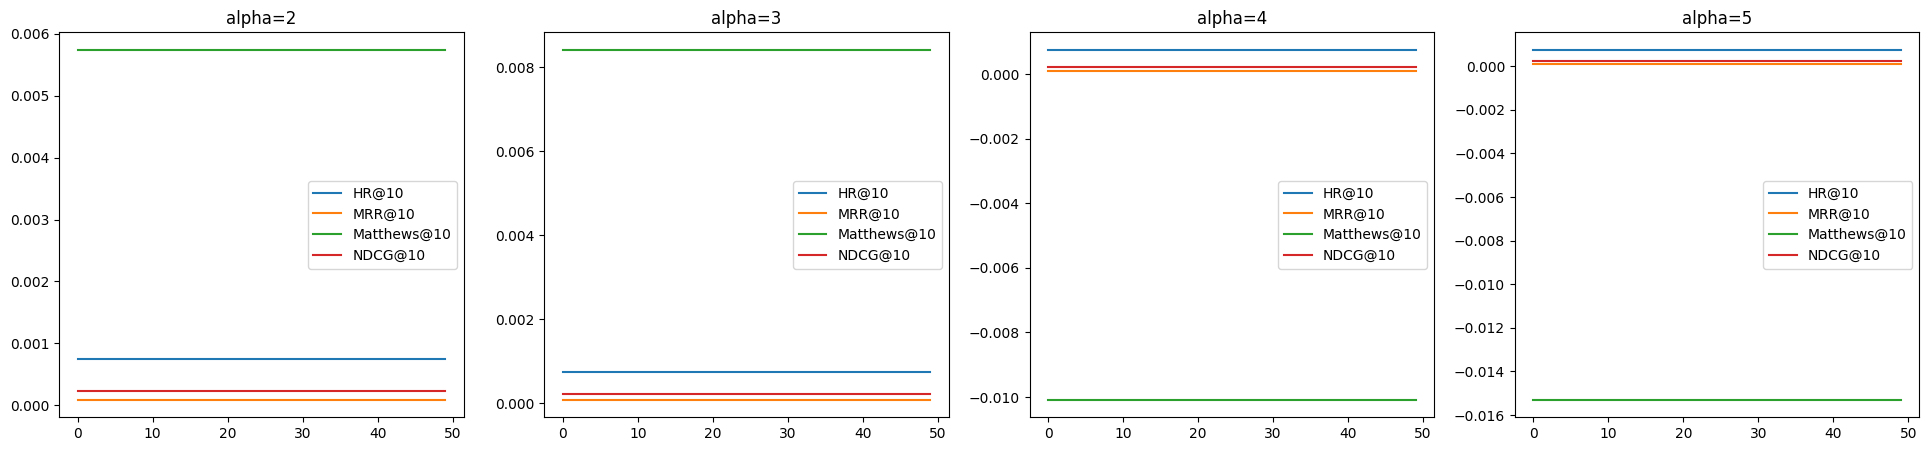

Test loss: 0.2744433581829071
Train loss: 0.37616682650107225


Hidden sizes: 64 4
Current epoch 94
Results for alpha=2


HR@5     MRR@5  Coverage@5   NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.011316  0.009287    0.000808  0.00978  0.010951  0.000365   0.008922   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.000365    0.009415    0.000365    0.009375

HR@10    MRR@10  Coverage@10  NCDG@10  HR_pos@10  HR_neg@10  \
10  0.015514  0.009892     0.001413  0.01118   0.014784    0.00073   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.009478    0.000414     0.010698     0.000483     0.002605

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.03194  0.011121     0.002625  0.015445   0.030663   0.001278   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.010669    0.000453     0.014822     0.000623     0.009563

Results for alpha=3


HR@5    MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.005293  0.00264    0.000707  0.003288  0.004198  0.001095   0.002065   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.000575    0.002588      0.0007   -0.026514

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.010221  0.003297     0.001312  0.004881   0.009126   0.001095   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.002722    0.000575     0.004181       0.0007    -0.002927

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.023544  0.004257     0.002423  0.008294   0.021354    0.00219   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.003593    0.000664     0.007301     0.000993     0.002883

Results for alpha=4


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.009856  0.008852    0.000808  0.009099  0.008578  0.001278   0.007833   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.001019    0.008017    0.001082     0.01893

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.013141  0.009268     0.001413  0.010139   0.011133   0.002008   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.008162    0.001106     0.008831     0.001308     0.015295

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.020989  0.009797     0.002625  0.012105   0.018069    0.00292   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.008639    0.001159     0.010579     0.001526     0.024345

Results for alpha=5


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.009856  0.008843    0.000707  0.009091  0.008213  0.001643   0.007459   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.001384    0.007644    0.001447    0.046594

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.011863  0.009098     0.001312  0.009728   0.009491   0.002373   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.007622    0.001476     0.008049     0.001678       0.0437

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.021172  0.009718     0.002423  0.012049   0.016426   0.004745   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.008078     0.00164     0.009772     0.002277     0.051393

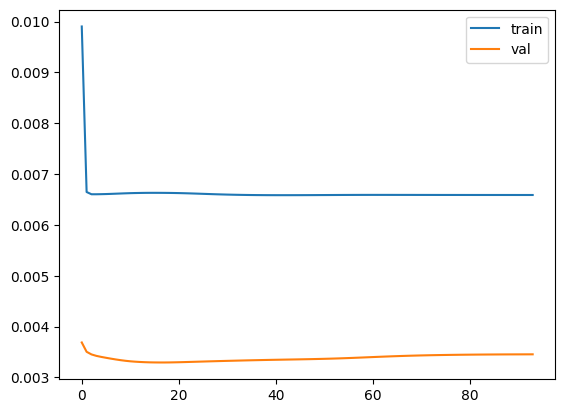

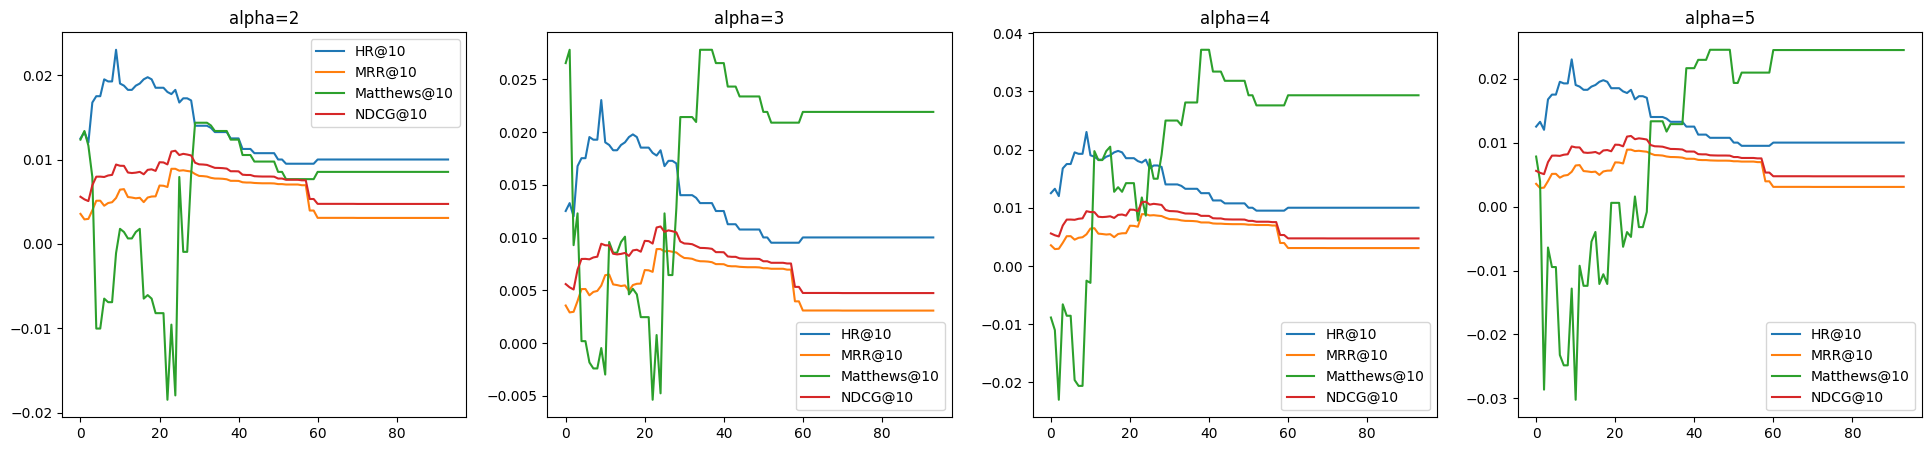

Test loss: 0.003354827407747507
Train loss: 0.006586457468017048


Hidden sizes: 64 5
Current epoch 94
Results for alpha=2


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.005293  0.002686    0.000707  0.003326  0.004745  0.000548    0.00243   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.000256    0.003003    0.000324   -0.017072

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.010586  0.003397     0.001312  0.005043   0.009856    0.00073   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.003111    0.000286     0.004654     0.000389    -0.008092

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.024275  0.004349     0.002322  0.008508   0.023179   0.001095   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.004042    0.000307     0.008032     0.000476      0.00466

Results for alpha=3


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.009856  0.008815    0.000808  0.009067  0.008578  0.001278   0.007806   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5    0.00101    0.007993    0.001074     -0.0104

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.014054  0.009329     0.001413  0.010377   0.012594    0.00146   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.008299     0.00103     0.009248     0.001129    -0.002138

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.021172  0.009814     0.002625  0.012165   0.019164   0.002008   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.008751    0.001063     0.010903     0.001261     0.001841

Results for alpha=4


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.009856  0.008852    0.000808  0.009099  0.008578  0.001278   0.007833   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.001019    0.008017    0.001082     0.01893

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.013141  0.009268     0.001413  0.010139   0.011133   0.002008   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.008162    0.001106     0.008831     0.001308     0.015295

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.020989  0.009798     0.002625  0.012106   0.018069    0.00292   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20     0.00864    0.001158     0.010581     0.001525     0.024345

Results for alpha=5


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.009856  0.008843    0.000707  0.009091  0.008213  0.001643   0.007459   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.001384    0.007644    0.001447    0.046594

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.011863  0.009094     0.001413  0.009723   0.009491   0.002373   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.007623    0.001471      0.00805     0.001674       0.0437

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.021172  0.009697     0.002423  0.012022   0.016609   0.004563   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.008076    0.001621     0.009798     0.002224     0.053987

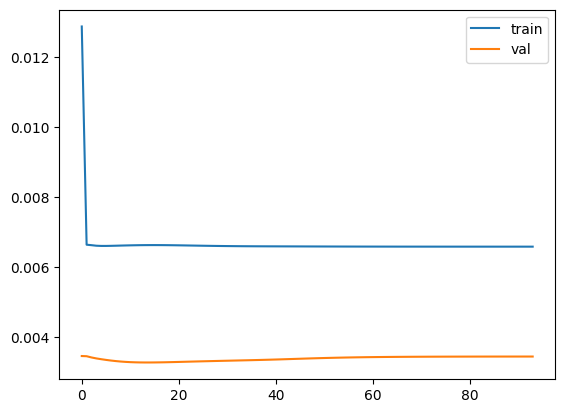

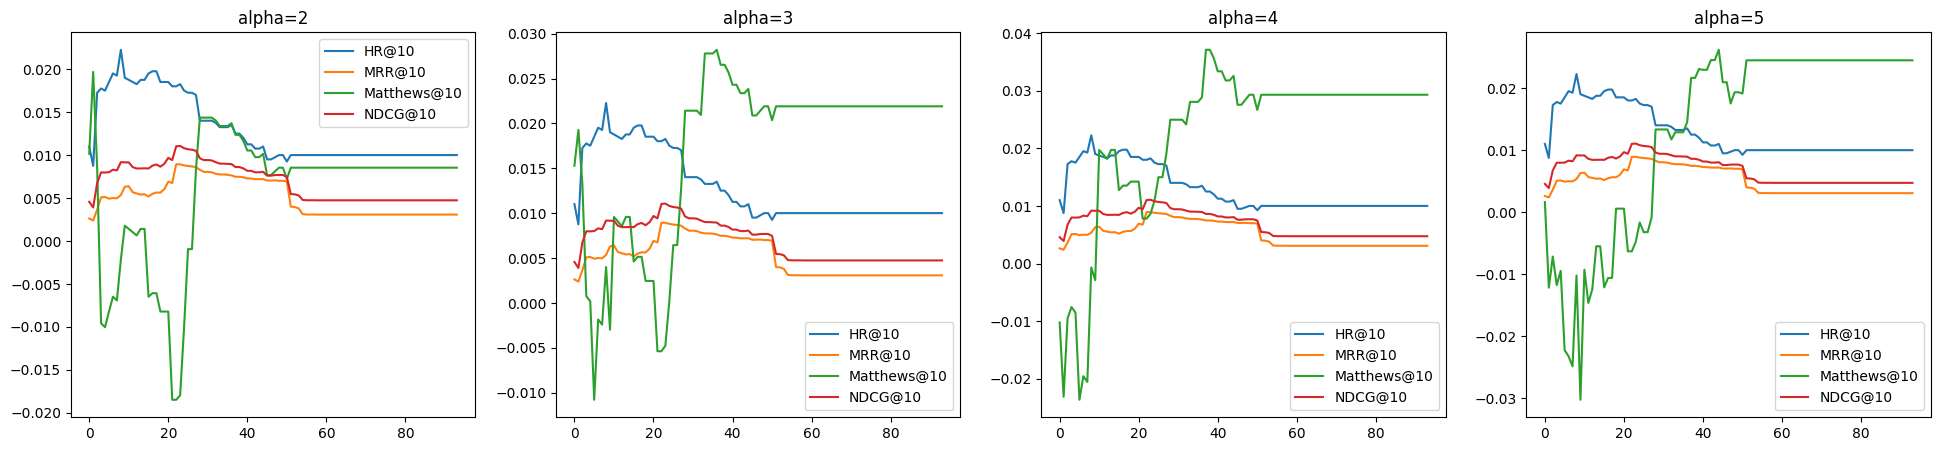

Test loss: 0.003389631398022175
Train loss: 0.006596473496597382


Hidden sizes: 128 3
Current epoch 50
Results for alpha=2


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.000365  0.000128    0.002928  0.000186  0.000365       0.0   0.000128   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5        0.0    0.000186         0.0     0.00446

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.000548  0.000065     0.004139  0.000169   0.000548        0.0   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.000065         0.0     0.000169          0.0     0.005462

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.000913  0.000091     0.005855  0.000256    0.00073   0.000183   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.000081     0.00001     0.000214     0.000042    -0.020258

Results for alpha=3


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.000365  0.000128    0.002928  0.000186  0.000365       0.0   0.000128   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5        0.0    0.000186         0.0    0.006319

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.000548  0.000065     0.004139  0.000169   0.000548        0.0   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.000065         0.0     0.000169          0.0     0.007739

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.000913  0.000091     0.005855  0.000256    0.00073   0.000183   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.000081     0.00001     0.000214     0.000042    -0.010286

Results for alpha=4


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.000365  0.000128    0.002928  0.000186  0.000183  0.000183   0.000091   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.000037    0.000115    0.000071   -0.013861

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.000548  0.000065     0.004139  0.000169   0.000365   0.000183   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.000046    0.000018     0.000116     0.000053    -0.007339

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.000913  0.000091     0.005855  0.000256   0.000548   0.000365   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.000072    0.000019     0.000172     0.000084    -0.014455

Results for alpha=5


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.000365  0.000128    0.002928  0.000186  0.000183  0.000183   0.000091   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.000037    0.000115    0.000071   -0.004106

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.000548  0.000065     0.004139  0.000169   0.000365   0.000183   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.000046    0.000018     0.000116     0.000053     0.002951

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.000913  0.000091     0.005855  0.000256   0.000548   0.000365   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.000072    0.000019     0.000172     0.000084    -0.000311

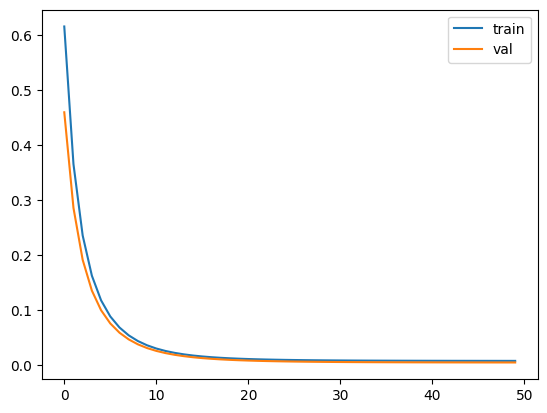

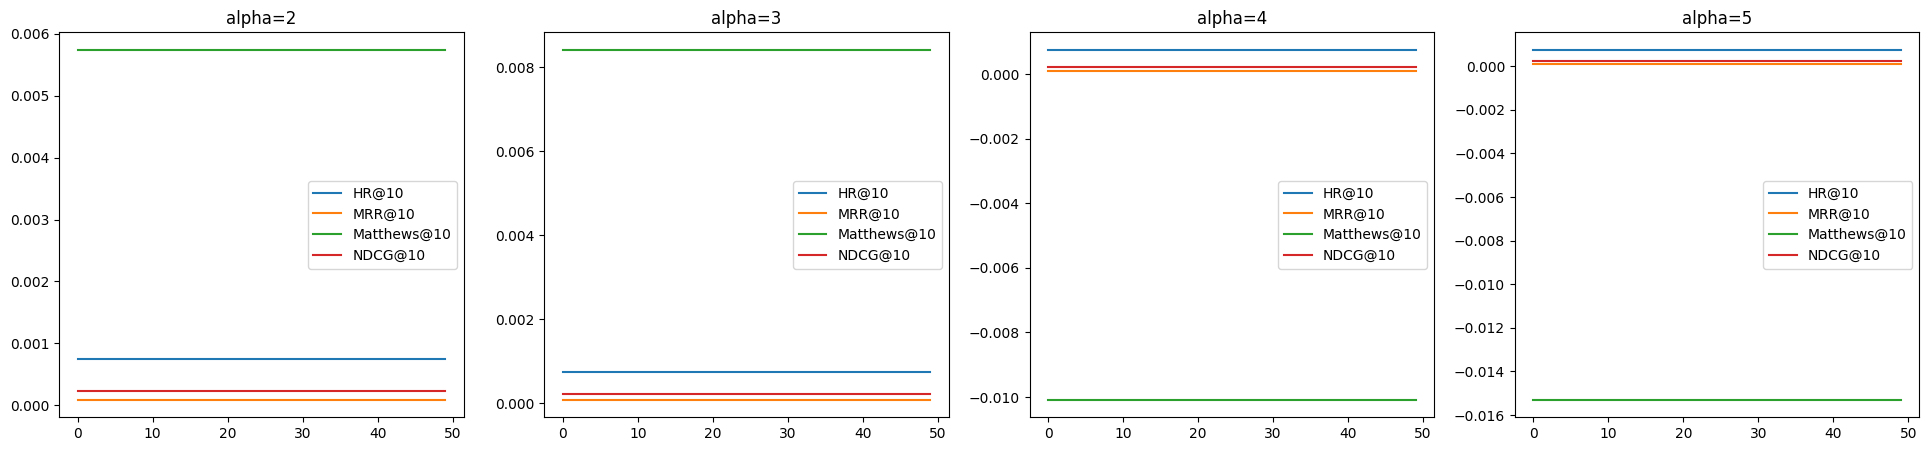

Test loss: 0.46024343371391296
Train loss: 0.6162311259480612


Hidden sizes: 128 4
Current epoch 50
Results for alpha=2


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.000365  0.000128    0.002928  0.000186  0.000365       0.0   0.000128   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5        0.0    0.000186         0.0     0.00446

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.000548  0.000065     0.004139  0.000169   0.000548        0.0   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.000065         0.0     0.000169          0.0     0.005462

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.000913  0.000091     0.005855  0.000256    0.00073   0.000183   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.000081     0.00001     0.000214     0.000042    -0.020258

Results for alpha=3


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.000365  0.000128    0.002928  0.000186  0.000365       0.0   0.000128   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5        0.0    0.000186         0.0    0.006319

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.000548  0.000065     0.004139  0.000169   0.000548        0.0   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.000065         0.0     0.000169          0.0     0.007739

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.000913  0.000091     0.005855  0.000256    0.00073   0.000183   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.000081     0.00001     0.000214     0.000042    -0.010286

Results for alpha=4


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.000365  0.000128    0.002928  0.000186  0.000183  0.000183   0.000091   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.000037    0.000115    0.000071   -0.013861

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.000548  0.000065     0.004139  0.000169   0.000365   0.000183   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.000046    0.000018     0.000116     0.000053    -0.007339

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.000913  0.000091     0.005855  0.000256   0.000548   0.000365   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.000072    0.000019     0.000172     0.000084    -0.014455

Results for alpha=5


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.000365  0.000128    0.002928  0.000186  0.000183  0.000183   0.000091   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.000037    0.000115    0.000071   -0.004106

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.000548  0.000065     0.004139  0.000169   0.000365   0.000183   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.000046    0.000018     0.000116     0.000053     0.002951

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.000913  0.000091     0.005855  0.000256   0.000548   0.000365   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.000072    0.000019     0.000172     0.000084    -0.000311

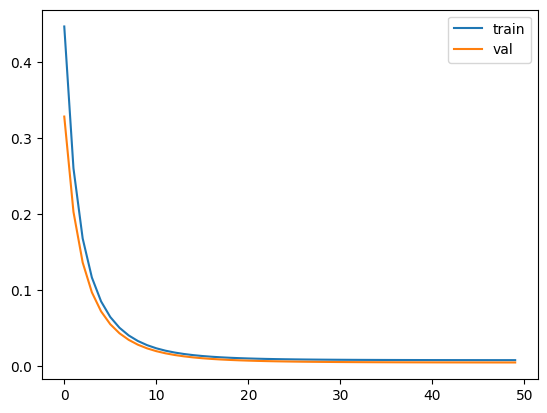

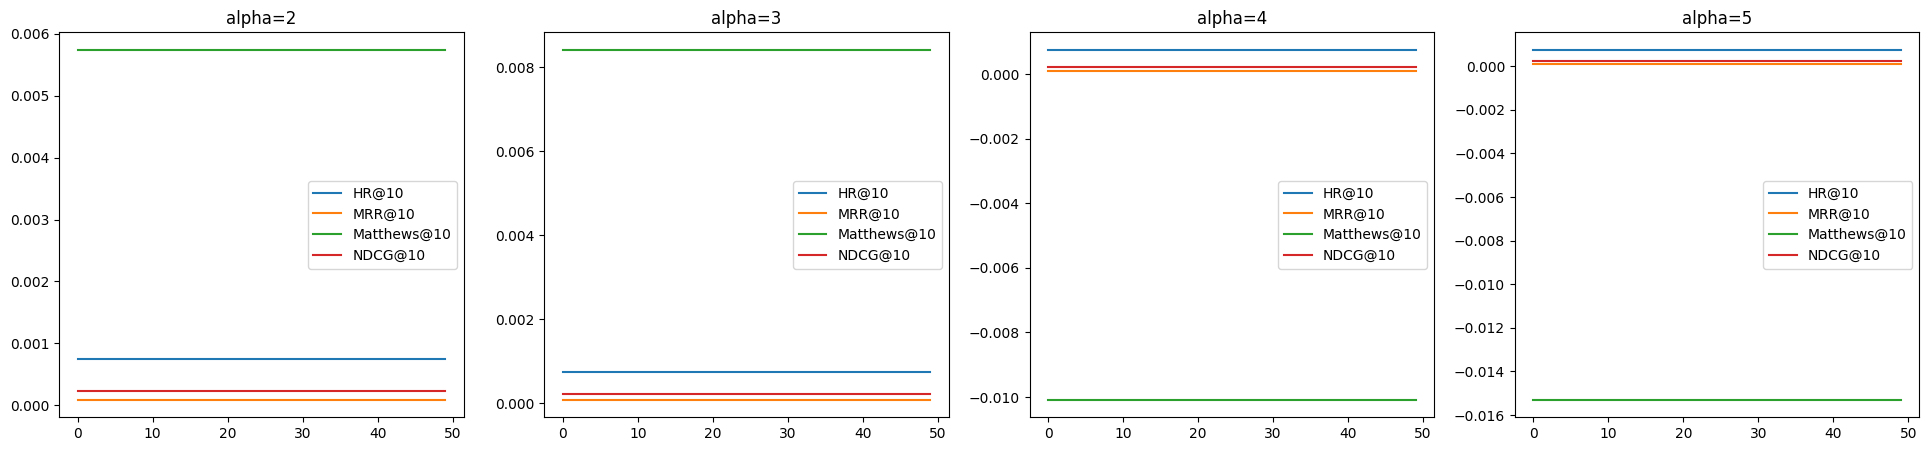

Test loss: 0.32787200808525085
Train loss: 0.44627420497404124


Hidden sizes: 128 5
Current epoch 98
Results for alpha=2


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.005293  0.002686    0.000707  0.003326  0.004745  0.000548    0.00243   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.000256    0.003003    0.000324   -0.017072

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.012776  0.003634     0.001413  0.005695   0.012046    0.00073   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.003352    0.000282     0.005311     0.000385    -0.002822

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.024092  0.004374     0.002524  0.008504   0.022997   0.001095   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.004069    0.000305     0.008029     0.000475     0.004399

Results for alpha=3


HR@5    MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.005293  0.00264    0.000707  0.003288  0.004198  0.001095   0.002065   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.000575    0.002588      0.0007   -0.026514

HR@10    MRR@10  Coverage@10  NCDG@10  HR_pos@10  HR_neg@10  \
10  0.010586  0.003346     0.001312    0.005   0.009491   0.001095   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.002771    0.000575       0.0043       0.0007    -0.001697

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.023362  0.004221     0.002524  0.008219   0.021172    0.00219   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.003569    0.000652      0.00724     0.000979     0.002495

Results for alpha=4


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.009856  0.008852    0.000808  0.009099  0.008578  0.001278   0.007833   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.001019    0.008017    0.001082     0.01893

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.012959  0.009249     0.001514  0.010086   0.010951   0.002008   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.008143    0.001106     0.008778     0.001308     0.014578

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.020989  0.009804     0.002625  0.012112   0.018069    0.00292   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.008647    0.001157     0.010589     0.001523     0.024345

Results for alpha=5


HR@5     MRR@5  Coverage@5   NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.009673  0.008806    0.000707  0.00902  0.008031  0.001643   0.007422   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.001384    0.007573    0.001447     0.04552

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.012411  0.009131     0.001413  0.009864   0.009856   0.002555   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.007643    0.001488      0.00814     0.001724      0.04336

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.020989  0.009683     0.002524  0.011978   0.016244   0.004745   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20     0.00805    0.001633     0.009709     0.002269     0.050583

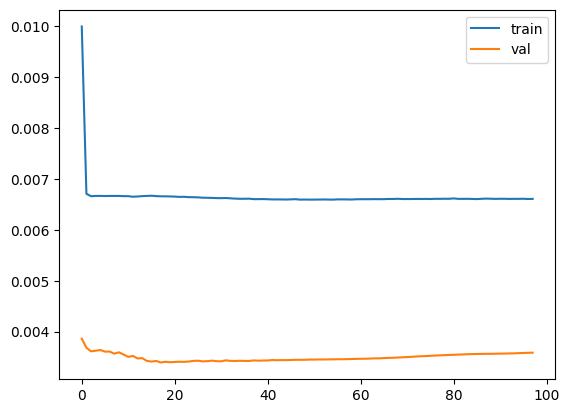

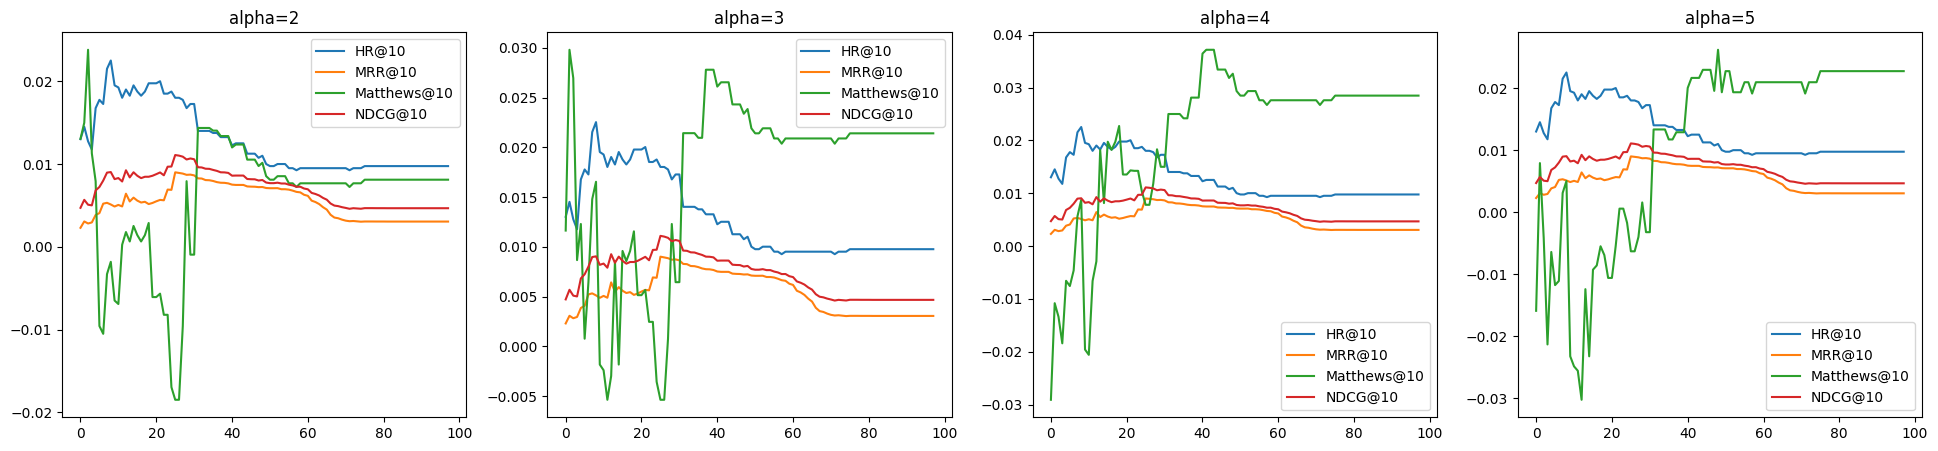

Test loss: 0.003447737777605653
Train loss: 0.006596668006655367


Hidden sizes: 256 3
Current epoch 76
Results for alpha=2


HR@5     MRR@5  Coverage@5   NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.011316  0.009287    0.000808  0.00978  0.010951  0.000365   0.008922   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.000365    0.009415    0.000365    0.009375

HR@10    MRR@10  Coverage@10  NCDG@10  HR_pos@10  HR_neg@10  \
10  0.015514  0.009892     0.001413  0.01118   0.014784    0.00073   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.009478    0.000414     0.010698     0.000483     0.002605

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.03194  0.011118     0.002625  0.015441   0.030663   0.001278   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.010667    0.000452      0.01482     0.000621     0.009563

Results for alpha=3


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.010951  0.009071    0.000808  0.009523  0.009856  0.001095   0.008098   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.000973    0.008519    0.001004   -0.000509

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.015331  0.009573     0.001413  0.010857   0.013689   0.001643   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10     0.00854    0.001033      0.00969     0.001167    -0.003594

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.030663  0.010518     0.002625  0.014587   0.028472    0.00219   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.009449    0.001069     0.013284     0.001303     0.016188

Results for alpha=4


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.009856  0.008852    0.000808  0.009099  0.008578  0.001278   0.007833   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.001019    0.008017    0.001082     0.01893

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.013141  0.009268     0.001413  0.010139   0.011133   0.002008   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.008162    0.001106     0.008831     0.001308     0.015295

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.020989  0.009797     0.002625  0.012105   0.018069    0.00292   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.008639    0.001159     0.010579     0.001526     0.024345

Results for alpha=5


HR@5     MRR@5  Coverage@5   NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.009673  0.008806    0.000707  0.00902  0.008031  0.001643   0.007422   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.001384    0.007573    0.001447     0.04552

HR@10   MRR@10  Coverage@10  NCDG@10  HR_pos@10  HR_neg@10  MRR_pos@10  \
10  0.011863  0.00909     0.001312  0.00972   0.009491   0.002373    0.007619   

    MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.001471     0.008046     0.001674       0.0437

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.021354  0.009714     0.002423  0.012075   0.016791   0.004563   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.008088    0.001626     0.009845      0.00223     0.054781

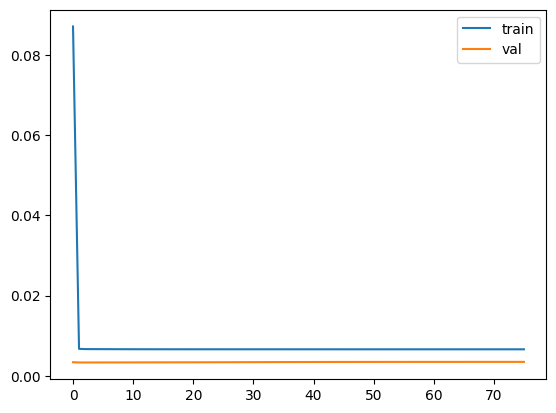

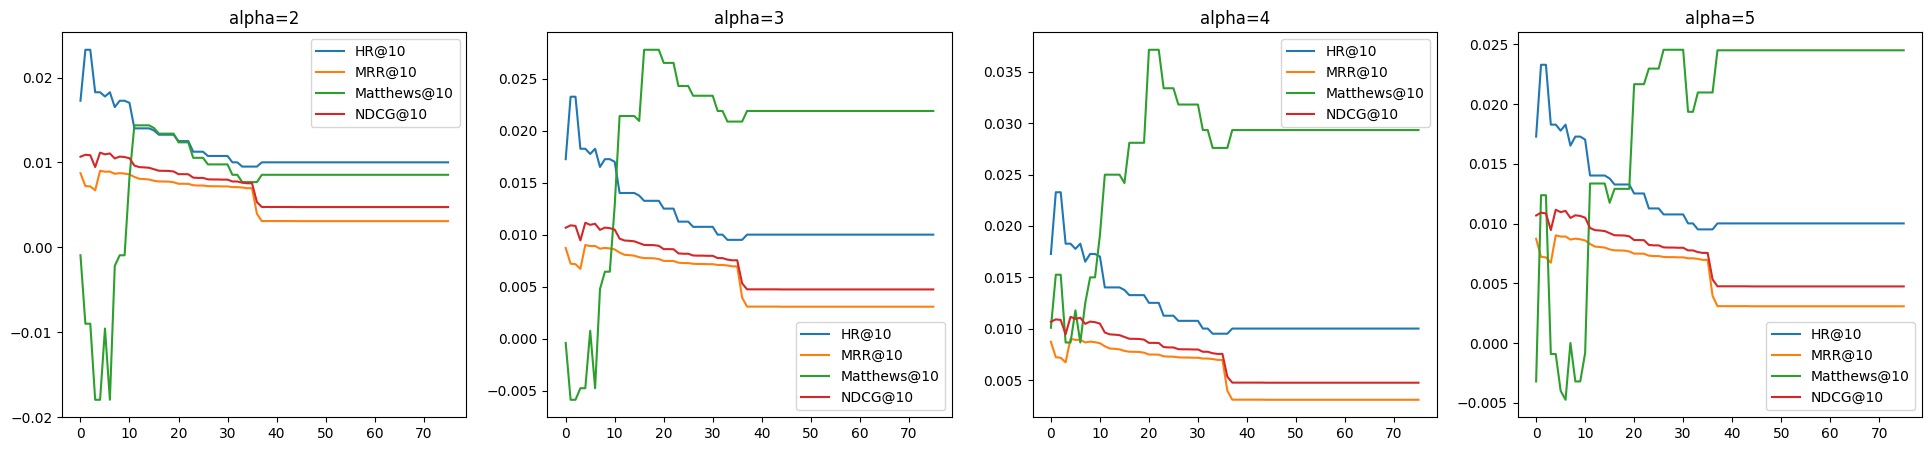

Test loss: 0.0033703548833727837
Train loss: 0.0065951717667788595


Hidden sizes: 256 4


In [ ]:
params = []
histories = []
test_losses = []
early_stop = 50
n_epochs = 1000
num_batches = int(np.ceil(tensor.shape[0] / batch_size))

user_tensor_val, target_val = prepare_tensor(testset_valid, data_description)
user_tensor_test, target_test = prepare_tensor(testset, data_description)

val_num_batches = int(np.ceil(target_val.shape[0] / batch_size))
test_num_batches = int(np.ceil(target_test.shape[0] / batch_size))

for h1, h2, in tqdm(zip(grid[1].flatten(), grid[0].flatten()), total=21):
    print('Hidden sizes:', h1, h2)
    
    ae = AE(data_description['n_items'], data_description['n_ratings'], h1, h2).to(device)
    criterion = nn.BCEWithLogitsLoss().to(device)
    optimizer = optim.Adam(ae.parameters())
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
    
    params.append(sum(p.numel() for p in ae.parameters() if p.requires_grad))
    
    # Training the AE
    history = []
    val_history = []

    hrs2 = []
    mrrs2 = []
    cs2 = []
    ndcgs2 = []

    hrs3 = []
    mrrs3 = []
    cs3 = []
    ndcgs3 = []

    hrs4 = []
    mrrs4 = []
    cs4 = []
    ndcgs4 = []
    
    hrs5 = []
    mrrs5 = []
    cs5 = []
    ndcgs5 = []

    prev_matt2 = [0]
    prev_matt3 = [0]
    prev_matt4 = [0]
    prev_matt5 = [0]
    
    for epoch in range(1, n_epochs+1):
        train_loss = 0
        shuffle = np.random.choice(tensor.shape[0], size=tensor.shape[0], replace=False)
        tensor = tensor[shuffle]
        
        for batch in range(num_batches):
            optimizer.zero_grad()
            
            input_tensor = tensor[batch * batch_size: (batch+1) * batch_size].to(device)
            target = matrix[batch * batch_size: (batch+1) * batch_size].to(device)

            output = ae(input_tensor)
            target.require_grad = False # we don't use it in training

            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.data.item()

        scheduler.step()
        history.append(train_loss / num_batches)

        test_loss = 0
        scores = torch.zeros((testset_valid.userid.nunique(), data_description['n_items']))
        
        with torch.no_grad():
            for batch in range(val_num_batches):
                input_tensor = user_tensor_val[batch * batch_size: (batch+1) * batch_size].to(device)
                target = target_val[batch * batch_size: (batch+1) * batch_size].to(device)
            
                output = ae(input_tensor)
                target.require_grad = False

                test_loss += criterion(output, target)
                scores[batch * batch_size: (batch+1) * batch_size] = output
        
        scores = scores.detach().cpu().numpy()
        val_loss = test_loss / val_num_batches
        val_history.append(val_loss.item())
        
        downvote_seen_items(scores, testset_valid, data_description)
        
        prev_matt2 = predict_and_check(scores, holdout_valid, data_description, hrs2, mrrs2, cs2, ndcgs2, 2, prev_matt2, epoch)
        prev_matt3 = predict_and_check(scores, holdout_valid, data_description, hrs3, mrrs3, cs3, ndcgs3, 3, prev_matt3, epoch)
        prev_matt4 = predict_and_check(scores, holdout_valid, data_description, hrs4, mrrs4, cs4, ndcgs4, 4, prev_matt4, epoch)
        prev_matt5 = predict_and_check(scores, holdout_valid, data_description, hrs5, mrrs5, cs5, ndcgs5, 5, prev_matt5, epoch)
        
        # stop = epoch if epoch < early_stop else epoch-early_stop
        if len(prev_matt2) >= early_stop and len(prev_matt3) >= early_stop and len(prev_matt4) >= early_stop and len(prev_matt5) >= early_stop:
            print(f'Current epoch {epoch}')
            break
            
    
    # Testing the AE
    check_test(ae, criterion, user_tensor_test, target_test, testset, holdout, data_description, test_num_batches, 2, batch_size=16, dcg=True)
    check_test(ae, criterion, user_tensor_test, target_test, testset, holdout, data_description, test_num_batches, 3, batch_size=16, dcg=True)
    check_test(ae, criterion, user_tensor_test, target_test, testset, holdout, data_description, test_num_batches, 4, batch_size=16, dcg=True)
    check_test(ae, criterion, user_tensor_test, target_test, testset, holdout, data_description, test_num_batches, 5, batch_size=16, dcg=True)
    
    # our
    plt.plot(history, label='train')
    plt.plot(val_history, label='val')
    plt.legend()
    plt.show()

    hrs = [hrs2, hrs3, hrs4, hrs5]
    mrrs = [mrrs2, mrrs3, mrrs4, mrrs5]
    cs = [cs2, cs3, cs4, cs5]
    ndcgs = [ndcgs2, ndcgs3, ndcgs4, ndcgs5]

    fig = plt.figure(figsize=(24,5))
    axes = fig.subplots(nrows=1, ncols=4)
    for i in range(4):
        axes[i].set_title(f'alpha={i+2}')
        axes[i].plot(hrs[i], label='HR@10')
        axes[i].plot(mrrs[i], label='MRR@10')
        axes[i].plot(cs[i], label='Matthews@10')
        axes[i].plot(ndcgs[i], label='NDCG@10')
        axes[i].legend()
        
    plt.show()
    
    print('Test loss:', val_history[-min(early_stop, epoch)])
    print('Train loss:', history[-min(early_stop, epoch)])
    
    print()
    print()

In [1]:
hrs

NameError: ignored

## Model: square root matrix

In [ ]:
train_dataset = MVDataset(training, data_description)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)

In [ ]:
len(train_dataloader)

823

In [ ]:
data_description['n_items'], data_description['n_ratings']

(9906, 5)

In [ ]:
def triu_init(m):
    if isinstance(m, nn.Linear):
        with torch.no_grad():
            s, V = torch.linalg.eig(m.weight)
            m.weight.copy_(V @ torch.diag(torch.sqrt(s)) @ torch.linalg.inv(V))
            
# def get_zero_grad_hook(mask):
#     def hook(grad):
#         return grad * mask
#     return hook

In [ ]:
class AE(nn.Module):
    def __init__(self, n_items, n_ratings, hid1, hid2):
        super(AE, self).__init__()
        self.V = nn.Linear(n_items, hid1)
        torch.nn.init.xavier_uniform_(self.V.weight)
        self.W = nn.Linear(n_ratings, hid2)
        torch.nn.init.xavier_uniform_(self.W.weight)
        self.L = nn.Linear(n_ratings, n_ratings, bias=False)
        torch.nn.init.xavier_uniform_(self.L.weight)
        triu_init(self.L)
        torch.nn.init.eye_(self.L.weight)
        self.norm = nn.LayerNorm(n_ratings)
        self.vec = nn.Linear(n_ratings, 1)
        torch.nn.init.xavier_uniform_(self.vec.weight)
        
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        
    def forward(self, x):
        # encode
        x = self.L(x)
#         x = self.norm(x)
        x = self.relu(x)
        x = self.W(x)
        x = self.relu(x)
        xT = torch.transpose(x, -1, -2)
        yT = self.V(xT)
        y = torch.transpose(yT, -1, -2)
        y = self.relu(y)
        # decode
        output = torch.matmul(y, self.W.weight)
        output = self.relu(output)
        output = torch.matmul(output, self.L.weight)
#         output = self.norm(output)
        output = self.relu(output)
        outputT = torch.transpose(output, -1, -2)
        outputT = torch.matmul(outputT, self.V.weight)
        output = torch.transpose(outputT, -1, -2)
#         output = self.relu(output)
        # vec
        output = self.vec(output).squeeze(-1)
        return output

In [ ]:
fix_torch_seed(42)
set_random_seed(42)

ae = AE(data_description['n_items'], data_description['n_ratings'], 256, 3).to(device)
criterion = nn.BCEWithLogitsLoss().to(device)
optimizer = optim.Adam(ae.parameters())
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

C:\Users\Liza\AppData\Local\Temp\ipykernel_21496\1739130729.py:5: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\Copy.cpp:276.)
  m.weight.copy_(V @ torch.diag(torch.sqrt(s)) @ torch.linalg.inv(V))


In [ ]:
ae.L.weight @ ae.L.weight

tensor([[1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.]], device='cuda:0', grad_fn=<MmBackward0>)

In [ ]:
# mask = torch.triu(torch.ones_like(ae.L.weight)).T
# # Register with hook
# ae.L.weight.register_hook(get_zero_grad_hook(mask))

In [ ]:
sum(p.numel() for p in ae.parameters() if p.requires_grad)

2536251

Epoch 20


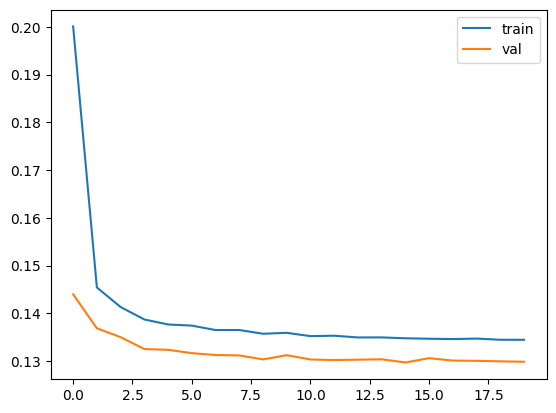

In [ ]:
# Training the AE
history = []
val_history = []

prev_train_loss = 1
prev_test_loss = 1
train_loss = 0.1 * len(train_dataloader)
test_loss = 0.1 * testset_valid.userid.nunique()
epoch = 1
best_valid_loss = float('inf')

while prev_test_loss - test_loss / testset_valid.userid.nunique() > 1e-4 or test_loss / testset_valid.userid.nunique() > 0.13:
    if epoch > 1:
        prev_train_loss = train_loss / len(train_dataloader)
        prev_test_loss = test_loss / testset_valid.userid.nunique()
    train_loss = 0
    for batch in train_dataloader:
        optimizer.zero_grad()
        
        user_tensor, user_matrix = batch
        
        input_tensor = user_tensor.to_dense().to(device)
        target = user_matrix.to_dense().to(device)
        
        output = ae(input_tensor)
        target.require_grad = False # we don't use it in training

        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.data.item()
    
    scheduler.step()
    history.append(train_loss / len(train_dataloader))
    
    test_loss = 0
    with torch.no_grad():
        for user in testset_valid.userid.unique():
            itemidx = testset_valid.loc[testset_valid.userid == user, data_description['items']].values
            feedbackidx = testset_valid.loc[testset_valid.userid == user, data_description['feedback']].values
            values = np.ones(len(itemidx), dtype=np.float32)

            user_tensor_test = torch.sparse_coo_tensor(np.array([itemidx, feedbackidx-1]), torch.tensor(values),
                                      size=torch.Size((data_description["n_items"], data_description['n_ratings']))).to_dense().to(device).unsqueeze(0)
            target = torch.sparse_coo_tensor(np.array([itemidx]), torch.tensor(values),
                                      size=torch.Size((data_description["n_items"], ))).to_dense().to(device).unsqueeze(0)

            output = ae(user_tensor_test)
            target.require_grad = False

            loss = criterion(output, target)
            test_loss += loss.data.item()
    
    valid_loss = test_loss / testset_valid.userid.nunique()
    val_history.append(valid_loss)
#         print('test loss: '+str(test_loss / testset.userid.nunique()))
    
    if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(ae.state_dict(), 'best-model.pt')
    
    clear_output()
    print('Epoch', epoch)
    plt.plot(history, label='train')
    plt.plot(val_history, label='val')
    plt.legend()
    plt.show()
    epoch += 1
#     print('epoch: '+str(epoch)+' loss: '+str(train_loss / len(train_dataloader)))

In [ ]:
ae.L.weight

Parameter containing:
tensor([[-0.1739,  0.0000,  0.0000,  0.0000,  0.0000],
        [-0.0287,  0.6074,  0.0000,  0.0000,  0.0000],
        [ 0.0600, -0.1837, -0.5307,  0.0000,  0.0000],
        [ 0.4533,  0.2487, -0.4121,  0.0950,  0.0000],
        [-0.6271,  0.1836, -0.7649,  0.3127, -0.5906]], device='cuda:0',
       requires_grad=True)

In [ ]:
ae.L.weight @ ae.L.weight.T

tensor([[ 0.0302,  0.0050, -0.0104, -0.0788,  0.1091],
        [ 0.0050,  0.3697, -0.1133,  0.1380,  0.1295],
        [-0.0104, -0.1133,  0.3189,  0.2002,  0.3345],
        [-0.0788,  0.1380,  0.2002,  0.4462,  0.1064],
        [ 0.1091,  0.1295,  0.3345,  0.1064,  1.4587]], device='cuda:0',
       grad_fn=<MmBackward0>)

In [ ]:
# Testing the AE
test_loss = 0
# model = AE(data_description['n_items'], data_description['n_ratings'], 256, 3).to(device)
# model.load_state_dict(torch.load('best-model.pt'))

scores = torch.zeros((len(testset.userid.unique()), data_description['n_items']))

for user in testset.userid.unique():
    itemidx = testset.loc[testset.userid == user, data_description['items']].values
    feedbackidx = testset.loc[testset.userid == user, data_description['feedback']].values
    values = np.ones(len(itemidx), dtype=np.float32)

    user_tensor_test = torch.sparse_coo_tensor(np.array([itemidx, feedbackidx-1]), torch.tensor(values),
                              size=torch.Size((data_description["n_items"], data_description['n_ratings']))).to_dense().to(device).unsqueeze(0)
    target = torch.sparse_coo_tensor(np.array([itemidx]), torch.tensor(values),
                              size=torch.Size((data_description["n_items"], ))).to_dense().to(device).unsqueeze(0)
    
    output = ae(user_tensor_test)
    target.require_grad = False
    scores[i] = output[0].T

    loss = criterion(output, target)
    test_loss += loss.data.item()

scores = scores.detach().numpy()    
print('test loss: '+str(test_loss / testset.userid.nunique()))

test loss: 0.12897759667405873


In [ ]:
# our
downvote_seen_items(scores, testset, data_description)
make_prediction(scores, holdout, data_description)

HR@5 = 0.0092, MRR@5 = 0.0058, Coverage@5 = 0.0203
HR_pos@5 = 0.0081, HR_neg@5 = 0.0012
MRR_pos@5 = 0.0054, MRR_neg@5 = 0.0004
Matthews@5 = 0.0137
-------------------------------------
HR@10 = 0.0190, MRR@10 = 0.0070, Coverage@10 = 0.0317
HR_pos@10 = 0.0178, HR_neg@10 = 0.0012
MRR_pos@10 = 0.0066, MRR_neg@10 = 0.0004
Matthews@10 = 0.0431
-------------------------------------
HR@20 = 0.0409, MRR@20 = 0.0085, Coverage@20 = 0.0529
HR_pos@20 = 0.0380, HR_neg@20 = 0.0029
MRR_pos@20 = 0.0080, MRR_neg@20 = 0.0005
Matthews@20 = 0.0587
-------------------------------------


(0.007043536632144227, 0.0189873417721519, 0.04310505000932261)

### Tuning

In [ ]:
grid1 = 2**np.arange(9, 11) #2**np.arange(4, 11)
grid2 = np.arange(3, 5)
grid = np.meshgrid(grid2, grid1)

In [ ]:
params = []
histories = []
test_losses = []
mrrs = []
hrs = []
cs = []
early_stop = 10
n_epochs = 1000


for h1, h2, in tqdm(zip(grid[1].flatten(), grid[0].flatten()), total=14):
    print('Hidden sizes:', h1, h2)
    
    ae = AE(data_description['n_items'], data_description['n_ratings'], h1, h2).to(device)
    criterion = nn.BCEWithLogitsLoss().to(device)
    optimizer = optim.Adam(ae.parameters())
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
    
    mask = torch.triu(torch.ones_like(ae.L.weight)).T
#     Register with hook
    ae.L.weight.register_hook(get_zero_grad_hook(mask))
    
    params.append(sum(p.numel() for p in ae.parameters() if p.requires_grad))
    
    # Training the AE
    history = []
    val_history = []
#     prev_train_loss = []
    prev_test_loss = [1000]
    train_loss = 0.1 * len(train_dataloader)
    epoch = 1
    
    for epoch in range(n_epochs):
        train_loss = 0
        for batch in train_dataloader:
            optimizer.zero_grad()

            user_tensor, user_matrix = batch

            input_tensor = user_tensor.to_dense().to(device)
            target = user_matrix.to_dense().to(device)

            output = ae(input_tensor)
            target.require_grad = False # we don't use it in training

            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.data.item()

        scheduler.step()
        history.append(train_loss / len(train_dataloader))

        test_loss = 0
        with torch.no_grad():
            for user in testset_valid.userid.unique():
                itemidx = testset_valid.loc[testset_valid.userid == user, data_description['items']].values
                feedbackidx = testset_valid.loc[testset_valid.userid == user, data_description['feedback']].values
                values = np.ones(len(itemidx), dtype=np.float32)

                user_tensor_test = torch.sparse_coo_tensor(np.array([itemidx, feedbackidx-1]), torch.tensor(values),
                                          size=torch.Size((data_description["n_items"], data_description['n_ratings']))).to_dense().to(device).unsqueeze(0)
                target = torch.sparse_coo_tensor(np.array([itemidx]), torch.tensor(values),
                                          size=torch.Size((data_description["n_items"], ))).to_dense().to(device).unsqueeze(0)

                output = ae(user_tensor_test)
                target.require_grad = False

                loss = criterion(output, target)
                test_loss += loss.data.item()
        val_loss = test_loss / testset.userid.nunique()
        val_history.append(val_loss)

        if prev_test_loss[-1] > val_loss:
            prev_test_loss = [val_loss]
            torch.save(bae.state_dict(), f'best_ae_{h}.pt')
        else:
            prev_test_loss.append(val_loss)
        
        stop = epoch if epoch < early_stop else epoch-early_stop
        if len(prev_test_loss) == early_stop:
            print(f'Current epoch {epoch}. Best model found at epoch {stop}')
            break
            
        epoch += 1
    
    # Testing the AE
    test_loss = 0
    scores = torch.zeros((len(testset_valid.userid.unique()), data_description['n_items']))
    model = AE(data_description['n_items'], h).to(device)
    model.load_state_dict(torch.load(f'best_ae_{h}.pt'))

    for i, user in enumerate(testset_valid.userid.unique()):
        itemidx = testset_valid.loc[testset_valid.userid == user, data_description['items']].values
        feedbackidx = testset_valid.loc[testset_valid.userid == user, data_description['feedback']].values
        values = np.ones(len(itemidx), dtype=np.float32)

        user_tensor_test = torch.sparse_coo_tensor(np.array([itemidx, feedbackidx-1]), torch.tensor(values),
                                  size=torch.Size((data_description["n_items"], data_description['n_ratings']))).to_dense().to(device).unsqueeze(0)
        target = torch.sparse_coo_tensor(np.array([itemidx]), torch.tensor(values),
                                  size=torch.Size((data_description["n_items"], ))).to_dense().to(device).unsqueeze(0)

        output = ae(user_tensor_test)
        scores[i] = output[0].T
        target.require_grad = False

        loss = criterion(output, target)
        test_loss += loss.data.item()
    
    test_losses.append(test_loss / testset_valid.userid.nunique())        
    scores = scores.detach().numpy()
    
    # our
    plt.plot(history, label='train')
    plt.plot(val_history, label='val')
    plt.legend()
    plt.show()
    print('Test loss:', val_history[-min(early_stop, epoch)])
    print('Train loss:', history[-min(early_stop, epoch)])
    print('Epochs:', stop)
    downvote_seen_items(scores, testset_valid, data_description)
    mrr10, hr10, c10 = make_prediction(scores, holdout_valid, data_description)
    mrrs.append(mrr10)
    hrs.append(hr10)
    cs.append(c10)
    
    print()
    print()

## Model: output -- tensor

In [ ]:
class TensorDataset(Dataset):
    def __init__(self, data, data_description):
        useridx = data[data_description['users']].values
        itemidx = data[data_description['items']].values
        feedbackidx = data[data_description['feedback']].values
        values = np.ones(len(itemidx), dtype=np.float32)
        
        self.tensor = torch.sparse_coo_tensor(np.array([useridx, itemidx, feedbackidx-1]), torch.tensor(values),
                                            size=torch.Size((data_description["n_users"], data_description["n_items"], data_description['n_ratings'])))

    def __len__(self):
        return self.tensor.shape[0]

    def __getitem__(self, idx):
        return self.tensor[idx], self.tensor[idx]

In [ ]:
train_dataset = MVDataset(training, data_description)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)

In [ ]:
class AE(nn.Module):
    def __init__(self, n_items, n_ratings, hid1, hid2, hid3):
        super(AE, self).__init__()
        self.V = nn.Linear(n_items, hid1)
        self.W = nn.Linear(hid3, hid2)
        self.L = nn.Linear(n_ratings, hid3)
        triu_init(self.L)
#         self.vec = nn.Linear(n_ratings, 1)
#         self.tanh = nn.Tanh()
        
    def forward(self, x):
        # encode
        x = self.L(x)
        x = self.W(x)
        xT = torch.transpose(x, -1, -2)
        yT = self.V(xT)
        y = torch.transpose(yT, -1, -2)
        # decode
        output = torch.matmul(y, self.W.weight)
        output = torch.matmul(output, self.L.weight)
        output = torch.transpose(torch.matmul(torch.transpose(output, -1, -2), self.V.weight), -1, -2)
        # vec
#         output = self.tanh(output)
#         output = self.vec(output).squeeze(-1)
        return output

ae = AE(data_description['n_items'], data_description['n_ratings'], 100, 50, 20).to(device)
criterion = nn.BCEWithLogitsLoss().to(device)
optimizer = optim.Adam(ae.parameters())

In [ ]:
mask = torch.triu(torch.ones_like(ae.L.weight))
# Register with hook
ae.L.weight.register_hook(get_zero_grad_hook(mask))

In [ ]:
# Training the AE
n_epochs = 100
history = []

for epoch in range(1, n_epochs + 1):   
    train_loss = 0
    for batch in train_dataloader:
        optimizer.zero_grad()
        
        user_tensor, true_user_tensor = batch
        
        input_tensor = user_tensor.to_dense().to(device)
        target = true_user_tensor.to_dense().to(device)
        
        output = ae(input_tensor)
        target.require_grad = False # we don't use it in training

        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.data.item()
        
    history.append(train_loss / len(train_dataloader))
        
    print('epoch: '+str(epoch)+' loss: '+str(train_loss / len(train_dataloader)))

epoch: 1 loss: 0.05756956117039316
epoch: 2 loss: 0.03614815729862072
epoch: 3 loss: 0.03575290020987782
epoch: 4 loss: 0.03627321601946479
epoch: 5 loss: 0.03485188916437188
epoch: 6 loss: 0.034166774960158026
epoch: 7 loss: 0.03377212845626172
epoch: 8 loss: 0.03298012822978059
epoch: 9 loss: 0.03216922597101565
epoch: 10 loss: 0.031279375748743725
epoch: 11 loss: 0.030928388192607893
epoch: 12 loss: 0.030600117746224342
epoch: 13 loss: 0.030427866992069764
epoch: 14 loss: 0.02986297190663743
epoch: 15 loss: 0.029729154745765617
epoch: 16 loss: 0.029318355819147626
epoch: 17 loss: 0.02909153669179602
epoch: 18 loss: 0.02883792771479945
epoch: 19 loss: 0.028575731075128143
epoch: 20 loss: 0.02832073374382789
epoch: 21 loss: 0.02810518795184875
epoch: 22 loss: 0.027664527045876793
epoch: 23 loss: 0.02710385677798857
epoch: 24 loss: 0.02677095800024293
epoch: 25 loss: 0.025914379716449686
epoch: 26 loss: 0.025117510825060727
epoch: 27 loss: 0.024279714157379298
epoch: 28 loss: 0.0233689

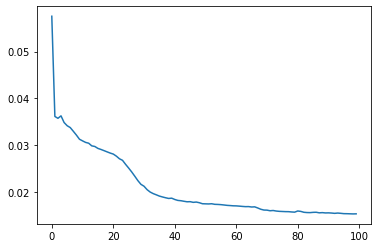

In [ ]:
plt.plot(history)

In [ ]:
# Testing the AE
test_loss = 0

for user in testset.userid.unique():
    itemidx = testset.loc[testset.userid == user, data_description['items']].values
    feedbackidx = testset.loc[testset.userid == user, data_description['feedback']].values
    values = np.ones(len(itemidx), dtype=np.float32)

    user_tensor_test = torch.sparse_coo_tensor(np.array([itemidx, feedbackidx-1]), torch.tensor(values),
                              size=torch.Size((data_description["n_items"], data_description['n_ratings']))).to_dense().to(device).unsqueeze(0)
    target = user_tensor_test.clone()
    
    output = ae(user_tensor_test)
    target.require_grad = False

    loss = criterion(output, target)
    test_loss += loss.data.item()
    
print('test loss: '+str(test_loss / testset.userid.nunique()))

test loss: 0.02183415055544881


In [ ]:
scores = torch.zeros((len(testset.userid.unique()), data_description['n_items']))
for i, user in enumerate(testset.userid.unique()):
    itemidx = testset.loc[testset.userid == user, data_description['items']].values
    feedbackidx = testset.loc[testset.userid == user, data_description['feedback']].values
    values = np.ones(len(itemidx), dtype=np.float32)

    user_matrix_test = torch.sparse_coo_tensor(np.array([itemidx, feedbackidx-1]), torch.tensor(values),
                              size=torch.Size((data_description["n_items"], data_description['n_ratings']))).to_dense().unsqueeze(0).to(device)
    
    output = ae(user_matrix_test)
    scores[i] = output[0][:, -1].T

        
scores = scores.detach().numpy()

In [ ]:
# our
downvote_seen_items(scores, testset, data_description)
make_prediction(scores, holdout, data_description)

HR@5 = 0.0207, MRR@5 = 0.0097, Coverage@5 = 0.2287
HR_pos@5 = 0.0196, HR_neg@5 = 0.0012
MRR_pos@5 = 0.0089, MRR_neg@5 = 0.0007
Matthews@5 = 0.0455
-------------------------------------
HR@10 = 0.0288, MRR@10 = 0.0107, Coverage@10 = 0.2981
HR_pos@10 = 0.0265, HR_neg@10 = 0.0023
MRR_pos@10 = 0.0098, MRR_neg@10 = 0.0009
Matthews@10 = 0.0427
-------------------------------------
HR@20 = 0.0454, MRR@20 = 0.0119, Coverage@20 = 0.4004
HR_pos@20 = 0.0431, HR_neg@20 = 0.0023
MRR_pos@20 = 0.0110, MRR_neg@20 = 0.0009
Matthews@20 = 0.0711
-------------------------------------


(0.010699453252644743, 0.02875215641173088, 0.042746208372664046)